## Path Integration Tests for the Fine-Tuned/Trained GPT-2 Medium Model (Batch Processing on CUDA)
This script tests the fine-tuned GPT-2 Medium model on more structured quantitative tests over randomly generated grids:

* Path integration test
* Hamiltonian (suboptimal) path integration test

### Installations & importing libraries

In [1]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/modelling_spatial_navigation/BehaviouralData"

Mounted at /content/drive
/content/drive/My Drive/modelling_spatial_navigation/BehaviouralData


In [2]:
# python and pip version check
! which python
! which pip
! python --version

/usr/local/bin/python
/usr/local/bin/pip
Python 3.10.12


In [3]:
! pip install git+https://github.com/huggingface/transformers --upgrade
! pip install accelerate evaluate wonderwords simpletransformers --upgrade
! pip install huggingface_hub --upgrade

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-kq7pxf2g
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-kq7pxf2g
  Resolved https://github.com/huggingface/transformers to commit 0f67ba1d741d65b07d549daf4ee157609ce4f9c1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.42.0.dev0-py3-none-any.whl size=9269482 sha256=42045f23980b4483857752e7248d59b7880ef0c7fb72ef85b70f72567b2c85b9
  Stored in directory: /tmp/pip-ephem-wheel-cache-pgj_tih7/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import random
import pandas as pd
import networkx as nx
import logging
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import random
import string
import os
import re
import glob
import torch
from wonderwords import RandomWord
import os
import gc
import pickle
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from itertools import permutations
import logging
from random import shuffle
from matplotlib import pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import math
from matplotlib.ticker import MaxNLocator
import tkinter as tk
from tkinter import messagebox
import matplotlib.lines as mlines
import matplotlib.patheffects as PathEffects
from collections import Counter
from typing import Tuple
from typing import List
from itertools import combinations
import ast

os.environ["WANDB_DISABLED"] = "true"

### Define all GUIs and Functions

In [5]:
Random_Word = RandomWord()

# Generate a unique random grid of nouns
def create_unique_random_grid(nouns, size):
    random_nouns = random.sample(nouns, size * size)
    return [random_nouns[i * size:(i + 1) * size] for i in range(size)]

def generate_path_sequences(participant_data, window_size):
    prev_path_coords = []
    prev_optimalities = []

    for i in range(len(participant_data)):
        start_index = max(0, i - window_size)
        paths = participant_data['path'][start_index:i].tolist()
        optimalities = participant_data['optimal_response'][start_index:i].tolist()

        prev_path_coords.append(paths)
        prev_optimalities.append(optimalities)

    participant_data['prev_path_coords'] = prev_path_coords
    participant_data['prev_optimalities'] = prev_optimalities

def get_direction(prev_coord, coord):
    if coord[0] == prev_coord[0]:
        if coord[1] > prev_coord[1]:
            return "R"
        else:
            return "L"
    else:
        if coord[0] > prev_coord[0]:
            return "D"
        else:
            return "U"

def get_movement_options(coord, grid_size, prev_coord):
    options = ["U", "D", "L", "R"]
    moves = {
        "U": (coord[0] - 1, coord[1]),
        "D": (coord[0] + 1, coord[1]),
        "L": (coord[0], coord[1] - 1),
        "R": (coord[0], coord[1] + 1)
    }
    valid_moves = []
    for option in options:
        move = moves[option]
        if 0 <= move[0] < grid_size and 0 <= move[1] < grid_size and move != prev_coord:
            valid_moves.append(option)
        else:
            valid_moves.append("NA")
    return f"[{' '.join(valid_moves)}]"

def generate_shortest_path_string(grid, path_coords, probability=0):
    if not path_coords:
        return ""

    size = len(grid)
    start, end = path_coords[0], path_coords[-1]
    path_string = f"S: {grid[start[0]][start[1]]}, E: {grid[end[0]][end[1]]}, P: "
    prev_coord = None
    first_step = True

    for i, coord in enumerate(path_coords):
        if coord == start:
            path_string += grid[start[0]][start[1]]
        else:
            direction = get_direction(prev_coord, coord)
            if first_step:
                movement_options = get_movement_options(prev_coord, size, path_coords[i - 2] if i > 1 else None)
                path_string += f" {movement_options} {direction}"
                first_step = False
            else:
                path_string += f" {direction}"

            if coord == end:
                path_string += f" {grid[coord[0]][coord[1]]}"
            else:
                if random.random() < probability:
                    path_string += f" {grid[coord[0]][coord[1]]}"
                else:
                    path_string += " F"

        prev_coord = coord

    return path_string

# Function to generate path strings
def generate_path_strings(grid, prev_path_coords, prev_optimalities):
    path_strings = []

    for path_coords, optimalities in zip(prev_path_coords, prev_optimalities):
        path_string_list = []
        for coords, is_optimal in zip(path_coords, optimalities):
            try:
                coords = ast.literal_eval(coords)  # Convert string representation of tuples back to tuples
                if is_optimal:
                    path_string_list.append(generate_shortest_path_string(grid, coords))
                else:
                    path_string_list.append(generate_shortest_path_string(grid, coords))
            except (ValueError, SyntaxError) as e:
                print(f"Error parsing coordinates: {coords}, Error: {e}")
                path_string_list.append("")

        path_strings.append(path_string_list)

    return path_strings

# Function to append target path to generated paths
def copy_paste_append_target_path(path_prompts, target_start, target_end, grid):
    # Convert string representation of tuples back to tuples
    target_start = ast.literal_eval(target_start)
    target_end = ast.literal_eval(target_end)

    target_path_start = grid[target_start[0]][target_start[1]]
    target_path_end = grid[target_end[0]][target_end[1]]
    size = len(grid)
    movement_options = get_movement_options(target_start, size, None)
    target_path_prompt = f"S: {target_path_start}, E: {target_path_end}, P: {target_path_start} {movement_options}"

    # Join the path strings with "\n"
    path_prompt = "\n".join(path_prompts)

    # Concatenate the path prompt with the target path prompt, separated by "\n"
    updated_path_prompt = f"{path_prompt}\n{target_path_prompt}"
    return updated_path_prompt

# Function to calculate the index of the test path in the model output (same as the number of input paths)
def calculate_path_index(input_paths):
    path_index = len(input_paths.strip().split('\n')) # The index of the test path in the model output
    return path_index

def generate_model_outputs(model, input_prompts, start_coordinates_list, end_coordinates_list,
                           batch_size, grid_size, grid_nouns):
    outputs = []
    for i in range(0, len(input_prompts), batch_size):
        batch_prompts = input_prompts[i:i + batch_size]
        batch_start_coords = start_coordinates_list[i:i + batch_size]
        batch_end_coords = end_coordinates_list[i:i + batch_size]
        batch_output = []
        for prompt, start_coords , end_coords in zip(batch_prompts, batch_start_coords, batch_end_coords):
            #print(f"Prompt: {prompt}, Start Coords: {start_coords}, End Coords: {end_coords}")  # Debugging line
            output = model.continue_input([prompt], start_coordinates=start_coords,
                                          end_coordinates=end_coords, grid_size=grid_size, grid_nouns=grid_nouns)
            batch_output.append(output)
        outputs.extend(batch_output)
        torch.cuda.empty_cache()
        gc.collect()
    return outputs

# Function to extract first line of model output after the input prompt lines
def extract_path(path_index, model_output):
    output_lines = model_output.strip().split('\n')

    # Ensure the selected path_index is within the range of available lines
    if path_index < 0 or path_index >= len(output_lines):
        print("Path index out of range. Make sure the output has enough lines.")
        return []

    # Extract the desired line
    output_line = output_lines[path_index]

    # Extract path description after "PATH:"
    path_start = output_line.find("P:") + len("P: ")
    path_description = output_line[path_start:].strip()

    return path_description

# Function to convert path direction descriptions to coordinates on the grid
def direction_to_coords(directions_str, start_coord):
    if not (isinstance(start_coord, tuple) and len(start_coord) == 2):
        print(f"Invalid start_coord: {start_coord}")
        return []

    # Remove text within square brackets
    directions_str = re.sub(r'\[.*?\]', '', directions_str)

    directions = directions_str.split()

    x, y = start_coord
    path = [(x, y)]

    move_dict = {
        "U": (-1, 0),
        "D": (1, 0),
        "L": (0, -1),
        "R": (0, 1)
    }

    for direction in directions:
        if direction in move_dict:
            dx, dy = move_dict[direction]
            x += dx
            y += dy
            if x < 0 or x >= 4 or y < 0 or y >= 4:
                print(f"Out of bounds: direction {direction}, new coordinates ({x}, {y})")  # Debugging line
            path.append((x, y))

    print(f"Path: {path}")  # Debugging line

    return path

# Check number of optimal steps for each path
def calculate_optimal_steps(start, end):
    horizontal_steps = abs(end[1] - start[1])  # Difference in columns
    vertical_steps = abs(end[0] - start[0])    # Difference in rows
    return horizontal_steps + vertical_steps

# Calculate the number of steps in the generated path
def calculate_generated_steps(coords_list):
    return len(coords_list) - 1

### Create Class to load the trained GPT-2 Medium model with a specific set of hyperparameters
* Batch generation of output sequences

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPTNeoForCausalLM

num_beams = 2

class GPT:

    def __init__(self, base_model, device):
        self.device = device
        self.tokenizer = GPT2Tokenizer.from_pretrained(base_model, padding_side='left')

        if self.tokenizer.pad_token is None:
            print("Pad token not found, setting pad token to EOS token.")
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = GPTNeoForCausalLM.from_pretrained(base_model)
        self.model.to(self.device)

    def continue_input(self, input_sequences, max_new_tokens=50, no_repeat_ngram_size=0,
                       do_sample=False, num_beams=num_beams, early_stopping=False,
                       start_coordinates=(0, 0), end_coordinates=(3, 3), grid_size=4):

        pad_token_id = self.tokenizer.pad_token_id
        input_ids = self.tokenizer(input_sequences, return_tensors='pt', padding=True, pad_to_multiple_of=8).input_ids.to(self.device)
        newline_token_id = self.tokenizer.encode("\n")[0]
        tokens_to_avoid = ["\n", "S", "E", "P", ":", ",", "[", "]", "N", "A", "NA"]
        avoid_token_ids = [self.tokenizer.encode(token)[0] for token in tokens_to_avoid]

        x, y = start_coordinates
        x_end, y_end = end_coordinates
        max_x, max_y = grid_size, grid_size

        direction_tokens = {
            "U": self.tokenizer.encode("U")[0],
            "D": self.tokenizer.encode("D")[0],
            "L": self.tokenizer.encode("L")[0],
            "R": self.tokenizer.encode("R")[0]
        }

        generated_sequence = input_sequences[0]

        for _ in range(max_new_tokens):
            # Update bad_words_ids based on current position
            bad_words_ids = avoid_token_ids

            if (x, y) == (x_end, y_end):
                bad_words_ids.extend([direction_tokens["U"], direction_tokens["D"], direction_tokens["L"], direction_tokens["R"]])
            else:
                if y + 1 >= max_y:
                    bad_words_ids.append(direction_tokens["R"])
                if x + 1 >= max_x:
                    bad_words_ids.append(direction_tokens["D"])
                if y - 1 < 0:
                    bad_words_ids.append(direction_tokens["L"])
                if x - 1 < 0:
                    bad_words_ids.append(direction_tokens["U"])

            bad_words_ids = [[token] for token in bad_words_ids] if bad_words_ids else None

            #print(f"Current Coordinates: ({x}, {y}), Bad Words IDs: {bad_words_ids}")  # Debugging line

            output_sequences = self.model.generate(
                input_ids,
                max_new_tokens=1,
                num_beams=num_beams,
                no_repeat_ngram_size=no_repeat_ngram_size,
                do_sample=do_sample,
                early_stopping=early_stopping,
                pad_token_id=pad_token_id,
                bad_words_ids=bad_words_ids,
            )

            next_token = output_sequences[0, -1].item()
            next_token_text = self.tokenizer.decode([next_token], skip_special_tokens=True)

            #print(f"Next token: {next_token_text}, Coordinates: ({x}, {y})")  # Debugging line

            # Update coordinates based on the decoded token text
            if next_token_text.strip() in direction_tokens:
                if next_token_text.strip() == "R":
                    y += 1
                elif next_token_text.strip() == "D":
                    x += 1
                elif next_token_text.strip() == "L":
                    y -= 1
                elif next_token_text.strip() == "U":
                    x -= 1

            # Print updated coordinates for debugging
            print(f"Updated Coordinates: ({x}, {y}) after token: {next_token_text}")

            input_ids = torch.cat((input_ids, output_sequences[:, -1:]), dim=1)
            generated_sequence += self.tokenizer.decode([next_token], skip_special_tokens=True)

            if (x, y) == (x_end, y_end):
                print("End coordinates reached.")
                break

        return generated_sequence

if torch.cuda.is_available():
    print("CUDA available. Using CUDA.")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("MPS available. Using MPS.")
    device = torch.device("mps")
else:
    print("CUDA and MPS not available. Using CPU.")
    device = torch.device("cpu")


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPTNeoForCausalLM

num_beams = 2

class GPT:

    def __init__(self, base_model, device):
        self.device = device
        self.tokenizer = GPT2Tokenizer.from_pretrained(base_model, padding_side='left')

        if self.tokenizer.pad_token is None:
            print("Pad token not found, setting pad token to EOS token.")
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = GPTNeoForCausalLM.from_pretrained(base_model)
        self.model.to(self.device)

    def continue_input(self, input_sequences, max_new_tokens=50, no_repeat_ngram_size=0,
                       do_sample=False, num_beams=num_beams, early_stopping=False,
                       start_coordinates=(0, 0), end_coordinates=(3, 3), grid_size=4,
                       repetition_penalty=5):  # Added repetition_penalty with default value

        pad_token_id = self.tokenizer.pad_token_id
        input_ids = self.tokenizer(input_sequences, return_tensors='pt', padding=True, pad_to_multiple_of=8).input_ids.to(self.device)
        newline_token_id = self.tokenizer.encode("\n")[0]
        tokens_to_avoid = ["\n", "S", "E", "P", ":", ",", "[", "]", "N", "A", "NA"]
        avoid_token_ids = [self.tokenizer.encode(token)[0] for token in tokens_to_avoid]

        x, y = start_coordinates
        x_end, y_end = end_coordinates
        max_x, max_y = grid_size, grid_size

        direction_tokens = {
            "U": self.tokenizer.encode("U")[0],
            "D": self.tokenizer.encode("D")[0],
            "L": self.tokenizer.encode("L")[0],
            "R": self.tokenizer.encode("R")[0]
        }

        generated_sequence = input_sequences[0]

        for _ in range(max_new_tokens):
            # Update bad_words_ids based on current position
            bad_words_ids = avoid_token_ids

            if (x, y) == (x_end, y_end):
                bad_words_ids.extend([direction_tokens["U"], direction_tokens["D"], direction_tokens["L"], direction_tokens["R"]])
            else:
                if y + 1 >= max_y:
                    bad_words_ids.append(direction_tokens["R"])
                if x + 1 >= max_x:
                    bad_words_ids.append(direction_tokens["D"])
                if y - 1 < 0:
                    bad_words_ids.append(direction_tokens["L"])
                if x - 1 < 0:
                    bad_words_ids.append(direction_tokens["U"])

            bad_words_ids = [[token] for token in bad_words_ids] if bad_words_ids else None

            #print(f"Current Coordinates: ({x}, {y}), Bad Words IDs: {bad_words_ids}")  # Debugging line

            output_sequences = self.model.generate(
                input_ids,
                max_new_tokens=1,
                num_beams=num_beams,
                no_repeat_ngram_size=no_repeat_ngram_size,
                do_sample=do_sample,
                early_stopping=early_stopping,
                pad_token_id=pad_token_id,
                bad_words_ids=bad_words_ids,
                repetition_penalty=repetition_penalty,  # Added repetition_penalty parameter
            )

            next_token = output_sequences[0, -1].item()
            next_token_text = self.tokenizer.decode([next_token], skip_special_tokens=True)

            #print(f"Next token: {next_token_text}, Coordinates: ({x}, {y})")  # Debugging line

            # Update coordinates based on the decoded token text
            if next_token_text.strip() in direction_tokens:
                if next_token_text.strip() == "R":
                    y += 1
                elif next_token_text.strip() == "D":
                    x += 1
                elif next_token_text.strip() == "L":
                    y -= 1
                elif next_token_text.strip() == "U":
                    x -= 1

            # Print updated coordinates for debugging
            print(f"Updated Coordinates: ({x}, {y}) after token: {next_token_text}")

            input_ids = torch.cat((input_ids, output_sequences[:, -1:]), dim=1)
            generated_sequence += self.tokenizer.decode([next_token], skip_special_tokens=True)

            if (x, y) == (x_end, y_end):
                print("End coordinates reached.")
                break

        return generated_sequence

if torch.cuda.is_available():
    print("CUDA available. Using CUDA.")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("MPS available. Using MPS.")
    device = torch.device("mps")
else:
    print("CUDA and MPS not available. Using CPU.")
    device = torch.device("cpu")


CUDA available. Using CUDA.


In [6]:
# The latest one that is working
import torch
from transformers import GPT2Tokenizer, GPTNeoForCausalLM
import random

num_beams = 2

class GPT:
    def __init__(self, base_model, device):
        self.device = device
        self.tokenizer = GPT2Tokenizer.from_pretrained(base_model, padding_side='left')

        if self.tokenizer.pad_token is None:
            print("Pad token not found, setting pad token to EOS token.")
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self.model = GPTNeoForCausalLM.from_pretrained(base_model)
        self.model.to(self.device)

    def continue_input(self, input_sequences, max_new_tokens=50, no_repeat_ngram_size=0,
                       do_sample=False, num_beams=num_beams, early_stopping=False,
                       start_coordinates=(0, 0), end_coordinates=(3, 3), grid_size=4,
                       grid_nouns=None, probability=0):

        if grid_nouns is None:
            grid_nouns = []

        pad_token_id = self.tokenizer.pad_token_id
        input_ids = self.tokenizer(input_sequences, return_tensors='pt', padding=True, pad_to_multiple_of=8).input_ids.to(self.device)
        tokens_to_avoid = ["\n", "S", "E", "P", ":", ",", "[", "]", "N", "A", "NA"]
        avoid_token_ids = [self.tokenizer.encode(token)[0] for token in tokens_to_avoid]

        x, y = start_coordinates
        x_end, y_end = end_coordinates
        max_x, max_y = grid_size, grid_size

        direction_tokens = {
            "U": self.tokenizer.encode("U")[0],
            "D": self.tokenizer.encode("D")[0],
            "L": self.tokenizer.encode("L")[0],
            "R": self.tokenizer.encode("R")[0]
        }

        generated_sequence = input_sequences[0]
        previous_coordinates = None

        for _ in range(max_new_tokens):
            # Update bad_words_ids based on current position
            bad_words_ids = avoid_token_ids.copy()

            if (x, y) == (x_end, y_end):
                bad_words_ids.extend([direction_tokens["U"], direction_tokens["D"], direction_tokens["L"], direction_tokens["R"]])
            else:
                if y + 1 >= max_y or (x, y + 1) == previous_coordinates:
                    bad_words_ids.append(direction_tokens["R"])
                if x + 1 >= max_x or (x + 1, y) == previous_coordinates:
                    bad_words_ids.append(direction_tokens["D"])
                if y - 1 < 0 or (x, y - 1) == previous_coordinates:
                    bad_words_ids.append(direction_tokens["L"])
                if x - 1 < 0 or (x - 1, y) == previous_coordinates:
                    bad_words_ids.append(direction_tokens["U"])

            bad_words_ids = [[token] for token in bad_words_ids] if bad_words_ids else None

            output_sequences = self.model.generate(
                input_ids,
                max_new_tokens=1,
                num_beams=num_beams,
                no_repeat_ngram_size=no_repeat_ngram_size,
                do_sample=do_sample,
                early_stopping=early_stopping,
                pad_token_id=pad_token_id,
                bad_words_ids=bad_words_ids,
            )

            next_token = output_sequences[0, -1].item()
            next_token_text = self.tokenizer.decode([next_token], skip_special_tokens=True).strip()

            # Update coordinates based on the decoded token text
            if next_token_text == "R" and y + 1 < max_y:
                y += 1
            elif next_token_text == "D" and x + 1 < max_x:
                x += 1
            elif next_token_text == "L" and y - 1 >= 0:
                y -= 1
            elif next_token_text == "U" and x - 1 >= 0:
                x -= 1

            # Update the generated sequence with the direction token
            generated_sequence += " " + next_token_text

            # Add the location noun or "F" probabilistically
            if 0 <= x < grid_size and 0 <= y < grid_size:
                if random.random() < probability and grid_nouns:
                    generated_sequence += " " + grid_nouns[x][y]
                else:
                    generated_sequence += " F"

            # Print updated coordinates for debugging
            print(f"Updated Coordinates: ({x}, {y}) after token: {next_token_text}")

            input_ids = self.tokenizer(generated_sequence, return_tensors='pt', padding=True, pad_to_multiple_of=8).input_ids.to(self.device)

            if (x, y) == (x_end, y_end):
                print("End coordinates reached.")
                break

        return generated_sequence.strip()

if torch.cuda.is_available():
    print("CUDA available. Using CUDA.")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("MPS available. Using MPS.")
    device = torch.device("mps")
else:
    print("CUDA and MPS not available. Using CPU.")
    device = torch.device("cpu")

CUDA available. Using CUDA.


### Test Model on Participant Data

In [7]:
torch.cuda.empty_cache()
gc.collect()

16

In [8]:
# Define the function to process a single participant with multiple grids
def process_participant(file_name, size, window_size, model, batch_size, output_dir, num_grids):

    # Read participant data from CSV file
    participant_data = pd.read_csv(file_name)

    for grid_index in range(num_grids):

        torch.cuda.empty_cache()
        gc.collect()

        # Generate a random grid of nouns
        nouns = set()
        while len(nouns) < size * size:
            word = Random_Word.word(include_parts_of_speech=["nouns"]).replace(" ", "_")
            nouns.add(word)
        nouns = list(nouns)

        grid = create_unique_random_grid(nouns, size)

        # Generate the sequences with the specified window size
        generate_path_sequences(participant_data, window_size=window_size)

        # Apply the function to the dataset
        participant_data['path_strings'] = generate_path_strings(
            grid,
            participant_data['prev_path_coords'],
            participant_data['prev_optimalities']
        )

        # Count the number of path strings in path_strings
        participant_data['num_input'] = participant_data['path_strings'].apply(lambda x: len(x))

        # Ensure 'start' and 'end' are read as strings
        participant_data['start'] = participant_data['start'].astype(str)
        participant_data['end'] = participant_data['end'].astype(str)

        # Apply the adjusted append_target_path function to each row in the DataFrame
        participant_data['input_prompt'] = participant_data.apply(
            lambda row: copy_paste_append_target_path(
                row['path_strings'],
                row['start'],
                row['end'],
                grid
            ),
            axis=1
        )

        # Ensure 'start' and 'end' are tuples of integers
        participant_data['start'] = participant_data['start'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x).apply(tuple)
        participant_data['end'] = participant_data['end'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x).apply(tuple)

        # Batch generation of model outputs for the input prompts
        input_prompts = participant_data['input_prompt'].tolist()
        start_coordinates_list = participant_data['start'].tolist()
        end_coordinates_list = participant_data['end'].tolist()

        model_outputs = generate_model_outputs(model, input_prompts, start_coordinates_list,
                                               end_coordinates_list, batch_size, grid_size=size, grid_nouns=grid)

        # Extract the output
        participant_data['output'] = model_outputs

        # Apply the adjusted extract_path function to each row in the DataFrame
        participant_data['extracted_output'] = participant_data.apply(
            lambda row: extract_path(
                row['num_input'],
                row['output']
            ),
            axis=1
        )

        # Ensure 'start' and 'end' are tuples of integers
        participant_data['start'] = participant_data['start'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x).apply(tuple)
        participant_data['end'] = participant_data['end'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x).apply(tuple)

        # Apply the adjusted path_to_coords function to each row in the DataFrame
        participant_data['output_coords'] = participant_data.apply(
            lambda row: direction_to_coords(
                row['extracted_output'],
                row['start'],
            ),
            axis=1
        )

        # Apply the adjusted calculate_generated_steps function to each row in the DataFrame
        participant_data['generated_steps'] = participant_data['output_coords'].apply(lambda x: calculate_generated_steps(x))

        # Check if the generated path is optimal for each row
        participant_data['optimal_num_steps'] = participant_data['stepDist'] == participant_data['generated_steps']

        # Ensure 'start' and 'end' are tuples of integers
        participant_data['start'] = participant_data['start'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x).apply(tuple)
        participant_data['end'] = participant_data['end'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x).apply(tuple)

        # Check if the extracted start and end points are same as the target start and end points
        participant_data['start_end_validity'] = participant_data.apply(
            lambda row: row['output_coords'][0] == row['start'] and row['output_coords'][-1] == row['end'],
            axis=1
        )

        # Check if the generated path is both valid and optimal
        participant_data['optimality'] = participant_data.apply(
            lambda row: all([row['optimal_num_steps'], row['start_end_validity']]),
            axis=1
        )

        # Save the DataFrame to a CSV file in the output directory
        output_file_name = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(file_name))[0]}_Grid_{grid_index}.csv")
        participant_data.to_csv(output_file_name, index=False)

        # Count the number of optimal paths generated by the model
        num_model_optimal_paths = participant_data['optimality'].sum()
        print(f"Number of optimal paths generated by the model for grid {grid_index}: {num_model_optimal_paths}")

        # Count the number of optimal paths generated by the participant
        num_participant_optimal_paths = participant_data['optimal_response'].sum()
        print(f"Number of optimal paths by the participant for grid {grid_index}: {num_participant_optimal_paths}")

# Main script
def main():

    input_dir = "PreprocessedSubjectData"
    size = 4
    window_size = 16
    model = GPT(base_model='gpt_neo_shortest_only_v14_3000_4by4grids_modelling/spatial_model', device=device)
    max_new_tokens = 100
    batch_size = 100  # This is crucial for efficient GPU computation
    num_grids = 2  # Specify the number of grids to generate for each participant
    resume_from_participant = 0  # Specify the participant number to resume from

    output_dir = f"ModelOutput_{window_size}_with_options"
    os.makedirs(output_dir, exist_ok=True)

    # Initialize participant counter
    participant_counter = 0

    # Function to extract the numerical part of the file name
    def extract_number(file_name):
        match = re.search(r'\d+', file_name)
        return int(match.group()) if match else float('inf')

    # Get sorted list of files based on the numerical suffix
    files = sorted(
        [f for f in os.listdir(input_dir) if f.endswith(".csv")],
        key=extract_number
    )

    # Process each file in the input directory
    for file_name in files:
        participant_number = extract_number(file_name)
        if participant_number < resume_from_participant:
            continue

        full_file_name = os.path.join(input_dir, file_name)

        process_participant(full_file_name, size, window_size, model, batch_size, output_dir, num_grids)

        # Increment the participant counter
        participant_counter += 1
        print(f"Processed participant {participant_counter}")

if __name__ == "__main__":
    main()


Pad token not found, setting pad token to EOS token.


The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Streaming output truncated to the last 5000 lines.
Updated Coordinates: (1, 2) after token: D
Updated Coordinates: (1, 1) after token: L
Updated Coordinates: (2, 1) after token: D
Updated Coordinates: (3, 1) after token: D
Updated Coordinates: (3, 0) after token: L
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordinates: (3, 0) after token: latter
Updated Coordi

### Result Analyses

#### Optimal path percentage

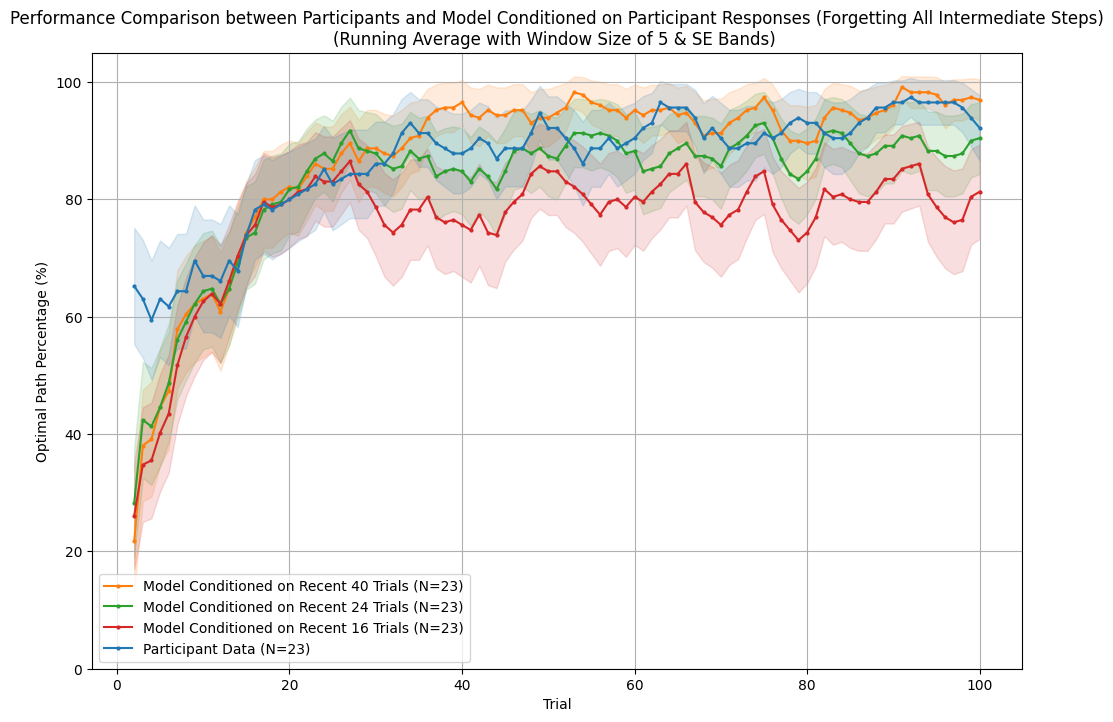

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_percentage_optimal(data, response_column):
    trial_optimal_counts = data.groupby('trial')[response_column].agg(['mean', 'count']).reset_index()
    trial_optimal_counts['optimal_percentage'] = trial_optimal_counts['mean'] * 100
    trial_optimal_counts['standard_error'] = np.sqrt(trial_optimal_counts['mean'] * (1 - trial_optimal_counts['mean']) / trial_optimal_counts['count']) * 100
    return trial_optimal_counts

def calculate_running_average_percentage(data, window_size):
    data = data[data['trial'] > 1].reset_index(drop=True)
    data['running_avg_percentage'] = data['optimal_percentage'].rolling(window=window_size, min_periods=1).mean()
    data['running_avg_se'] = data['standard_error'].rolling(window=window_size, min_periods=1).apply(
        lambda x: np.sqrt(np.sum(x**2) / len(x))
    )
    return data

def plot_combined_running_average(data_list, labels, window_size, num_files_list):
    plt.figure(figsize=(12, 8))
    colors = ['tab:orange', 'tab:green', 'tab:red', 'tab:blue']
    
    for i, data in enumerate(data_list):
        label = labels[i]
        num_files = num_files_list[i]
        color = colors[i % len(colors)]
        
        plt.plot(data['trial'], data['running_avg_percentage'], marker='o', linestyle='-', color=color, label=f'{label} (N={num_files})', markersize=2)
        plt.fill_between(data['trial'],
                         data['running_avg_percentage'] - data['running_avg_se'],
                         data['running_avg_percentage'] + data['running_avg_se'],
                         color=color, alpha=0.15)
    
    plt.title(f'Performance Comparison between Participants and Model Conditioned on Participant Responses (Forgetting All Intermediate Steps)\n(Running Average with Window Size of {window_size} & SE Bands) ')
    plt.xlabel('Trial')
    plt.ylabel(f'Optimal Path Percentage (%)')
    plt.ylim(bottom=0, top=105)
    plt.grid(True)
    plt.legend()
    plt.savefig('combined_optimality_percentage_comparison.png')
    plt.show()

def process_folder(folder_path, response_column, window_size):
    num_files = len([filename for filename in os.listdir(folder_path) if filename.endswith('.csv')])

    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])

    percentage_optimal_data = calculate_percentage_optimal(all_data, response_column)
    running_average_data = calculate_running_average_percentage(percentage_optimal_data, window_size)

    return running_average_data, num_files

def average_optimality_over_grids(folder_path, response_column):
    subject_files = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            subject_id = filename.split('_')[0]
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path)
            
            if subject_id not in subject_files:
                subject_files[subject_id] = []
            subject_files[subject_id].append(data)
    
    averaged_data = []
    for subject_id, data_list in subject_files.items():
        combined_data = pd.concat(data_list)
        averaged_optimality = combined_data.groupby('trial')[response_column].mean().reset_index()
        averaged_optimality['subject_id'] = subject_id
        averaged_data.append(averaged_optimality)
    
    averaged_folder_path = folder_path + '_Average_Optimality'
    if not os.path.exists(averaged_folder_path):
        os.makedirs(averaged_folder_path)
    
    for averaged_optimality in averaged_data:
        subject_id = averaged_optimality['subject_id'].iloc[0]
        averaged_optimality.drop(columns=['subject_id'], inplace=True)
        averaged_optimality.to_csv(os.path.join(averaged_folder_path, f'{subject_id}.csv'), index=False)

def process_all_folders_and_plot(folder_paths, response_columns, labels, window_size):
    running_average_data_list = []
    num_files_list = []
    
    for folder_path, response_column in zip(folder_paths, response_columns):
        if 'ModelOutput' in folder_path:
            average_optimality_over_grids(folder_path, response_column)
            averaged_folder_path = folder_path + '_Average_Optimality'
        else:
            averaged_folder_path = folder_path
        
        running_average_data, num_files = process_folder(averaged_folder_path, response_column, window_size)
        running_average_data_list.append(running_average_data)
        num_files_list.append(num_files)
    
    plot_combined_running_average(running_average_data_list, labels, window_size, num_files_list)

# Set the folder paths and window size
folder_paths = ['ModelOutput_40_with_options', 'ModelOutput_24_with_options', 'ModelOutput_16_with_options', 'PreprocessedSubjectData']
response_columns = ['optimality', 'optimality', 'optimality', 'optimal_response']
labels = ['Model Conditioned on Recent 40 Trials', 
          'Model Conditioned on Recent 24 Trials', 
          'Model Conditioned on Recent 16 Trials', 
          'Participant Data']

window_size = 5

# Process all folders and plot the combined running average
process_all_folders_and_plot(folder_paths, response_columns, labels, window_size)


best fitting line only

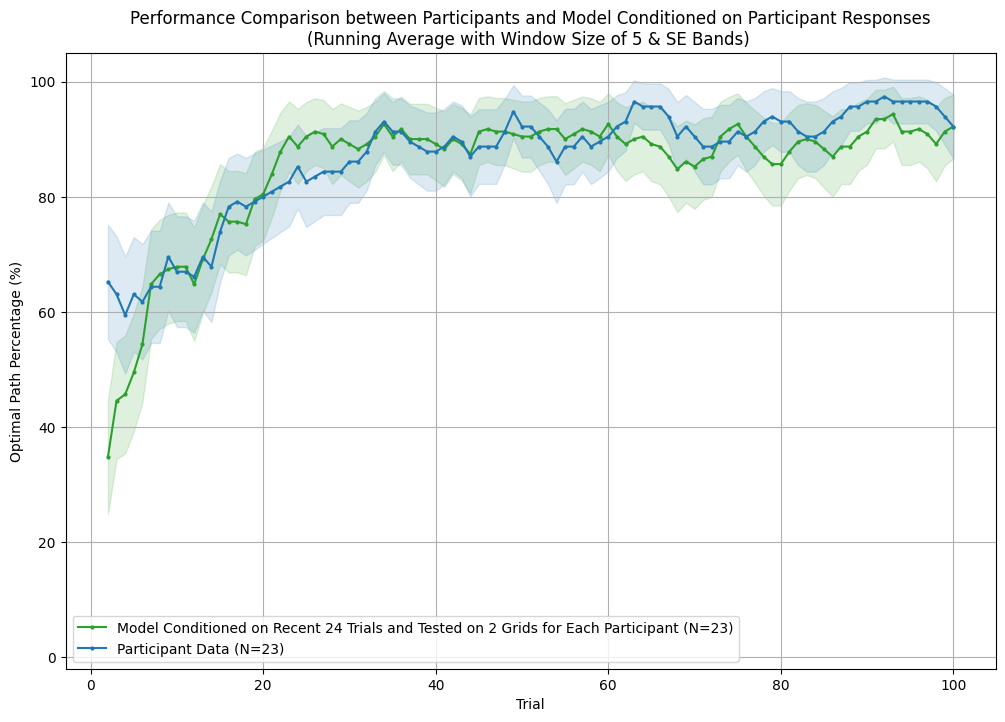

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_percentage_optimal(data, response_column):
    trial_optimal_counts = data.groupby('trial')[response_column].agg(['mean', 'count']).reset_index()
    trial_optimal_counts['optimal_percentage'] = trial_optimal_counts['mean'] * 100
    trial_optimal_counts['standard_error'] = np.sqrt(trial_optimal_counts['mean'] * (1 - trial_optimal_counts['mean']) / trial_optimal_counts['count']) * 100
    return trial_optimal_counts

def calculate_running_average_percentage(data, window_size):
    data = data[data['trial'] > 1].reset_index(drop=True)
    data['running_avg_percentage'] = data['optimal_percentage'].rolling(window=window_size, min_periods=1).mean()
    data['running_avg_se'] = data['standard_error'].rolling(window=window_size, min_periods=1).apply(
        lambda x: np.sqrt(np.sum(x**2) / len(x))
    )
    return data

def plot_combined_running_average(data_list, labels, window_size, num_files_list):
    plt.figure(figsize=(12, 8))
    colors = ['tab:green', 'tab:blue']
    
    for i, data in enumerate(data_list):
        label = labels[i]
        num_files = num_files_list[i]
        color = colors[i % len(colors)]
        
        plt.plot(data['trial'], data['running_avg_percentage'], marker='o', linestyle='-', color=color, label=f'{label} (N={num_files})', markersize=2)
        plt.fill_between(data['trial'],
                         data['running_avg_percentage'] - data['running_avg_se'],
                         data['running_avg_percentage'] + data['running_avg_se'],
                         color=color, alpha=0.15)
    
    plt.title(f'Performance Comparison between Participants and Model Conditioned on Participant Responses\n(Running Average with Window Size of {window_size} & SE Bands) ')
    plt.xlabel('Trial')
    plt.ylabel(f'Optimal Path Percentage (%)')
    plt.ylim(bottom=-2, top=105)
    plt.grid(True)
    plt.legend()
    plt.savefig('best_fitting_optimality_percentage_comparison.png')
    plt.show()

def process_folder(folder_path, response_column, window_size):
    num_files = len([filename for filename in os.listdir(folder_path) if filename.endswith('.csv')])

    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])

    percentage_optimal_data = calculate_percentage_optimal(all_data, response_column)
    running_average_data = calculate_running_average_percentage(percentage_optimal_data, window_size)

    return running_average_data, num_files

def average_optimality_over_grids(folder_path, response_column):
    subject_files = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            subject_id = filename.split('_')[0]
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path)
            
            if subject_id not in subject_files:
                subject_files[subject_id] = []
            subject_files[subject_id].append(data)
    
    averaged_data = []
    for subject_id, data_list in subject_files.items():
        combined_data = pd.concat(data_list)
        averaged_optimality = combined_data.groupby('trial')[response_column].mean().reset_index()
        averaged_optimality['subject_id'] = subject_id
        averaged_data.append(averaged_optimality)
    
    averaged_folder_path = folder_path + '_Average_Optimality'
    if not os.path.exists(averaged_folder_path):
        os.makedirs(averaged_folder_path)
    
    for averaged_optimality in averaged_data:
        subject_id = averaged_optimality['subject_id'].iloc[0]
        averaged_optimality.drop(columns=['subject_id'], inplace=True)
        averaged_optimality.to_csv(os.path.join(averaged_folder_path, f'{subject_id}.csv'), index=False)

def process_all_folders_and_plot(folder_paths, response_columns, labels, window_size):
    running_average_data_list = []
    num_files_list = []
    
    for folder_path, response_column in zip(folder_paths, response_columns):
        if 'ModelOutput' in folder_path:
            average_optimality_over_grids(folder_path, response_column)
            averaged_folder_path = folder_path + '_Average_Optimality'
        else:
            averaged_folder_path = folder_path
        
        running_average_data, num_files = process_folder(averaged_folder_path, response_column, window_size)
        running_average_data_list.append(running_average_data)
        num_files_list.append(num_files)
    
    plot_combined_running_average(running_average_data_list, labels, window_size, num_files_list)

# Set the folder paths and window size
folder_paths = ['ModelOutput_24_with_options', 'PreprocessedSubjectData']
response_columns = ['optimality', 'optimal_response']
labels = ['Model Conditioned on Recent 24 Trials and Tested on 2 Grids for Each Participant', 'Participant Data']
window_size = 5

# Process all folders and plot the combined running average
process_all_folders_and_plot(folder_paths, response_columns, labels, window_size)


break down best fitting line by optimal steps (with versions of rolling average, fixed bin + error band, and fixed bin + error bar)

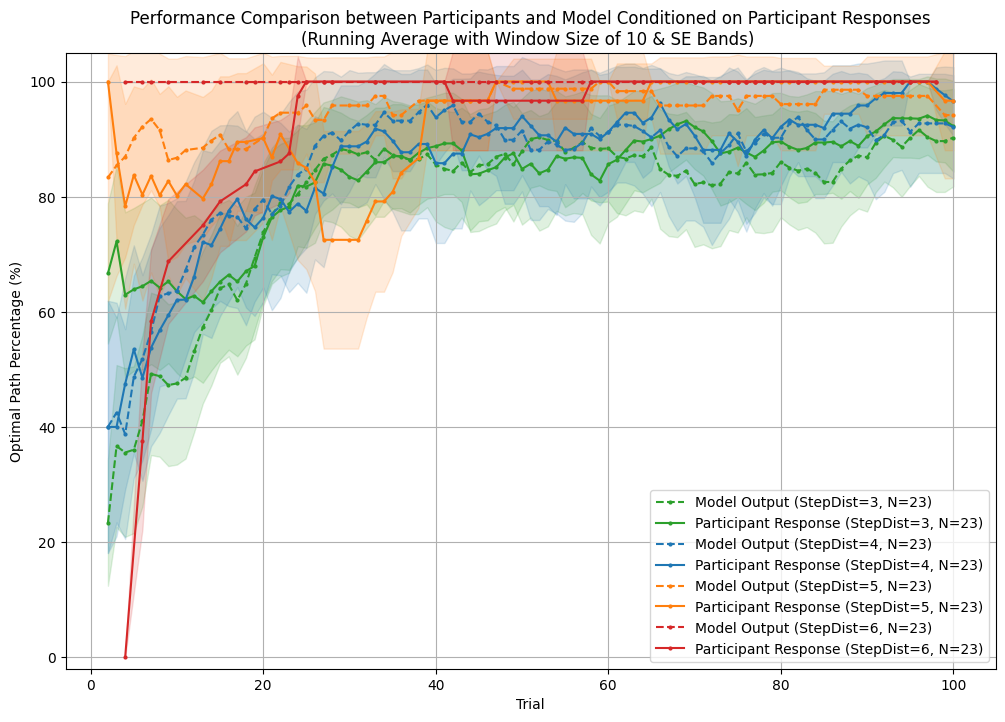

In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_percentage_optimal(data, response_column):
    trial_optimal_counts = data.groupby(['trial', 'stepDist'])[response_column].agg(['mean', 'count']).reset_index()
    trial_optimal_counts['optimal_percentage'] = trial_optimal_counts['mean'] * 100
    trial_optimal_counts['standard_error'] = np.sqrt(trial_optimal_counts['mean'] * (1 - trial_optimal_counts['mean']) / trial_optimal_counts['count']) * 100
    return trial_optimal_counts

def calculate_running_average_percentage(data, window_size):
    data = data[data['trial'] > 1].reset_index(drop=True)
    data['running_avg_percentage'] = data.groupby('stepDist')['optimal_percentage'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    data['running_avg_se'] = data.groupby('stepDist')['standard_error'].transform(lambda x: x.rolling(window=window_size, min_periods=1).apply(
        lambda y: np.sqrt(np.sum(y**2) / len(y))
    ))
    return data

def plot_combined_running_average(data_list, labels, window_size, num_files_list):
    plt.figure(figsize=(12, 8))
    colors = ['tab:green', 'tab:blue', 'tab:orange', 'tab:red', 'tab:purple']
    linestyles = ['-', '--']
    step_dists = sorted(data_list[0]['stepDist'].unique())

    for j, stepDist in enumerate(step_dists):
        color = colors[j % len(colors)]
        for i, data in enumerate(data_list):
            label = labels[i]
            num_files = num_files_list[i]
            linestyle = linestyles[0] if 'Participant Response' in label else linestyles[1]

            subset_data = data[data['stepDist'] == stepDist]
            
            plt.plot(subset_data['trial'], subset_data['running_avg_percentage'], marker='o', linestyle=linestyle, color=color, 
                     label=f'{label} (StepDist={stepDist}, N={num_files})', markersize=2)
            plt.fill_between(subset_data['trial'],
                             subset_data['running_avg_percentage'] - subset_data['running_avg_se'],
                             subset_data['running_avg_percentage'] + subset_data['running_avg_se'],
                             color=color, alpha=0.15)
    
    plt.title(f'Performance Comparison between Participants and Model Conditioned on Participant Responses\n(Running Average with Window Size of {window_size} & SE Bands) ')
    plt.xlabel('Trial')
    plt.ylabel(f'Optimal Path Percentage (%)')
    plt.ylim(bottom=-2, top=105)
    plt.grid(True)
    plt.legend()
    plt.savefig('best_fitting_optimality_percentage_comparison.png')
    plt.show()

def process_folder(folder_path, response_column, window_size):
    num_files = len([filename for filename in os.listdir(folder_path) if filename.endswith('.csv')])

    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])

    percentage_optimal_data = calculate_percentage_optimal(all_data, response_column)
    running_average_data = calculate_running_average_percentage(percentage_optimal_data, window_size)

    return running_average_data, num_files

def average_optimality_over_grids(folder_path, response_column):
    subject_files = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            subject_id = filename.split('_')[0]
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path)
            
            if subject_id not in subject_files:
                subject_files[subject_id] = []
            subject_files[subject_id].append(data)
    
    averaged_data = []
    for subject_id, data_list in subject_files.items():
        combined_data = pd.concat(data_list)
        averaged_optimality = combined_data.groupby(['trial', 'stepDist'])[response_column].mean().reset_index()
        averaged_optimality['subject_id'] = subject_id
        averaged_data.append(averaged_optimality)
    
    averaged_folder_path = folder_path + '_Average_Optimality'
    if not os.path.exists(averaged_folder_path):
        os.makedirs(averaged_folder_path)
    
    for averaged_optimality in averaged_data:
        subject_id = averaged_optimality['subject_id'].iloc[0]
        averaged_optimality.drop(columns=['subject_id'], inplace=True)
        averaged_optimality.to_csv(os.path.join(averaged_folder_path, f'{subject_id}.csv'), index=False)

def process_all_folders_and_plot(folder_paths, response_columns, labels, window_size):
    running_average_data_list = []
    num_files_list = []
    
    for folder_path, response_column in zip(folder_paths, response_columns):
        if 'ModelOutput' in folder_path:
            average_optimality_over_grids(folder_path, response_column)
            averaged_folder_path = folder_path + '_Average_Optimality'
        else:
            averaged_folder_path = folder_path
        
        running_average_data, num_files = process_folder(averaged_folder_path, response_column, window_size)
        running_average_data_list.append(running_average_data)
        num_files_list.append(num_files)
    
    plot_combined_running_average(running_average_data_list, labels, window_size, num_files_list)

# Set the folder paths and window size
folder_paths = ['ModelOutput_24_with_options', 'PreprocessedSubjectData']
response_columns = ['optimality', 'optimal_response']

labels = ['Model Output', 'Participant Response']
window_size = 10

# Process all folders and plot the combined running average
process_all_folders_and_plot(folder_paths, response_columns, labels, window_size)


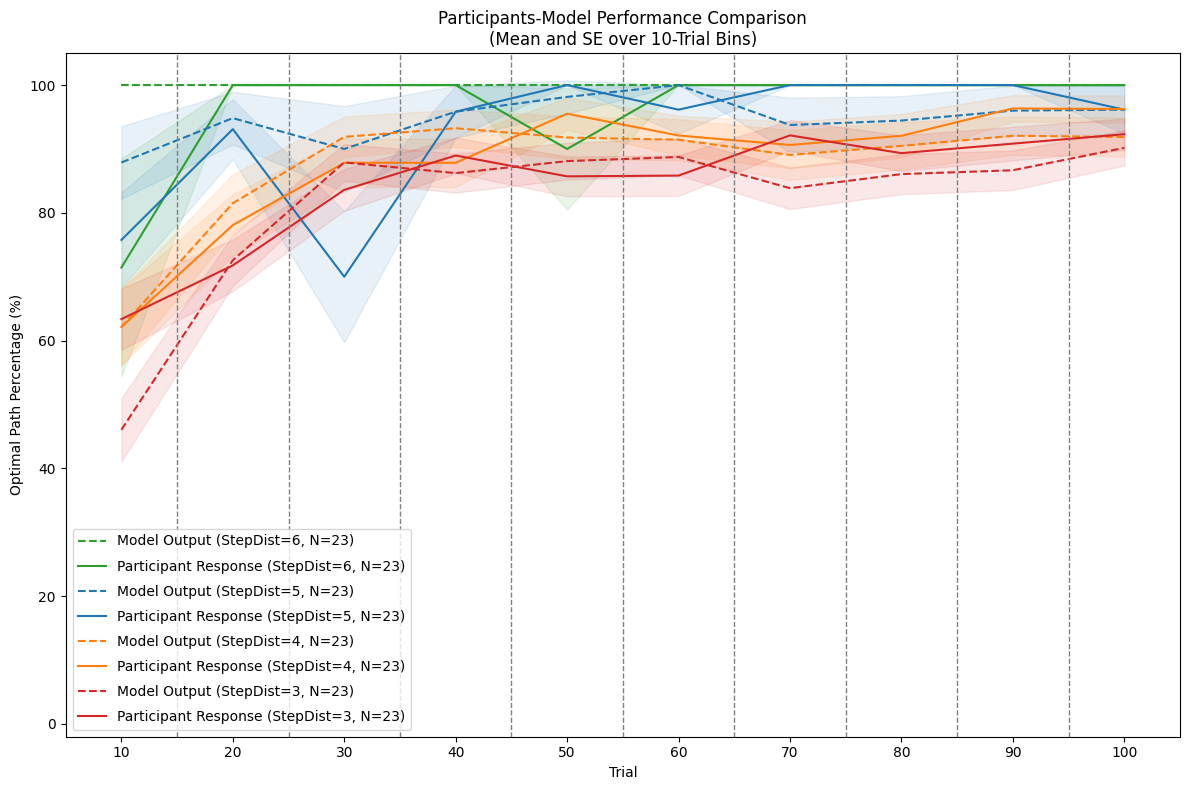

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_mean_se_window(data, response_column, window_size):
    data = data[data['trial'] != 1].copy()  # Exclude the first trial and create a copy
    data.loc[:, 'window'] = (data['trial'] - 1) // window_size
    windowed_data = data.groupby(['window', 'stepDist'])[response_column].agg(['mean', 'count']).reset_index()
    windowed_data['optimal_percentage'] = windowed_data['mean'] * 100
    windowed_data['standard_error'] = np.sqrt(windowed_data['mean'] * (1 - windowed_data['mean']) / windowed_data['count']) * 100
    return windowed_data

def plot_mean_se_window(data_list, labels, window_size, num_files_list):
    plt.figure(figsize=(12, 8))
    colors = ['tab:green', 'tab:blue', 'tab:orange', 'tab:red', 'tab:purple']
    linestyles = ['-', '--']
    markers = ['o', 'x']
    step_dists = sorted(data_list[0]['stepDist'].unique(), reverse=True)  # Sort step distances in descending order
    base_offsets = np.linspace(0, 0, len(data_list))
    step_dist_offsets = np.linspace(0, 0, len(step_dists))  # Add offsets for step distances

    for j, stepDist in enumerate(step_dists):
        color = colors[j % len(colors)]
        step_dist_offset = step_dist_offsets[j]  # Horizontal displacement for each step distance
        for i, data in enumerate(data_list):
            label = labels[i]
            num_files = num_files_list[i]
            linestyle = linestyles[0] if 'Participant Response' in label else linestyles[1]
            marker = markers[0] if 'Participant Response' in label else markers[1]
            offset = base_offsets[i]

            subset_data = data[data['stepDist'] == stepDist]
            
            x_positions = subset_data['window'] * window_size + window_size / 2 + offset + step_dist_offset
            plt.plot(x_positions, subset_data['optimal_percentage'], linestyle=linestyle, color=color, label=f'{label} (StepDist={stepDist}, N={num_files})')
            plt.fill_between(x_positions, 
                             subset_data['optimal_percentage'] - subset_data['standard_error'], 
                             subset_data['optimal_percentage'] + subset_data['standard_error'], 
                             color=color, alpha=0.1)
    
    plt.title(f'Participants-Model Performance Comparison\n(Mean and SE over {window_size}-Trial Bins)')
    plt.xlim(left=0, right=100)
    plt.xlabel('Trial')
    plt.ylabel(f'Optimal Path Percentage (%)')
    plt.ylim(bottom=-2, top=105)
    plt.legend(labelspacing=0.8)

    # Adjust x-axis labels
    max_window = max([data['window'].max() for data in data_list])
    x_ticks = np.arange(0, (max_window + 1) * window_size, window_size)
    x_labels = x_ticks + window_size
    plt.xticks(x_ticks + window_size / 2, x_labels)
    
    # Add vertical lines
    vertical_lines = np.arange(window_size, (max_window * window_size) + 1, window_size)
    for vline in vertical_lines:
        plt.axvline(x=vline, color='gray', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.savefig('mean_se_optimality_percentage_comparison.png')
    plt.show()

def process_folder(folder_path, response_column, window_size):
    num_files = len([filename for filename in os.listdir(folder_path) if filename.endswith('.csv')])

    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])

    mean_se_data = calculate_mean_se_window(all_data, response_column, window_size)

    return mean_se_data, num_files

def average_optimality_over_grids(folder_path, response_column):
    subject_files = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            subject_id = filename.split('_')[0]
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path)
            
            if subject_id not in subject_files:
                subject_files[subject_id] = []
            subject_files[subject_id].append(data)
    
    averaged_data = []
    for subject_id, data_list in subject_files.items():
        combined_data = pd.concat(data_list)
        averaged_optimality = combined_data.groupby(['trial', 'stepDist'])[response_column].mean().reset_index()
        averaged_optimality['subject_id'] = subject_id
        averaged_data.append(averaged_optimality)
    
    averaged_folder_path = folder_path + '_Average_Optimality'
    if not os.path.exists(averaged_folder_path):
        os.makedirs(averaged_folder_path)
    
    for averaged_optimality in averaged_data:
        subject_id = averaged_optimality['subject_id'].iloc[0]
        averaged_optimality.drop(columns=['subject_id'], inplace=True)
        averaged_optimality.to_csv(os.path.join(averaged_folder_path, f'{subject_id}.csv'), index=False)

def process_all_folders_and_plot(folder_paths, response_columns, labels, window_size):
    mean_se_data_list = []
    num_files_list = []
    
    for folder_path, response_column in zip(folder_paths, response_columns):
        if 'ModelOutput' in folder_path:
            average_optimality_over_grids(folder_path, response_column)
            averaged_folder_path = folder_path + '_Average_Optimality'
        else:
            averaged_folder_path = folder_path
        
        mean_se_data, num_files = process_folder(averaged_folder_path, response_column, window_size)
        mean_se_data_list.append(mean_se_data)
        num_files_list.append(num_files)
    
    plot_mean_se_window(mean_se_data_list, labels, window_size, num_files_list)

# Set the folder paths and window size
folder_paths = ['ModelOutput_24_with_options', 'PreprocessedSubjectData']
response_columns = ['optimality', 'optimal_response']

labels = ['Model Output', 'Participant Response']
window_size = 10

# Process all folders and plot the mean and SE over windows
process_all_folders_and_plot(folder_paths, response_columns, labels, window_size)

# Print rows sith StepDist = 6 in CSV grid files
import os
import pandas as pd

folder_path = 'ModelOutput_24_with_options'
response_column = 'optimality'
window_size = 10

num_files = len([filename for filename in os.listdir(folder_path) if filename.endswith('.csv')])
all_data = pd.DataFrame()
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)
        participant_data = pd.read_csv(file_path)
        all_data = pd.concat([all_data, participant_data])

# Print rows with StepDist = 6
#print(all_data[all_data['stepDist'] == 6])


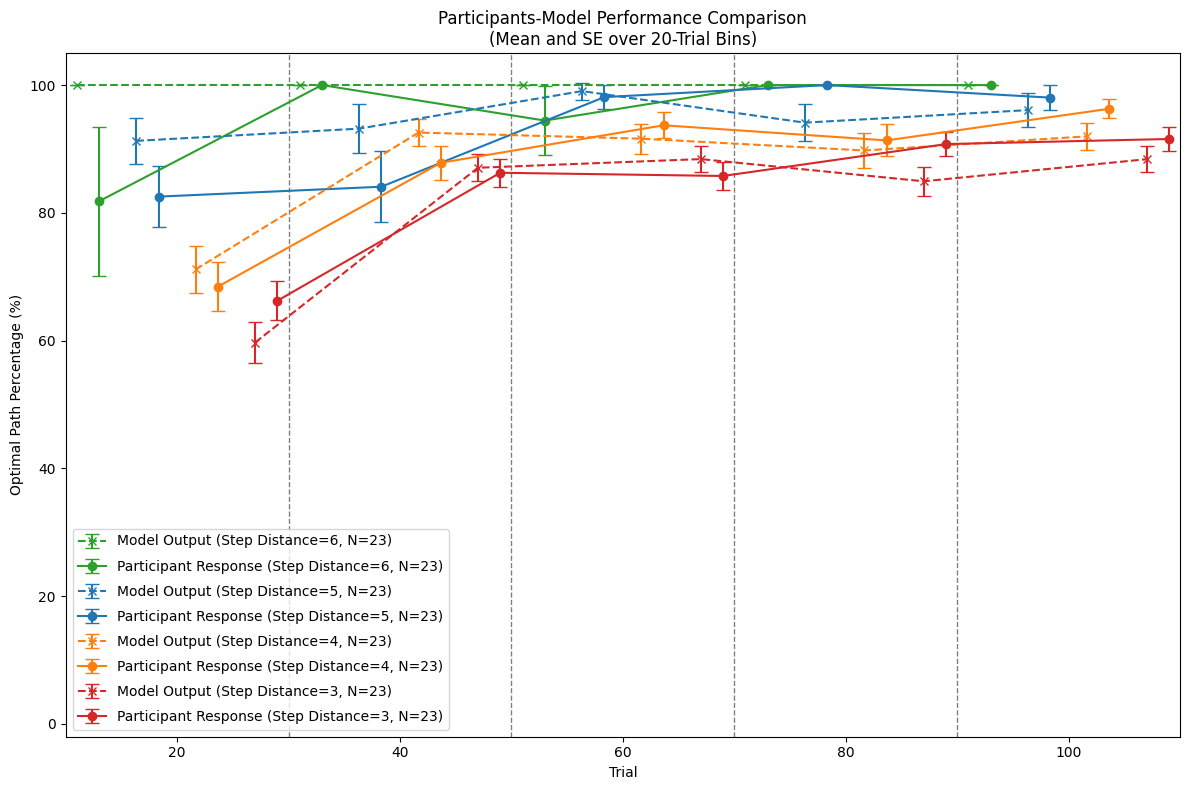

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_mean_se_window(data, response_column, window_size):
    data['window'] = (data['trial'] - 1) // window_size
    windowed_data = data.groupby(['window', 'stepDist'])[response_column].agg(['mean', 'count']).reset_index()
    windowed_data['optimal_percentage'] = windowed_data['mean'] * 100
    windowed_data['standard_error'] = np.sqrt(windowed_data['mean'] * (1 - windowed_data['mean']) / windowed_data['count']) * 100
    return windowed_data

def plot_mean_se_window(data_list, labels, window_size, num_files_list):
    plt.figure(figsize=(12, 8))
    colors = ['tab:green', 'tab:blue', 'tab:orange', 'tab:red', 'tab:purple']
    linestyles = ['-', '--']
    markers = ['o', 'x']
    step_dists = sorted(data_list[0]['stepDist'].unique(), reverse=True)  # Sort step distances in descending order
    base_offsets = np.linspace(-1, 1, len(data_list))
    step_dist_offsets = np.linspace(-8, 8, len(step_dists))  # Add offsets for step distances

    for j, stepDist in enumerate(step_dists):
        color = colors[j % len(colors)]
        step_dist_offset = step_dist_offsets[j]  # Horizontal displacement for each step distance
        for i, data in enumerate(data_list):
            label = labels[i]
            num_files = num_files_list[i]
            linestyle = linestyles[0] if 'Participant Response' in label else linestyles[1]
            marker = markers[0] if 'Participant Response' in label else markers[1]
            offset = base_offsets[i]

            subset_data = data[data['stepDist'] == stepDist]
            
            x_positions = subset_data['window'] * window_size + window_size / 2 + offset + step_dist_offset
            plt.errorbar(x_positions, subset_data['optimal_percentage'], yerr=subset_data['standard_error'],
                         fmt=marker + linestyle, color=color, label=f'{label} (Step Distance={stepDist}, N={num_files})', capsize=5)
    
    plt.title(f'Participants-Model Performance Comparison\n(Mean and SE over {window_size}-Trial Bins)')
    plt.xlim(left=0, right=100)
    plt.xlabel('Trial')
    plt.ylabel(f'Optimal Path Percentage (%)')
    plt.ylim(bottom=-2, top=105)
    plt.legend(labelspacing=0.8)

    # Adjust x-axis labels
    max_window = max([data['window'].max() for data in data_list])
    x_ticks = np.arange(0, (max_window + 1) * window_size, window_size)
    x_labels = x_ticks + window_size
    plt.xticks(x_ticks + window_size / 2, x_labels)
    
    # Add vertical lines
    vertical_lines = np.arange(window_size, (max_window * window_size) + 1, window_size)
    for vline in vertical_lines:
        plt.axvline(x=vline, color='gray', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.savefig('mean_se_optimality_percentage_comparison.png')
    plt.show()

def process_folder(folder_path, response_column, window_size):
    num_files = len([filename for filename in os.listdir(folder_path) if filename.endswith('.csv')])

    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])

    mean_se_data = calculate_mean_se_window(all_data, response_column, window_size)

    return mean_se_data, num_files

def average_optimality_over_grids(folder_path, response_column):
    subject_files = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            subject_id = filename.split('_')[0]
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path)
            
            if subject_id not in subject_files:
                subject_files[subject_id] = []
            subject_files[subject_id].append(data)
    
    averaged_data = []
    for subject_id, data_list in subject_files.items():
        combined_data = pd.concat(data_list)
        averaged_optimality = combined_data.groupby(['trial', 'stepDist'])[response_column].mean().reset_index()
        averaged_optimality['subject_id'] = subject_id
        averaged_data.append(averaged_optimality)
    
    averaged_folder_path = folder_path + '_Average_Optimality'
    if not os.path.exists(averaged_folder_path):
        os.makedirs(averaged_folder_path)
    
    for averaged_optimality in averaged_data:
        subject_id = averaged_optimality['subject_id'].iloc[0]
        averaged_optimality.drop(columns=['subject_id'], inplace=True)
        averaged_optimality.to_csv(os.path.join(averaged_folder_path, f'{subject_id}.csv'), index=False)

def process_all_folders_and_plot(folder_paths, response_columns, labels, window_size):
    mean_se_data_list = []
    num_files_list = []
    
    for folder_path, response_column in zip(folder_paths, response_columns):
        if 'ModelOutput' in folder_path:
            average_optimality_over_grids(folder_path, response_column)
            averaged_folder_path = folder_path + '_Average_Optimality'
        else:
            averaged_folder_path = folder_path
        
        mean_se_data, num_files = process_folder(averaged_folder_path, response_column, window_size)
        mean_se_data_list.append(mean_se_data)
        num_files_list.append(num_files)
    
    plot_mean_se_window(mean_se_data_list, labels, window_size, num_files_list)

# Set the folder paths and window size
folder_paths = ['ModelOutput_24_with_options', 'PreprocessedSubjectData']
response_columns = ['optimality', 'optimal_response']

labels = ['Model Output', 'Participant Response']
window_size = 20

# Process all folders and plot the mean and SE over windows
process_all_folders_and_plot(folder_paths, response_columns, labels, window_size)


break down best fitting line by start-end location pair

Processing file: Subject2.csv
Columns in the file: Index(['trial', 'start', 'end', 'start_type', 'end_type', 'start_end_type',
       'optimality'],
      dtype='object')
Processing file: Subject3.csv
Columns in the file: Index(['trial', 'start', 'end', 'start_type', 'end_type', 'start_end_type',
       'optimality'],
      dtype='object')
Processing file: Subject1.csv
Columns in the file: Index(['trial', 'start', 'end', 'start_type', 'end_type', 'start_end_type',
       'optimality'],
      dtype='object')
Processing file: Subject4.csv
Columns in the file: Index(['trial', 'start', 'end', 'start_type', 'end_type', 'start_end_type',
       'optimality'],
      dtype='object')
Processing file: Subject6.csv
Columns in the file: Index(['trial', 'start', 'end', 'start_type', 'end_type', 'start_end_type',
       'optimality'],
      dtype='object')
Processing file: Subject13.csv
Columns in the file: Index(['trial', 'start', 'end', 'start_type', 'end_type', 'start_end_type',
       'optimalit

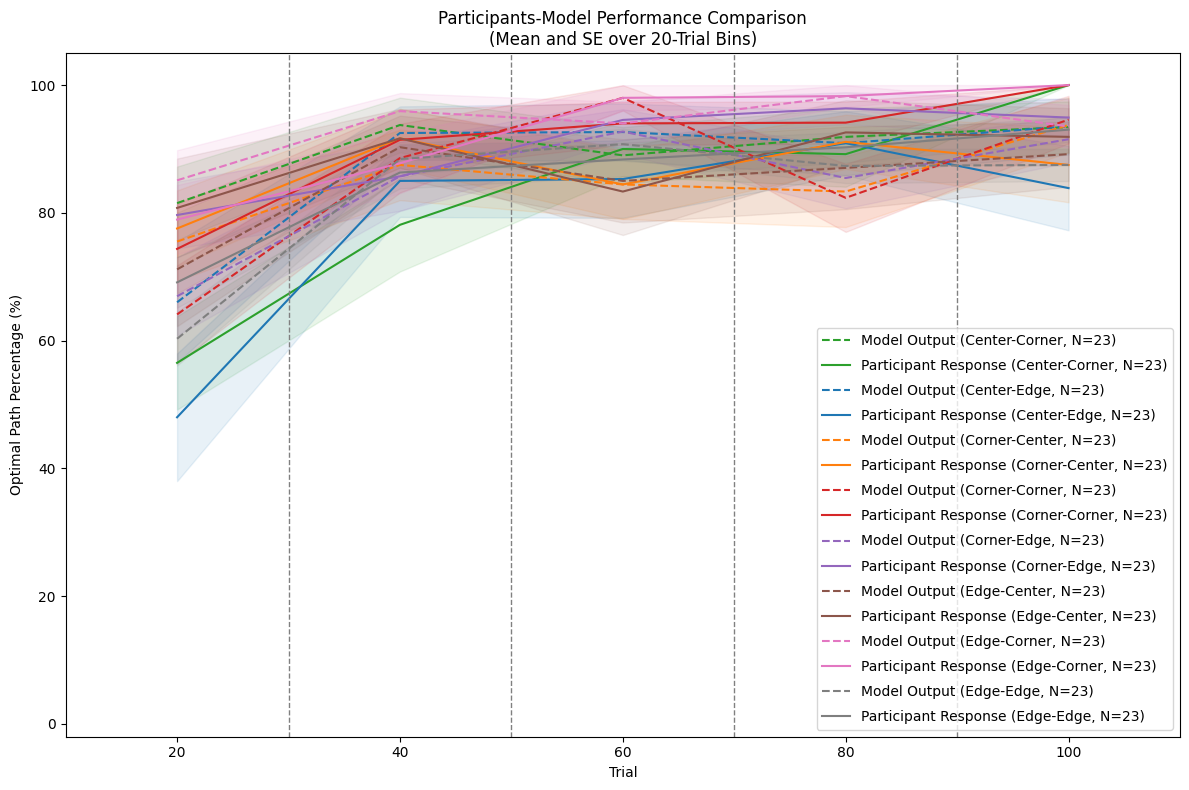

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

def coordinates_by_type(grid_size):
    corners = [(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)]
    centers = [(i, j) for i in range(1, grid_size-1) for j in range(1, grid_size-1)]
    edges = [(i, 0) for i in range(1, grid_size-1)] + [(i, grid_size-1) for i in range(1, grid_size-1)] + [(0, j) for j in range(1, grid_size-1)] + [(grid_size-1, j) for j in range(1, grid_size-1)]
    
    return corners, centers, edges

def start_end_pair_type(start_type, end_type):
    if start_type == 'Corner' and end_type == 'Corner':
        return 'Corner-Corner'
    elif start_type == 'Center' and end_type == 'Center':
        return 'Center-Center'
    elif start_type == 'Edge' and end_type == 'Edge':
        return 'Edge-Edge'
    elif start_type == 'Corner' and end_type == 'Center':
        return 'Corner-Center'
    elif start_type == 'Center' and end_type == 'Corner':
        return 'Center-Corner'
    elif start_type == 'Corner' and end_type == 'Edge':
        return 'Corner-Edge'
    elif start_type == 'Edge' and end_type == 'Corner':
        return 'Edge-Corner'
    elif start_type == 'Center' and end_type == 'Edge':
        return 'Center-Edge'
    elif start_type == 'Edge' and end_type == 'Center':
        return 'Edge-Center'
    else:
        return 'Unknown'

def assign_start_end_type(data, grid_size):
    corners, centers, edges = coordinates_by_type(grid_size)
    
    # Ensure 'start' and 'end' are tuples of integers
    if 'start' not in data.columns or 'end' not in data.columns:
        raise KeyError("'start' and/or 'end' columns are missing in the DataFrame.")
    
    data['start'] = data['start'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else x).apply(tuple)
    data['end'] = data['end'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else x).apply(tuple)
    
    data['start_type'] = data['start'].apply(lambda x: 'Corner' if x in corners else 'Center' if x in centers else 'Edge' if x in edges else 'Unknown')
    data['end_type'] = data['end'].apply(lambda x: 'Corner' if x in corners else 'Center' if x in centers else 'Edge' if x in edges else 'Unknown')
    data['start_end_type'] = data.apply(lambda x: start_end_pair_type(x['start_type'], x['end_type']), axis=1)
    return data

def calculate_mean_se_window(data, response_column, window_size):
    data = data[data['trial'] != 1].copy()  # Exclude the first trial and create a copy
    data.loc[:, 'window'] = (data['trial'] - 1) // window_size
    windowed_data = data.groupby(['window', 'start_end_type'])[response_column].agg(['mean', 'count']).reset_index()
    windowed_data['optimal_percentage'] = windowed_data['mean'] * 100
    windowed_data['standard_error'] = np.sqrt(windowed_data['mean'] * (1 - windowed_data['mean']) / windowed_data['count']) * 100
    return windowed_data

def plot_mean_se_window(data_list, labels, window_size, num_files_list):
    plt.figure(figsize=(12, 8))
    colors = ['tab:green', 'tab:blue', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    linestyles = ['-', '--']
    markers = ['o', 'x']
    start_end_types = sorted(data_list[0]['start_end_type'].unique())  # Sort start_end_type

    for j, start_end_type in enumerate(start_end_types):
        color = colors[j % len(colors)]
        for i, data in enumerate(data_list):
            label = labels[i]
            num_files = num_files_list[i]
            linestyle = linestyles[0] if 'Participant Response' in label else linestyles[1]
            marker = markers[0] if 'Participant Response' in label else markers[1]

            subset_data = data[data['start_end_type'] == start_end_type]
            
            x_positions = subset_data['window'] * window_size + window_size / 2
            plt.plot(x_positions, subset_data['optimal_percentage'], linestyle=linestyle, color=color, label=f'{label} ({start_end_type}, N={num_files})')
            plt.fill_between(x_positions, 
                             subset_data['optimal_percentage'] - subset_data['standard_error'], 
                             subset_data['optimal_percentage'] + subset_data['standard_error'], 
                             color=color, alpha=0.1)
    
    plt.title(f'Participants-Model Performance Comparison\n(Mean and SE over {window_size}-Trial Bins)')
    plt.xlim(left=0, right=100)
    plt.xlabel('Trial')
    plt.ylabel(f'Optimal Path Percentage (%)')
    plt.ylim(bottom=-2, top=105)
    plt.legend(labelspacing=0.8)

    # Adjust x-axis labels
    max_window = max([data['window'].max() for data in data_list])
    x_ticks = np.arange(0, (max_window + 1) * window_size, window_size)
    x_labels = x_ticks + window_size
    plt.xticks(x_ticks + window_size / 2, x_labels)
    
    # Add vertical lines
    vertical_lines = np.arange(window_size, (max_window * window_size) + 1, window_size)
    for vline in vertical_lines:
        plt.axvline(x=vline, color='gray', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.savefig('mean_se_optimality_percentage_comparison.png')
    plt.show()

def process_folder(folder_path, response_column, window_size, grid_size):
    num_files = len([filename for filename in os.listdir(folder_path) if filename.endswith('.csv')])

    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            print(f"Processing file: {filename}")
            print(f"Columns in the file: {participant_data.columns}")
            participant_data = assign_start_end_type(participant_data, grid_size)
            all_data = pd.concat([all_data, participant_data])

    mean_se_data = calculate_mean_se_window(all_data, response_column, window_size)

    return mean_se_data, num_files

def average_optimality_over_grids(folder_path, response_column, grid_size):
    subject_files = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            subject_id = filename.split('_')[0]
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path)
            
            data = assign_start_end_type(data, grid_size)
            
            if subject_id not in subject_files:
                subject_files[subject_id] = []
            subject_files[subject_id].append(data)
    
    averaged_data = []
    for subject_id, data_list in subject_files.items():
        combined_data = pd.concat(data_list)
        averaged_optimality = combined_data.groupby(['trial', 'start', 'end', "start_type", "end_type", 'start_end_type'])[response_column].mean().reset_index()
        averaged_optimality['subject_id'] = subject_id
        averaged_data.append(averaged_optimality)
    
    averaged_folder_path = folder_path + '_Average_Optimality'
    if not os.path.exists(averaged_folder_path):
        os.makedirs(averaged_folder_path)
    
    for averaged_optimality in averaged_data:
        subject_id = averaged_optimality['subject_id'].iloc[0]
        averaged_optimality.drop(columns=['subject_id'], inplace=True)
        averaged_optimality.to_csv(os.path.join(averaged_folder_path, f'{subject_id}.csv'), index=False)

def process_all_folders_and_plot(folder_paths, response_columns, labels, window_size, grid_size):
    mean_se_data_list = []
    num_files_list = []
    
    for folder_path, response_column in zip(folder_paths, response_columns):
        if 'ModelOutput' in folder_path:
            average_optimality_over_grids(folder_path, response_column, grid_size)
            averaged_folder_path = folder_path + '_Average_Optimality'
        else:
            averaged_folder_path = folder_path
        
        mean_se_data, num_files = process_folder(averaged_folder_path, response_column, window_size, grid_size)
        mean_se_data_list.append(mean_se_data)
        num_files_list.append(num_files)
    
    plot_mean_se_window(mean_se_data_list, labels, window_size, num_files_list)

# Set the folder paths and window size
folder_paths = ['ModelOutput_24_with_options', 'PreprocessedSubjectData']
response_columns = ['optimality', 'optimal_response']
labels = ['Model Output', 'Participant Response']
window_size = 20
grid_size = 4

# Process all folders and plot the mean and SE over windows
process_all_folders_and_plot(folder_paths, response_columns, labels, window_size, grid_size)


/Users/leowong/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/leowong/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/leowong/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/leowong/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Mixed-effects model results for model output:
             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   optimality
No. Observations:    1610      Method:               REML      
No. Groups:          23        Scale:                0.0836    
Min. group size:     70        Log-Likelihood:       -295.4849 
Max. group size:     70        Converged:            Yes       
Mean group size:     70.0                                      
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.924    0.018 51.815 0.000  0.889  0.959
start_type[T.Corner] -0.033    0.022 -1.483 0.138 -0.076  0.011
start_type[T.Edge]   -0.027    0.020 -1.318 0.187 -0.067  0.013
Group Var             0.000    0.002                           


Tukey HSD post-hoc results for model output:
Multiple Comparison of 

/var/folders/8m/tvf94f_51v97kgzt4g5hs2g80000gn/T/ipykernel_10129/3199258521.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[response_column] = data_filtered[response_column].astype(int)
/Users/leowong/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


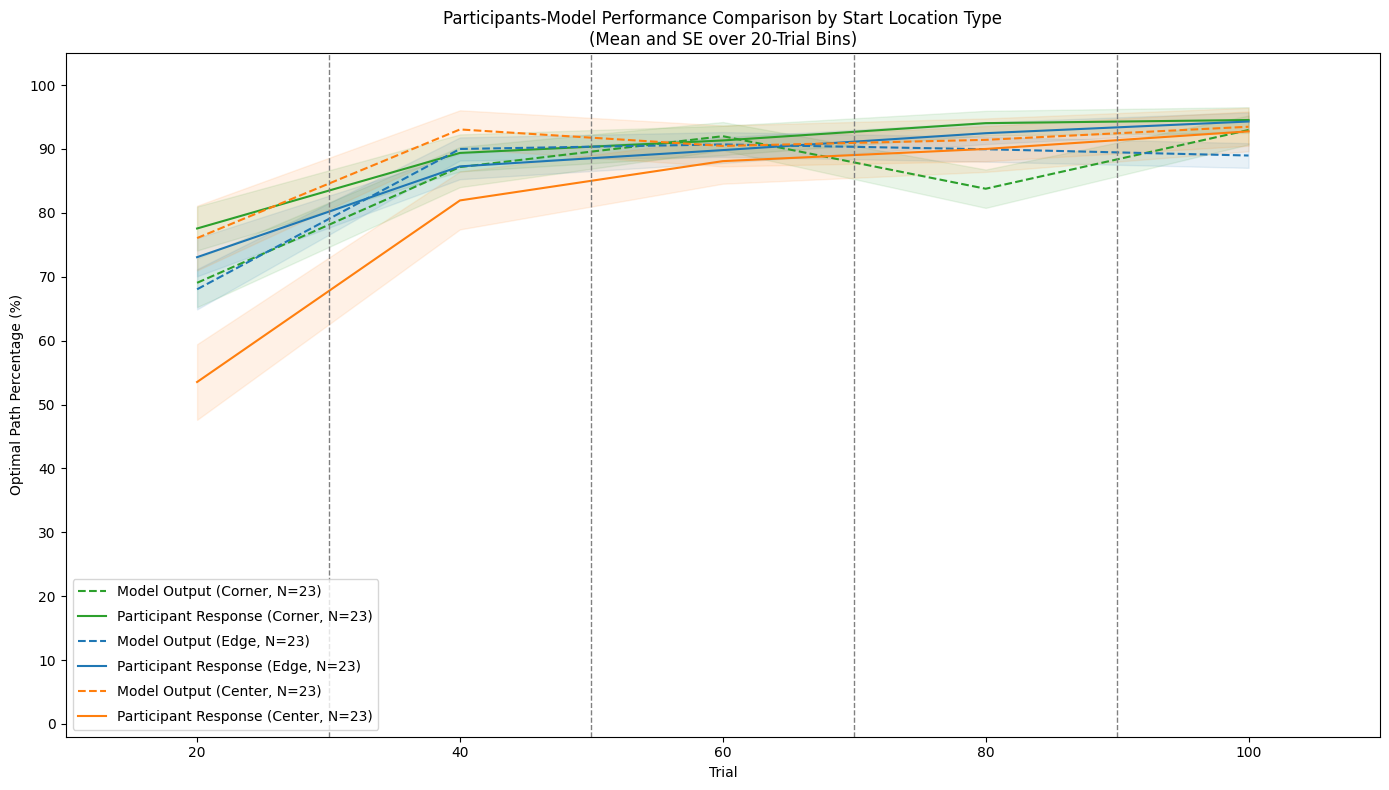

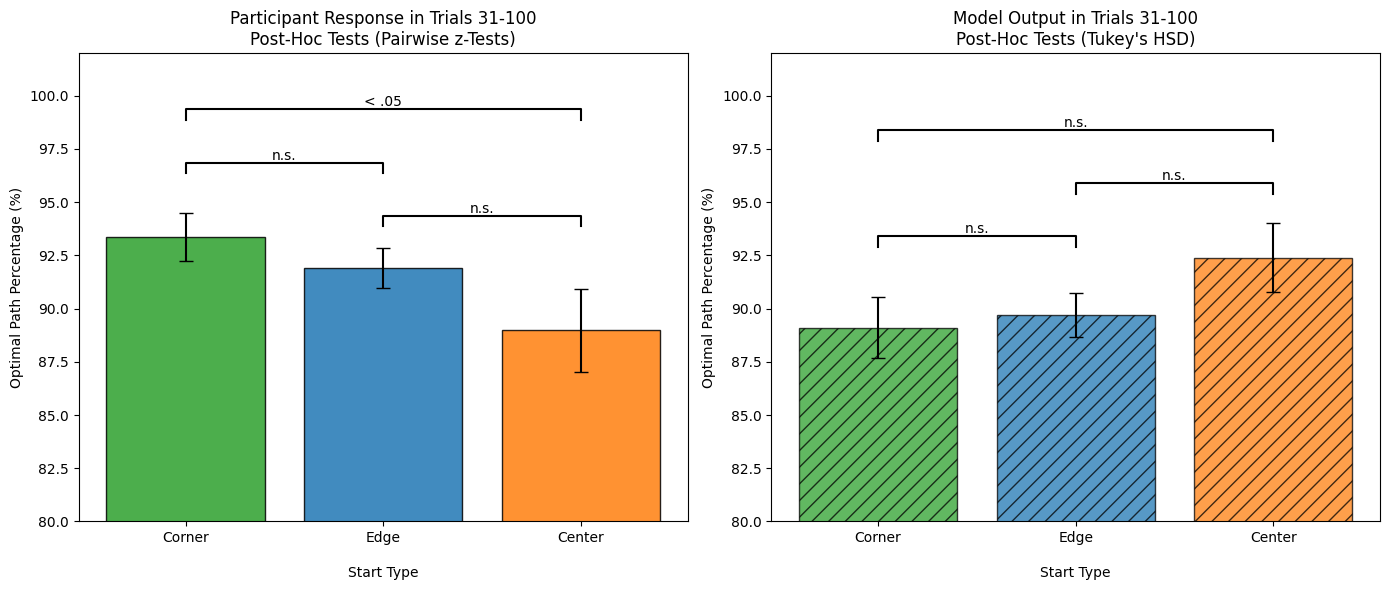

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import statsmodels.stats.multicomp as mc

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations

def coordinates_by_type(grid_size):
    corners = [(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)]
    centers = [(i, j) for i in range(1, grid_size-1) for j in range(1, grid_size-1)]
    edges = [(i, 0) for i in range(1, grid_size-1)] + [(i, grid_size-1) for i in range(1, grid_size-1)] + [(0, j) for j in range(1, grid_size-1)] + [(grid_size-1, j) for j in range(1, grid_size-1)]
    
    return corners, centers, edges

def start_end_pair_type(start_type, end_type):
    if start_type == 'Corner' and end_type == 'Corner':
        return 'Corner-Corner'
    elif start_type == 'Center' and end_type == 'Center':
        return 'Center-Center'
    elif start_type == 'Edge' and end_type == 'Edge':
        return 'Edge-Edge'
    elif start_type == 'Corner' and end_type == 'Center':
        return 'Corner-Center'
    elif start_type == 'Center' and end_type == 'Corner':
        return 'Center-Corner'
    elif start_type == 'Corner' and end_type == 'Edge':
        return 'Corner-Edge'
    elif start_type == 'Edge' and end_type == 'Corner':
        return 'Edge-Corner'
    elif start_type == 'Center' and end_type == 'Edge':
        return 'Center-Edge'
    elif start_type == 'Edge' and end_type == 'Center':
        return 'Edge-Center'
    else:
        return 'Unknown'

def assign_start_end_type(data, grid_size):
    corners, centers, edges = coordinates_by_type(grid_size)
    
    # Ensure 'start' and 'end' are tuples of integers
    if 'start' not in data.columns or 'end' not in data.columns:
        raise KeyError("'start' and/or 'end' columns are missing in the DataFrame.")
    
    data['start'] = data['start'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else x).apply(tuple)
    data['end'] = data['end'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else x).apply(tuple)
    
    data['start_type'] = data['start'].apply(lambda x: 'Corner' if x in corners else 'Center' if x in centers else 'Edge' if x in edges else 'Unknown')
    data['end_type'] = data['end'].apply(lambda x: 'Corner' if x in corners else 'Center' if x in centers else 'Edge' if x in edges else 'Unknown')
    data['start_end_type'] = data.apply(lambda x: start_end_pair_type(x['start_type'], x['end_type']), axis=1)
    
    if 'subject_id' not in data.columns:
        data['subject_id'] = None  # or assign a default value if needed
    
    return data

def calculate_mean_se_window(data, response_column, window_size):
    data = data[data['trial'] != 1].copy()  # Exclude the first trial and create a copy
    data.loc[:, 'window'] = (data['trial'] - 1) // window_size
    windowed_data = data.groupby(['window', 'start_type'])[response_column].agg(['mean', 'count']).reset_index()
    windowed_data['optimal_percentage'] = windowed_data['mean'] * 100
    windowed_data['standard_error'] = np.sqrt(windowed_data['mean'] * (1 - windowed_data['mean']) / windowed_data['count']) * 100
    return windowed_data

def plot_mean_se_window(data_list, labels, window_size, num_files_list, bar_plot_data=None):
    plt.figure(figsize=(14, 8))
    colors = ['tab:green', 'tab:blue', 'tab:orange']
    linestyles = ['-', '--']
    markers = ['o', 'x']
    desired_order = ['Corner', 'Edge', 'Center']  # Desired order for the start types
    start_types = [stype for stype in desired_order if stype in data_list[0]['start_type'].unique()]

    for j, start_type in enumerate(start_types):
        color = colors[j % len(colors)]
        for i, data in enumerate(data_list):
            label = labels[i]
            num_files = num_files_list[i]
            linestyle = linestyles[0] if 'Participant Response' in label else linestyles[1]
            marker = markers[0] if 'Participant Response' in label else markers[1]

            subset_data = data[data['start_type'] == start_type]
            
            x_positions = subset_data['window'] * window_size + window_size / 2
            plt.plot(x_positions, subset_data['optimal_percentage'], linestyle=linestyle, color=color, label=f'{label} ({start_type}, N={num_files})')
            plt.fill_between(x_positions, 
                             subset_data['optimal_percentage'] - subset_data['standard_error'], 
                             subset_data['optimal_percentage'] + subset_data['standard_error'], 
                             color=color, alpha=0.1)
    
    plt.title(f'Participants-Model Performance Comparison by Start Location Type\n(Mean and SE over {window_size}-Trial Bins)')
    plt.xlim(left=0, right=100)
    plt.xlabel('Trial')
    plt.ylabel(f'Optimal Path Percentage (%)')
    plt.ylim(bottom=-2, top=105)
    plt.yticks(np.arange(0, 101, 10))
    plt.legend(labelspacing=0.8)

    # Adjust x-axis labels
    max_window = max([data['window'].max() for data in data_list])
    x_ticks = np.arange(0, (max_window + 1) * window_size, window_size)
    x_labels = x_ticks + window_size
    plt.xticks(x_ticks + window_size / 2, x_labels)
    
    # Add vertical lines
    vertical_lines = np.arange(window_size, (max_window * window_size) + 1, window_size)
    for vline in vertical_lines:
        plt.axvline(x=vline, color='gray', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.savefig('mean_se_optimality_percentage_comparison_by_start_type.png')
    plt.show()

def process_folder(folder_path, response_column, window_size, grid_size):
    num_files = len([filename for filename in os.listdir(folder_path) if filename.endswith('.csv')])

    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            participant_data['subject_id'] = filename.split('_')[0]  # Extract subject_id from filename
            participant_data = assign_start_end_type(participant_data, grid_size)
            all_data = pd.concat([all_data, participant_data])

    mean_se_data = calculate_mean_se_window(all_data, response_column, window_size)
    model_results, participant_results, tukey_results, ztest_results = statistical_analysis(all_data, response_column)

    return mean_se_data, num_files, model_results, participant_results, tukey_results, ztest_results

def average_optimality_over_grids(folder_path, response_column, grid_size):
    subject_files = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            subject_id = filename.split('_')[0]
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path)
            
            data = assign_start_end_type(data, grid_size)
            
            if subject_id not in subject_files:
                subject_files[subject_id] = []
            subject_files[subject_id].append(data)
    
    averaged_data = []
    for subject_id, data_list in subject_files.items():
        combined_data = pd.concat(data_list)
        averaged_optimality = combined_data.groupby(['trial', 'start', 'end', "start_type", "end_type", 'start_end_type'])[response_column].mean().reset_index()
        averaged_optimality['subject_id'] = subject_id
        averaged_data.append(averaged_optimality)
    
    averaged_folder_path = folder_path + '_Average_Optimality'
    if not os.path.exists(averaged_folder_path):
        os.makedirs(averaged_folder_path)
    
    for averaged_optimality in averaged_data:
        subject_id = averaged_optimality['subject_id'].iloc[0]
        averaged_optimality.drop(columns=['subject_id'], inplace=True)
        averaged_optimality.to_csv(os.path.join(averaged_folder_path, f'{subject_id}.csv'), index=False)

def collect_bar_plot_data(model_results, participant_results):
    bar_plot_data = {
        'model': {
            'start_types': model_results['start_type'],
            'means': model_results['mean'],
            'se': model_results['standard_error']
        },
        'participants': {
            'start_types': participant_results['start_type'],
            'means': participant_results['mean'],
            'se': participant_results['standard_error']
        }
    }
    return bar_plot_data

def statistical_analysis(data, response_column):
    # Filter trials 31-100
    data_filtered = data[(data['trial'] >= 31) & (data['trial'] <= 100)]
    
    model_results = {}
    participant_results = {}
    tukey_results = None
    ztest_results = None

    if response_column == 'optimality':
        # Fit a mixed-effects model with random intercepts for subject
        model = smf.mixedlm(f'{response_column} ~ start_type', data_filtered, groups=data_filtered['subject_id'])
        result = model.fit()
        print("\nMixed-effects model results for model output:")
        print(result.summary())

        # Collecting means and SE for bar plot
        mean_se = data_filtered.groupby('start_type')[response_column].agg(['mean', 'count']).reset_index()
        mean_se['standard_error'] = np.sqrt(mean_se['mean'] * (1 - mean_se['mean']) / mean_se['count']) * 100
        mean_se['mean'] = mean_se['mean'] * 100  # Convert mean to percentage
        model_results = mean_se[['start_type', 'mean', 'standard_error']].to_dict(orient='list')

        # Post-hoc pairwise tests using Tukey's HSD
        tukey = pairwise_tukeyhsd(endog=data_filtered[response_column], groups=data_filtered['start_type'], alpha=0.05)
        tukey_results = tukey.summary()
        print("\nTukey HSD post-hoc results for model output:")
        print(tukey_results)
    else:
        # Ensure the response column is numeric
        data_filtered[response_column] = data_filtered[response_column].astype(int)

        # Fit a generalized linear mixed model (GLMM) for logistic regression
        model = smf.mixedlm(f'{response_column} ~ start_type', data_filtered, groups=data_filtered['subject_id'])
        #model = smf.glm(f'{response_column} ~ start_type', data=data_filtered, family=sm.families.Binomial())
        result = model.fit()
        print("\nGLM (Logistic Regression) results for participant responses:")
        print(result.summary()) 

        # Collecting means and SE for bar plot
        mean_se = data_filtered.groupby('start_type')[response_column].agg(['mean', 'count']).reset_index()
        mean_se['standard_error'] = np.sqrt(mean_se['mean'] * (1 - mean_se['mean']) / mean_se['count']) * 100
        mean_se['mean'] = mean_se['mean'] * 100  # Convert mean to percentage
        participant_results = mean_se[['start_type', 'mean', 'standard_error']].to_dict(orient='list')

        # Post-hoc pairwise tests using proportions z-test
        start_type_pairs = list(combinations(data_filtered['start_type'].unique(), 2))
        ztest_results = []
        for pair in start_type_pairs:
            group1 = data_filtered[data_filtered['start_type'] == pair[0]][response_column]
            group2 = data_filtered[data_filtered['start_type'] == pair[1]][response_column]
            count = np.array([group1.sum(), group2.sum()])
            nobs = np.array([group1.count(), group2.count()])
            stat, pval = proportions_ztest(count, nobs)
            ztest_results.append((pair, pval))
        print("\nProportions z-test post-hoc results for participant responses:")
        for result in ztest_results:
            print(f"{result[0]}: p-value = {result[1]}")

    return model_results, participant_results, tukey_results, ztest_results

# Function to determine significance asterisks
def significance_asterisks(pval):
    if pval < 0.05:
        return '< .05'
    else:
        return 'n.s.'

def plot_bar_plots(bar_plot_data, start_types, tukey_results, ztest_results):
    model_data = bar_plot_data['model']
    participant_data = bar_plot_data['participants']
    
    colors = ['tab:green', 'tab:blue', 'tab:orange']
    colors_model = ['green', 'blue', 'orange']
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor='white')  # One row, two columns
    axes = axes.flatten()

    # Add bar plot for model data
    ax_model = axes[1]
    for i, start_type in enumerate(start_types):
        if start_type in model_data['start_types']:
            idx = model_data['start_types'].index(start_type)
            ax_model.bar(start_type, model_data['means'][idx], yerr=model_data['se'][idx], capsize=5, color=colors[i], edgecolor="black", alpha=0.75, hatch='//')
    ax_model.set_title('Model Output in Trials 31-100\nPost-Hoc Tests (Tukey\'s HSD)', fontsize=12)
    ax_model.set_xlabel('Start Type', fontsize=10, labelpad=15)
    ax_model.set_ylabel('Optimal Path Percentage (%)', fontsize=10)
    ax_model.set_ylim(80, 102)
    ax_model.set_xticks(range(len(start_types)))
    ax_model.set_xticklabels(start_types)

    # Add significance lines for Tukey HSD results
    if tukey_results is not None:
        y_offset = {('Center', 'Edge'): 0, ('Edge', 'Center'): 0, ('Center', 'Corner'): 2.5, ('Corner', 'Center'): 2.5, ('Corner', 'Edge'): -2.5, ('Edge', 'Corner'): -2.5}
        for i, row in enumerate(tukey_results.data[1:]):
            group1, group2 = row[0], row[1]
            if group1 in start_types and group2 in start_types:
                x1, x2 = start_types.index(group1), start_types.index(group2)
                y, h, col = max(model_data['means']) + 3 + y_offset.get((group1, group2), 0), 0.5, 'k'
                pval = row[3]
                ax_model.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                ax_model.text((x1 + x2) * .5, y + h, significance_asterisks(pval), ha='center', va='bottom', color=col)

    # Add bar plot for participant data
    ax_participants = axes[0]
    for i, start_type in enumerate(start_types):
        if start_type in participant_data['start_types']:
            idx = participant_data['start_types'].index(start_type)
            ax_participants.bar(start_type, participant_data['means'][idx], yerr=participant_data['se'][idx], capsize=5, color=colors[i], edgecolor='black', alpha=0.85)
    ax_participants.set_title('Participant Response in Trials 31-100\nPost-Hoc Tests (Pairwise z-Tests)', fontsize=12)
    ax_participants.set_xlabel('Start Type', fontsize=10, labelpad=15)
    ax_participants.set_ylabel('Optimal Path Percentage (%)', fontsize=10)
    ax_participants.set_ylim(80, 102)
    ax_participants.set_xticks(range(len(start_types)))
    ax_participants.set_xticklabels(start_types)

    # Add significance lines for proportions z-test results
    if ztest_results is not None:
        y_offset = {('Center', 'Edge'): -2.5, ('Edge', 'Center'): -2.5, ('Center', 'Corner'): 2.5, ('Corner', 'Center'): 2.5, ('Corner', 'Edge'): 0, ('Edge', 'Corner'): 0}
        for result in ztest_results:
            pair, pval = result
            group1, group2 = pair
            if group1 in start_types and group2 in start_types:
                x1, x2 = start_types.index(group1), start_types.index(group2)
                y, h, col = max(participant_data['means']) + 3 + y_offset.get((group1, group2), 0), 0.5, 'k'
                ax_participants.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                ax_participants.text((x1 + x2) * .5, y + h, significance_asterisks(pval), ha='center', va='bottom', color=col)

    plt.tight_layout()
    plt.savefig('model_participant_bar_plots_start_type.png')
    plt.show()

def process_all_folders_and_plot(folder_paths, response_columns, labels, window_size, grid_size):
    mean_se_data_list = []
    num_files_list = []
    model_results = {}
    participant_results = {}
    tukey_results = None
    ztest_results = None
    
    for folder_path, response_column in zip(folder_paths, response_columns):
        if 'ModelOutput' in folder_path:
            average_optimality_over_grids(folder_path, response_column, grid_size)
            averaged_folder_path = folder_path + '_Average_Optimality'
        else:
            averaged_folder_path = folder_path
        
        mean_se_data, num_files, model_res, participant_res, tukey_res, ztest_res = process_folder(averaged_folder_path, response_column, window_size, grid_size)
        mean_se_data_list.append(mean_se_data)
        num_files_list.append(num_files)
        
        if model_res:
            model_results = model_res
        if participant_res:
            participant_results = participant_res
        if tukey_res is not None:
            tukey_results = tukey_res
        if ztest_res is not None:
            ztest_results = ztest_res
    
    # Collect data for bar plots from ANOVA and logistic regression results
    bar_plot_data = collect_bar_plot_data(model_results, participant_results)

    plot_mean_se_window(mean_se_data_list, labels, window_size, num_files_list)

    # Desired order for the start types
    desired_order = ['Corner', 'Edge', 'Center']
    start_types = [stype for stype in desired_order if stype in bar_plot_data['model']['start_types']]

    # Plot bar plots side by side
    plot_bar_plots(bar_plot_data, start_types, tukey_results, ztest_results)

# Set the folder paths and window size
folder_paths = ['ModelOutput_24_with_options', 'PreprocessedSubjectData']
response_columns = ['optimality', 'optimal_response']
labels = ['Model Output', 'Participant Response']
window_size = 20
grid_size = 4

# Process all folders and plot the mean and SE over windows
process_all_folders_and_plot(folder_paths, response_columns, labels, window_size, grid_size)


/Users/leowong/miniconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/leowong/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/leowong/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/leowong/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Mixed-effects model results for model output:
           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  optimality
No. Observations:   1610     Method:              REML      
No. Groups:         23       Scale:               0.0834    
Min. group size:    70       Log-Likelihood:      -293.2467 
Max. group size:    70       Converged:           Yes       
Mean group size:    70.0                                    
------------------------------------------------------------
                   Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.874    0.018 48.223 0.000  0.838  0.910
end_type[T.Corner] 0.053    0.022  2.352 0.019  0.009  0.097
end_type[T.Edge]   0.018    0.021  0.883 0.377 -0.022  0.059
Group Var          0.000    0.002                           


Tukey HSD post-hoc results for model output:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group

/var/folders/8m/tvf94f_51v97kgzt4g5hs2g80000gn/T/ipykernel_10129/1544737918.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered[response_column] = data_filtered[response_column].astype(int)
/Users/leowong/miniconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



GLM (Logistic Regression) results for participant responses:
            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: optimal_response
No. Observations: 1610    Method:             REML            
No. Groups:       23      Scale:              0.0672          
Min. group size:  70      Log-Likelihood:     -144.4182       
Max. group size:  70      Converged:          Yes             
Mean group size:  70.0                                        
--------------------------------------------------------------
                     Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.894    0.024 36.697 0.000  0.846  0.942
end_type[T.Corner]   0.054    0.020  2.696 0.007  0.015  0.094
end_type[T.Edge]     0.016    0.019  0.847 0.397 -0.021  0.052
Group Var            0.008    0.010                           


Proportions z-test post-hoc results for participant responses:
('Ed

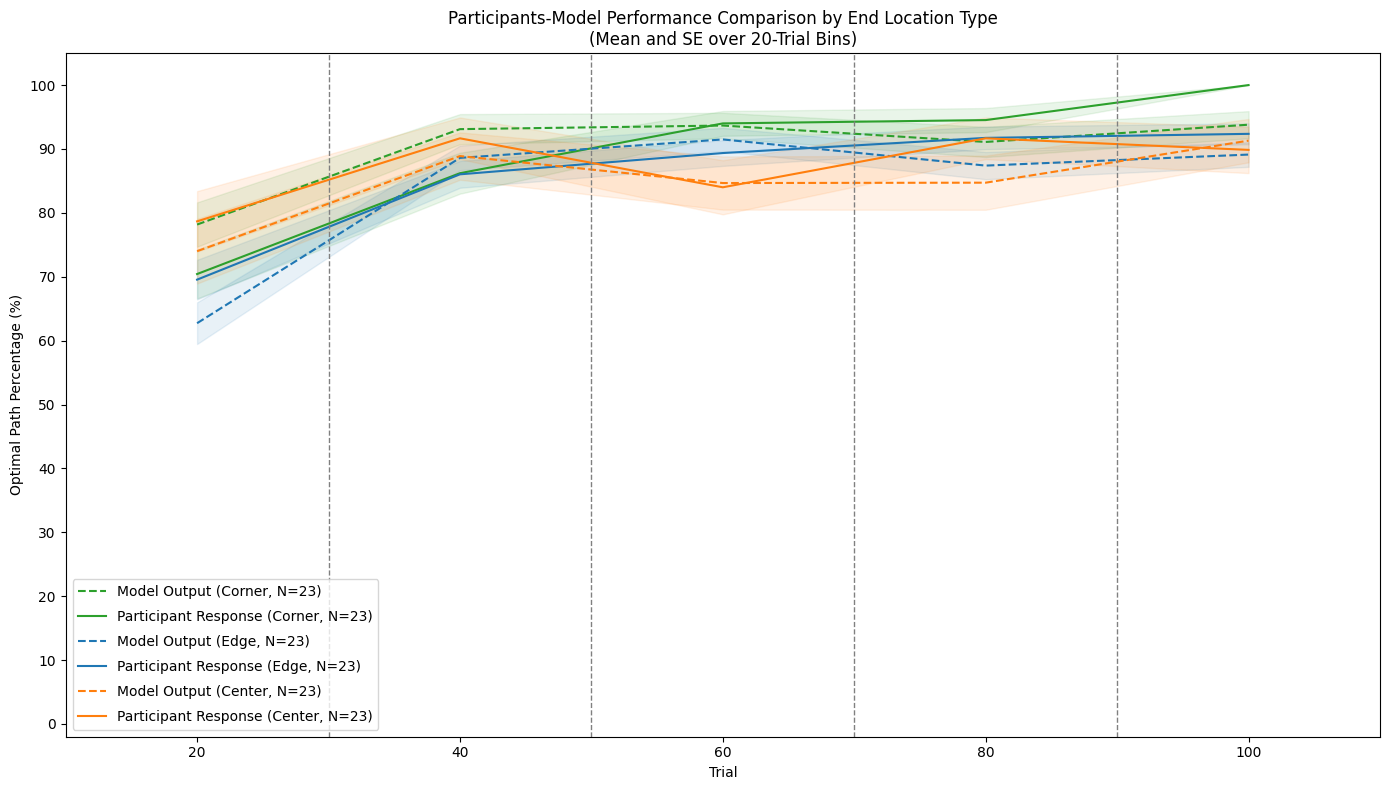

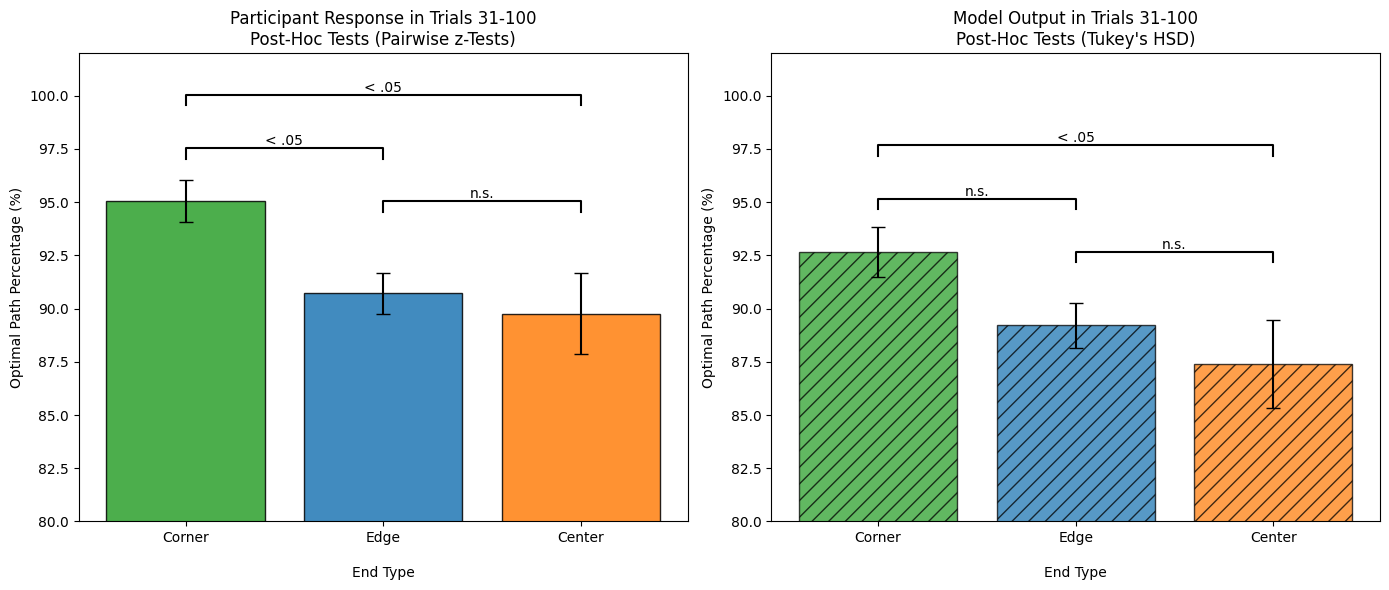

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations

def coordinates_by_type(grid_size):
    corners = [(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)]
    centers = [(i, j) for i in range(1, grid_size-1) for j in range(1, grid_size-1)]
    edges = [(i, 0) for i in range(1, grid_size-1)] + [(i, grid_size-1) for i in range(1, grid_size-1)] + [(0, j) for j in range(1, grid_size-1)] + [(grid_size-1, j) for j in range(1, grid_size-1)]
    
    return corners, centers, edges

def start_end_pair_type(start_type, end_type):
    if start_type == 'Corner' and end_type == 'Corner':
        return 'Corner-Corner'
    elif start_type == 'Center' and end_type == 'Center':
        return 'Center-Center'
    elif start_type == 'Edge' and end_type == 'Edge':
        return 'Edge-Edge'
    elif start_type == 'Corner' and end_type == 'Center':
        return 'Corner-Center'
    elif start_type == 'Center' and end_type == 'Corner':
        return 'Center-Corner'
    elif start_type == 'Corner' and end_type == 'Edge':
        return 'Corner-Edge'
    elif start_type == 'Edge' and end_type == 'Corner':
        return 'Edge-Corner'
    elif start_type == 'Center' and end_type == 'Edge':
        return 'Center-Edge'
    elif start_type == 'Edge' and end_type == 'Center':
        return 'Edge-Center'
    else:
        return 'Unknown'

def assign_start_end_type(data, grid_size):
    corners, centers, edges = coordinates_by_type(grid_size)
    
    # Ensure 'start' and 'end' are tuples of integers
    if 'start' not in data.columns or 'end' not in data.columns:
        raise KeyError("'start' and/or 'end' columns are missing in the DataFrame.")
    
    data['start'] = data['start'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else x).apply(tuple)
    data['end'] = data['end'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else x).apply(tuple)
    
    data['start_type'] = data['start'].apply(lambda x: 'Corner' if x in corners else 'Center' if x in centers else 'Edge' if x in edges else 'Unknown')
    data['end_type'] = data['end'].apply(lambda x: 'Corner' if x in corners else 'Center' if x in centers else 'Edge' if x in edges else 'Unknown')
    data['start_end_type'] = data.apply(lambda x: start_end_pair_type(x['start_type'], x['end_type']), axis=1)
    
    if 'subject_id' not in data.columns:
        data['subject_id'] = None  # or assign a default value if needed
    
    return data

def calculate_mean_se_window(data, response_column, window_size):
    data = data[data['trial'] != 1].copy()  # Exclude the first trial and create a copy
    data.loc[:, 'window'] = (data['trial'] - 1) // window_size
    windowed_data = data.groupby(['window', 'end_type'])[response_column].agg(['mean', 'count']).reset_index()
    windowed_data['optimal_percentage'] = windowed_data['mean'] * 100
    windowed_data['standard_error'] = np.sqrt(windowed_data['mean'] * (1 - windowed_data['mean']) / windowed_data['count']) * 100
    return windowed_data

def plot_mean_se_window(data_list, labels, window_size, num_files_list, bar_plot_data=None):
    plt.figure(figsize=(14, 8))
    colors = ['tab:green', 'tab:blue', 'tab:orange']
    linestyles = ['-', '--']
    markers = ['o', 'x']
    desired_order = ['Corner', 'Edge', 'Center']  # Desired order for the start types
    end_types = [etype for etype in desired_order if etype in data_list[0]['end_type'].unique()]

    for j, end_type in enumerate(end_types):
        color = colors[j % len(colors)]
        for i, data in enumerate(data_list):
            label = labels[i]
            num_files = num_files_list[i]
            linestyle = linestyles[0] if 'Participant Response' in label else linestyles[1]
            marker = markers[0] if 'Participant Response' in label else markers[1]

            subset_data = data[data['end_type'] == end_type]
            
            x_positions = subset_data['window'] * window_size + window_size / 2
            plt.plot(x_positions, subset_data['optimal_percentage'], linestyle=linestyle, color=color, label=f'{label} ({end_type}, N={num_files})')
            plt.fill_between(x_positions, 
                             subset_data['optimal_percentage'] - subset_data['standard_error'], 
                             subset_data['optimal_percentage'] + subset_data['standard_error'], 
                             color=color, alpha=0.1)
    
    plt.title(f'Participants-Model Performance Comparison by End Location Type\n(Mean and SE over {window_size}-Trial Bins)')
    plt.xlim(left=0, right=100)
    plt.xlabel('Trial')
    plt.ylabel(f'Optimal Path Percentage (%)')
    plt.ylim(bottom=-2, top=105)
    plt.yticks(np.arange(0, 101, 10))
    plt.legend(labelspacing=0.8)

    # Adjust x-axis labels
    max_window = max([data['window'].max() for data in data_list])
    x_ticks = np.arange(0, (max_window + 1) * window_size, window_size)
    x_labels = x_ticks + window_size
    plt.xticks(x_ticks + window_size / 2, x_labels)
    
    # Add vertical lines
    vertical_lines = np.arange(window_size, (max_window * window_size) + 1, window_size)
    for vline in vertical_lines:
        plt.axvline(x=vline, color='gray', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.savefig('mean_se_optimality_percentage_comparison_by_end_type.png')
    plt.show()

def process_folder(folder_path, response_column, window_size, grid_size):
    num_files = len([filename for filename in os.listdir(folder_path) if filename.endswith('.csv')])

    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            participant_data['subject_id'] = filename.split('_')[0]  # Extract subject_id from filename
            participant_data = assign_start_end_type(participant_data, grid_size)
            all_data = pd.concat([all_data, participant_data])

    mean_se_data = calculate_mean_se_window(all_data, response_column, window_size)
    model_results, participant_results, tukey_results, ztest_results = statistical_analysis(all_data, response_column)

    return mean_se_data, num_files, model_results, participant_results, tukey_results, ztest_results

def average_optimality_over_grids(folder_path, response_column, grid_size):
    subject_files = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            subject_id = filename.split('_')[0]
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path)
            
            data = assign_start_end_type(data, grid_size)
            
            if subject_id not in subject_files:
                subject_files[subject_id] = []
            subject_files[subject_id].append(data)
    
    averaged_data = []
    for subject_id, data_list in subject_files.items():
        combined_data = pd.concat(data_list)
        averaged_optimality = combined_data.groupby(['trial', 'start', 'end', "start_type", "end_type", 'start_end_type'])[response_column].mean().reset_index()
        averaged_optimality['subject_id'] = subject_id
        averaged_data.append(averaged_optimality)
    
    averaged_folder_path = folder_path + '_Average_Optimality'
    if not os.path.exists(averaged_folder_path):
        os.makedirs(averaged_folder_path)
    
    for averaged_optimality in averaged_data:
        subject_id = averaged_optimality['subject_id'].iloc[0]
        averaged_optimality.drop(columns=['subject_id'], inplace=True)
        averaged_optimality.to_csv(os.path.join(averaged_folder_path, f'{subject_id}.csv'), index=False)

def collect_bar_plot_data(model_results, participant_results):
    bar_plot_data = {
        'model': {
            'end_types': model_results['end_type'],
            'means': model_results['mean'],
            'se': model_results['standard_error']
        },
        'participants': {
            'end_types': participant_results['end_type'],
            'means': participant_results['mean'],
            'se': participant_results['standard_error']
        }
    }
    return bar_plot_data

def statistical_analysis(data, response_column):
    # Filter trials 21-100
    data_filtered = data[(data['trial'] >= 31) & (data['trial'] <= 100)]
    
    model_results = {}
    participant_results = {}
    tukey_results = None
    ztest_results = None

    if response_column == 'optimality':
        # Fit a mixed-effects model with random intercepts for subject
        model = smf.mixedlm(f'{response_column} ~ end_type', data_filtered, groups=data_filtered['subject_id'])
        result = model.fit()
        print("\nMixed-effects model results for model output:")
        print(result.summary())

        # Collecting means and SE for bar plot
        mean_se = data_filtered.groupby('end_type')[response_column].agg(['mean', 'count']).reset_index()
        mean_se['standard_error'] = np.sqrt(mean_se['mean'] * (1 - mean_se['mean']) / mean_se['count']) * 100
        mean_se['mean'] = mean_se['mean'] * 100  # Convert mean to percentage
        model_results = mean_se[['end_type', 'mean', 'standard_error']].to_dict(orient='list')

        # Post-hoc pairwise tests using Tukey's HSD
        tukey = pairwise_tukeyhsd(endog=data_filtered[response_column], groups=data_filtered['end_type'], alpha=0.05)
        tukey_results = tukey.summary()
        print("\nTukey HSD post-hoc results for model output:")
        print(tukey_results)
    else:
        # Ensure the response column is numeric
        data_filtered[response_column] = data_filtered[response_column].astype(int)

        # Fit a generalized linear mixed model (GLMM) for logistic regression
        model = smf.mixedlm(f'{response_column} ~ end_type', data_filtered, groups=data_filtered['subject_id'])
        result = model.fit()
        print("\nGLM (Logistic Regression) results for participant responses:")
        print(result.summary())

        # Collecting means and SE for bar plot
        mean_se = data_filtered.groupby('end_type')[response_column].agg(['mean', 'count']).reset_index()
        mean_se['standard_error'] = np.sqrt(mean_se['mean'] * (1 - mean_se['mean']) / mean_se['count']) * 100
        mean_se['mean'] = mean_se['mean'] * 100  # Convert mean to percentage
        participant_results = mean_se[['end_type', 'mean', 'standard_error']].to_dict(orient='list')

        # Post-hoc pairwise tests using proportions z-test
        end_type_pairs = list(combinations(data_filtered['end_type'].unique(), 2))
        ztest_results = []
        for pair in end_type_pairs:
            group1 = data_filtered[data_filtered['end_type'] == pair[0]][response_column]
            group2 = data_filtered[data_filtered['end_type'] == pair[1]][response_column]
            count = np.array([group1.sum(), group2.sum()])
            nobs = np.array([group1.count(), group2.count()])
            stat, pval = proportions_ztest(count, nobs)
            ztest_results.append((pair, pval))
        print("\nProportions z-test post-hoc results for participant responses:")
        for result in ztest_results:
            print(f"{result[0]}: p-value = {result[1]}")

    return model_results, participant_results, tukey_results, ztest_results

# Function to determine significance asterisks
def significance_asterisks(pval):
    if pval < 0.05:
        return '< .05'
    else:
        return 'n.s.'

def plot_bar_plots(bar_plot_data, end_types, tukey_results, ztest_results):
    model_data = bar_plot_data['model']
    participant_data = bar_plot_data['participants']
    
    colors = ['tab:green', 'tab:blue', 'tab:orange']
    colors_model = ['green', 'blue', 'orange']
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor='white')  # One row, two columns
    axes = axes.flatten()

    # Add bar plot for model data
    ax_model = axes[1]
    for i, end_type in enumerate(end_types):
        if end_type in model_data['end_types']:
            idx = model_data['end_types'].index(end_type)
            ax_model.bar(end_type, model_data['means'][idx], yerr=model_data['se'][idx], capsize=5, color=colors[i], edgecolor="black", alpha=0.75, hatch='//')
    ax_model.set_title('Model Output in Trials 31-100\nPost-Hoc Tests (Tukey\'s HSD)', fontsize=12)
    ax_model.set_xlabel('End Type', fontsize=10, labelpad=15)
    ax_model.set_ylabel('Optimal Path Percentage (%)', fontsize=10)
    ax_model.set_ylim(80, 102)
    ax_model.set_xticks(range(len(end_types)))
    ax_model.set_xticklabels(end_types)

    # Add significance lines for Tukey HSD results
    if tukey_results is not None:
        y_offset = {('Center', 'Edge'): -2.5, ('Edge', 'Center'): -2.5, ('Center', 'Corner'): 2.5, ('Corner', 'Center'): 2.5, ('Corner', 'Edge'): 0, ('Edge', 'Corner'): 0}
        for i, row in enumerate(tukey_results.data[1:]):
            group1, group2 = row[0], row[1]
            if group1 in end_types and group2 in end_types:
                x1, x2 = end_types.index(group1), end_types.index(group2)
                y, h, col = max(model_data['means']) + 2 + y_offset.get((group1, group2), 0), 0.5, 'k'
                pval = row[3]
                ax_model.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                ax_model.text((x1 + x2) * .5, y + h, significance_asterisks(pval), ha='center', va='bottom', color=col)

    # Add bar plot for participant data
    ax_participants = axes[0]
    for i, end_type in enumerate(end_types):
        if end_type in participant_data['end_types']:
            idx = participant_data['end_types'].index(end_type)
            ax_participants.bar(end_type, participant_data['means'][idx], yerr=participant_data['se'][idx], capsize=5, color=colors[i], edgecolor='black', alpha=0.85)
    ax_participants.set_title('Participant Response in Trials 31-100\nPost-Hoc Tests (Pairwise z-Tests)', fontsize=12)
    ax_participants.set_xlabel('End Type', fontsize=10, labelpad=15)
    ax_participants.set_ylabel('Optimal Path Percentage (%)', fontsize=10)
    ax_participants.set_ylim(80, 102)
    ax_participants.set_xticks(range(len(end_types)))
    ax_participants.set_xticklabels(end_types)

    # Add significance lines for proportions z-test results
    if ztest_results is not None:
        y_offset = {('Center', 'Edge'): -2.5, ('Edge', 'Center'): -2.5, ('Center', 'Corner'): 2.5, ('Corner', 'Center'): 2.5, ('Corner', 'Edge'): 0, ('Edge', 'Corner'): 0}
        for result in ztest_results:
            pair, pval = result
            group1, group2 = pair
            if group1 in end_types and group2 in end_types:
                x1, x2 = end_types.index(group1), end_types.index(group2)
                y, h, col = max(participant_data['means']) + 2 + y_offset.get((group1, group2), 0), 0.5, 'k'
                ax_participants.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                ax_participants.text((x1 + x2) * .5, y + h, significance_asterisks(pval), ha='center', va='bottom', color=col)

    plt.tight_layout()
    plt.savefig('model_participant_bar_plots_end_type.png')
    plt.show()

def process_all_folders_and_plot(folder_paths, response_columns, labels, window_size, grid_size):
    mean_se_data_list = []
    num_files_list = []
    model_results = {}
    participant_results = {}
    tukey_results = None
    ztest_results = None
    
    for folder_path, response_column in zip(folder_paths, response_columns):
        if 'ModelOutput' in folder_path:
            average_optimality_over_grids(folder_path, response_column, grid_size)
            averaged_folder_path = folder_path + '_Average_Optimality'
        else:
            averaged_folder_path = folder_path
        
        mean_se_data, num_files, model_res, participant_res, tukey_res, ztest_res = process_folder(averaged_folder_path, response_column, window_size, grid_size)
        mean_se_data_list.append(mean_se_data)
        num_files_list.append(num_files)
        
        if model_res:
            model_results = model_res
        if participant_res:
            participant_results = participant_res
        if tukey_res is not None:
            tukey_results = tukey_res
        if ztest_res is not None:
            ztest_results = ztest_res
    
    # Collect data for bar plots from ANOVA and logistic regression results
    bar_plot_data = collect_bar_plot_data(model_results, participant_results)

    plot_mean_se_window(mean_se_data_list, labels, window_size, num_files_list)

    # Desired order for the end types
    desired_order = ['Corner', 'Edge', 'Center']
    end_types = [etype for etype in desired_order if etype in bar_plot_data['model']['end_types']]

    # Plot bar plots side by side
    plot_bar_plots(bar_plot_data, end_types, tukey_results, ztest_results)

# Set the folder paths and window size
folder_paths = ['ModelOutput_24_with_options', 'PreprocessedSubjectData']
response_columns = ['optimality', 'optimal_response']
labels = ['Model Output', 'Participant Response']
window_size = 20
grid_size = 4

# Process all folders and plot the mean and SE over windows
process_all_folders_and_plot(folder_paths, response_columns, labels, window_size, grid_size)


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import statsmodels.stats.multicomp as mc

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import proportions_ztest
from itertools import combinations

def coordinates_by_type(grid_size):
    corners = [(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)]
    centers = [(i, j) for i in range(1, grid_size-1) for j in range(1, grid_size-1)]
    edges = [(i, 0) for i in range(1, grid_size-1)] + [(i, grid_size-1) for i in range(1, grid_size-1)] + [(0, j) for j in range(1, grid_size-1)] + [(grid_size-1, j) for j in range(1, grid_size-1)]
    
    return corners, centers, edges

def start_end_pair_type(start_type, end_type):
    if start_type == 'Corner' and end_type == 'Corner':
        return 'Corner-Corner'
    elif start_type == 'Center' and end_type == 'Center':
        return 'Center-Center'
    elif start_type == 'Edge' and end_type == 'Edge':
        return 'Edge-Edge'
    elif start_type == 'Corner' and end_type == 'Center':
        return 'Corner-Center'
    elif start_type == 'Center' and end_type == 'Corner':
        return 'Center-Corner'
    elif start_type == 'Corner' and end_type == 'Edge':
        return 'Corner-Edge'
    elif start_type == 'Edge' and end_type == 'Corner':
        return 'Edge-Corner'
    elif start_type == 'Center' and end_type == 'Edge':
        return 'Center-Edge'
    elif start_type == 'Edge' and end_type == 'Center':
        return 'Edge-Center'
    else:
        return 'Unknown'

def assign_start_end_type(data, grid_size):
    corners, centers, edges = coordinates_by_type(grid_size)
    
    # Ensure 'start' and 'end' are tuples of integers
    if 'start' not in data.columns or 'end' not in data.columns:
        raise KeyError("'start' and/or 'end' columns are missing in the DataFrame.")
    
    data['start'] = data['start'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else x).apply(tuple)
    data['end'] = data['end'].apply(lambda x: ast.literal_eval(str(x)) if isinstance(x, str) else x).apply(tuple)
    
    data['start_type'] = data['start'].apply(lambda x: 'Corner' if x in corners else 'Center' if x in centers else 'Edge' if x in edges else 'Unknown')
    data['end_type'] = data['end'].apply(lambda x: 'Corner' if x in corners else 'Center' if x in centers else 'Edge' if x in edges else 'Unknown')
    data['start_end_type'] = data.apply(lambda x: start_end_pair_type(x['start_type'], x['end_type']), axis=1)
    
    if 'subject_id' not in data.columns:
        data['subject_id'] = None  # or assign a default value if needed
    
    return data

def calculate_mean_se_window(data, response_column, window_size):
    data = data[data['trial'] != 1].copy()  # Exclude the first trial and create a copy
    data.loc[:, 'window'] = (data['trial'] - 1) // window_size
    windowed_data = data.groupby(['window', 'start_type'])[response_column].agg(['mean', 'count']).reset_index()
    windowed_data['optimal_percentage'] = windowed_data['mean'] * 100
    windowed_data['standard_error'] = np.sqrt(windowed_data['mean'] * (1 - windowed_data['mean']) / windowed_data['count']) * 100
    return windowed_data

def plot_mean_se_window(data_list, labels, window_size, num_files_list, bar_plot_data=None):
    plt.figure(figsize=(14, 8))
    colors = ['tab:green', 'tab:blue', 'tab:orange']
    linestyles = ['-', '--']
    markers = ['o', 'x']
    desired_order = ['Corner', 'Edge', 'Center']  # Desired order for the start types
    start_types = [stype for stype in desired_order if stype in data_list[0]['start_type'].unique()]

    for j, start_type in enumerate(start_types):
        color = colors[j % len(colors)]
        for i, data in enumerate(data_list):
            label = labels[i]
            num_files = num_files_list[i]
            linestyle = linestyles[0] if 'Participant Response' in label else linestyles[1]
            marker = markers[0] if 'Participant Response' in label else markers[1]

            subset_data = data[data['start_type'] == start_type]
            
            x_positions = subset_data['window'] * window_size + window_size / 2
            plt.plot(x_positions, subset_data['optimal_percentage'], linestyle=linestyle, color=color, label=f'{label} ({start_type}, N={num_files})')
            plt.fill_between(x_positions, 
                             subset_data['optimal_percentage'] - subset_data['standard_error'], 
                             subset_data['optimal_percentage'] + subset_data['standard_error'], 
                             color=color, alpha=0.1)
    
    plt.title(f'Participants-Model Performance Comparison by Start Location Type\n(Mean and SE over {window_size}-Trial Bins)')
    plt.xlim(left=0, right=100)
    plt.xlabel('Trial')
    plt.ylabel(f'Optimal Path Percentage (%)')
    plt.ylim(bottom=-2, top=105)
    plt.yticks(np.arange(0, 101, 10))
    plt.legend(labelspacing=0.8)

    # Adjust x-axis labels
    max_window = max([data['window'].max() for data in data_list])
    x_ticks = np.arange(0, (max_window + 1) * window_size, window_size)
    x_labels = x_ticks + window_size
    plt.xticks(x_ticks + window_size / 2, x_labels)
    
    # Add vertical lines
    vertical_lines = np.arange(window_size, (max_window * window_size) + 1, window_size)
    for vline in vertical_lines:
        plt.axvline(x=vline, color='gray', linestyle='--', linewidth=1)

    plt.tight_layout()
    plt.savefig('mean_se_optimality_percentage_comparison_by_start_type.png')
    plt.show()

def process_folder(folder_path, response_column, window_size, grid_size):
    num_files = len([filename for filename in os.listdir(folder_path) if filename.endswith('.csv')])

    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            participant_data['subject_id'] = filename.split('_')[0]  # Extract subject_id from filename
            participant_data = assign_start_end_type(participant_data, grid_size)
            all_data = pd.concat([all_data, participant_data])

    mean_se_data = calculate_mean_se_window(all_data, response_column, window_size)
    model_results, participant_results, tukey_results, ztest_results = statistical_analysis(all_data, response_column)

    return mean_se_data, num_files, model_results, participant_results, tukey_results, ztest_results

def average_optimality_over_grids(folder_path, response_column, grid_size):
    subject_files = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            subject_id = filename.split('_')[0]
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path)
            
            data = assign_start_end_type(data, grid_size)
            
            if subject_id not in subject_files:
                subject_files[subject_id] = []
            subject_files[subject_id].append(data)
    
    averaged_data = []
    for subject_id, data_list in subject_files.items():
        combined_data = pd.concat(data_list)
        averaged_optimality = combined_data.groupby(['trial', 'start', 'end', "start_type", "end_type", 'start_end_type'])[response_column].mean().reset_index()
        averaged_optimality['subject_id'] = subject_id
        averaged_data.append(averaged_optimality)
    
    averaged_folder_path = folder_path + '_Average_Optimality'
    if not os.path.exists(averaged_folder_path):
        os.makedirs(averaged_folder_path)
    
    for averaged_optimality in averaged_data:
        subject_id = averaged_optimality['subject_id'].iloc[0]
        averaged_optimality.drop(columns=['subject_id'], inplace=True)
        averaged_optimality.to_csv(os.path.join(averaged_folder_path, f'{subject_id}.csv'), index=False)

def collect_bar_plot_data(model_results, participant_results):
    bar_plot_data = {
        'model': {
            'start_types': model_results['start_type'],
            'means': model_results['mean'],
            'se': model_results['standard_error']
        },
        'participants': {
            'start_types': participant_results['start_type'],
            'means': participant_results['mean'],
            'se': participant_results['standard_error']
        }
    }
    return bar_plot_data

def statistical_analysis(data, response_column):
    # Filter trials 31-100
    data_filtered = data[(data['trial'] >= 31) & (data['trial'] <= 100)]
    
    model_results = {}
    participant_results = {}
    tukey_results = None
    ztest_results = None

    if response_column == 'optimality':
        # Fit a mixed-effects model with random intercepts for subject
        model = smf.mixedlm(f'{response_column} ~ start_type + end_type', data_filtered, groups=data_filtered['subject_id'])
        result = model.fit()
        print("\nMixed-effects model results for model output:")
        print(result.summary())

        # Collecting means and SE for bar plot
        mean_se = data_filtered.groupby(['start_type', 'end_type'])[response_column].agg(['mean', 'count']).reset_index()
        mean_se['standard_error'] = np.sqrt(mean_se['mean'] * (1 - mean_se['mean']) / mean_se['count']) * 100
        mean_se['mean'] = mean_se['mean'] * 100  # Convert mean to percentage
        model_results = mean_se[['start_type', 'end_type', 'mean', 'standard_error']].to_dict(orient='list')

        # Post-hoc pairwise tests using Tukey's HSD (if necessary)
        tukey = pairwise_tukeyhsd(endog=data_filtered[response_column], groups=data_filtered['start_type'] + ' - ' + data_filtered['end_type'], alpha=0.05)
        tukey_results = tukey.summary()
        print("\nTukey HSD post-hoc results for model output:")
        print(tukey_results)

    else:
        # Ensure the response column is numeric
        data_filtered[response_column] = data_filtered[response_column].astype(int)

        # Fit a generalized linear mixed model (GLMM) for logistic regression with start_type and end_type
        model = smf.mixedlm(f'{response_column} ~ start_type + end_type', data_filtered, groups=data_filtered['subject_id'])
        result = model.fit()
        print("\nGLM (Logistic Regression) results for participant responses:")
        print(result.summary())

        # Collecting means and SE for bar plot
        mean_se = data_filtered.groupby(['start_type', 'end_type'])[response_column].agg(['mean', 'count']).reset_index()
        mean_se['standard_error'] = np.sqrt(mean_se['mean'] * (1 - mean_se['mean']) / mean_se['count']) * 100
        mean_se['mean'] = mean_se['mean'] * 100  # Convert mean to percentage
        participant_results = mean_se[['start_type', 'end_type', 'mean', 'standard_error']].to_dict(orient='list')

        # Post-hoc pairwise tests using proportions z-test
        ztest_results = []
        start_end_type_pairs = list(combinations(data_filtered[['start_type', 'end_type']].drop_duplicates().values.tolist(), 2))
        for pair in start_end_type_pairs:
            group1 = data_filtered[(data_filtered['start_type'] == pair[0][0]) & (data_filtered['end_type'] == pair[0][1])][response_column]
            group2 = data_filtered[(data_filtered['start_type'] == pair[1][0]) & (data_filtered['end_type'] == pair[1][1])][response_column]
            count = np.array([group1.sum(), group2.sum()])
            nobs = np.array([group1.count(), group2.count()])
            stat, pval = proportions_ztest(count, nobs)
            ztest_results.append((pair, pval))

        print("\nProportions z-test post-hoc results for participant responses:")
        for result in ztest_results:
            print(f"{result[0]}: p-value = {result[1]}")


# Function to determine significance asterisks
def significance_asterisks(pval):
    if pval < 0.05:
        return '< .05'
    else:
        return 'n.s.'

def plot_bar_plots(bar_plot_data, start_types, tukey_results, ztest_results):
    model_data = bar_plot_data['model']
    participant_data = bar_plot_data['participants']
    
    colors = ['tab:green', 'tab:blue', 'tab:orange']
    colors_model = ['green', 'blue', 'orange']
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), facecolor='white')  # One row, two columns
    axes = axes.flatten()

    # Add bar plot for model data
    ax_model = axes[1]
    for i, start_type in enumerate(start_types):
        if start_type in model_data['start_types']:
            idx = model_data['start_types'].index(start_type)
            ax_model.bar(start_type, model_data['means'][idx], yerr=model_data['se'][idx], capsize=5, color=colors[i], edgecolor="black", alpha=0.75, hatch='//')
    ax_model.set_title('Model Output in Trials 31-100\nPost-Hoc Tests (Tukey\'s HSD)', fontsize=12)
    ax_model.set_xlabel('Start Type', fontsize=10, labelpad=15)
    ax_model.set_ylabel('Optimal Path Percentage (%)', fontsize=10)
    ax_model.set_ylim(80, 102)
    ax_model.set_xticks(range(len(start_types)))
    ax_model.set_xticklabels(start_types)

    # Add significance lines for Tukey HSD results
    if tukey_results is not None:
        y_offset = {('Center', 'Edge'): 0, ('Edge', 'Center'): 0, ('Center', 'Corner'): 2.5, ('Corner', 'Center'): 2.5, ('Corner', 'Edge'): -2.5, ('Edge', 'Corner'): -2.5}
        for i, row in enumerate(tukey_results.data[1:]):
            group1, group2 = row[0], row[1]
            if group1 in start_types and group2 in start_types:
                x1, x2 = start_types.index(group1), start_types.index(group2)
                y, h, col = max(model_data['means']) + 3 + y_offset.get((group1, group2), 0), 0.5, 'k'
                pval = row[3]
                ax_model.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                ax_model.text((x1 + x2) * .5, y + h, significance_asterisks(pval), ha='center', va='bottom', color=col)

    # Add bar plot for participant data
    ax_participants = axes[0]
    for i, start_type in enumerate(start_types):
        if start_type in participant_data['start_types']:
            idx = participant_data['start_types'].index(start_type)
            ax_participants.bar(start_type, participant_data['means'][idx], yerr=participant_data['se'][idx], capsize=5, color=colors[i], edgecolor='black', alpha=0.85)
    ax_participants.set_title('Participant Response in Trials 31-100\nPost-Hoc Tests (Pairwise z-Tests)', fontsize=12)
    ax_participants.set_xlabel('Start Type', fontsize=10, labelpad=15)
    ax_participants.set_ylabel('Optimal Path Percentage (%)', fontsize=10)
    ax_participants.set_ylim(80, 102)
    ax_participants.set_xticks(range(len(start_types)))
    ax_participants.set_xticklabels(start_types)

    # Add significance lines for proportions z-test results
    if ztest_results is not None:
        y_offset = {('Center', 'Edge'): -2.5, ('Edge', 'Center'): -2.5, ('Center', 'Corner'): 2.5, ('Corner', 'Center'): 2.5, ('Corner', 'Edge'): 0, ('Edge', 'Corner'): 0}
        for result in ztest_results:
            pair, pval = result
            group1, group2 = pair
            if group1 in start_types and group2 in start_types:
                x1, x2 = start_types.index(group1), start_types.index(group2)
                y, h, col = max(participant_data['means']) + 3 + y_offset.get((group1, group2), 0), 0.5, 'k'
                ax_participants.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
                ax_participants.text((x1 + x2) * .5, y + h, significance_asterisks(pval), ha='center', va='bottom', color=col)

    plt.tight_layout()
    plt.savefig('model_participant_bar_plots_start_type.png')
    plt.show()

def process_all_folders_and_plot(folder_paths, response_columns, labels, window_size, grid_size):
    mean_se_data_list = []
    num_files_list = []
    model_results = {}
    participant_results = {}
    tukey_results = None
    ztest_results = None
    
    for folder_path, response_column in zip(folder_paths, response_columns):
        if 'ModelOutput' in folder_path:
            average_optimality_over_grids(folder_path, response_column, grid_size)
            averaged_folder_path = folder_path + '_Average_Optimality'
        else:
            averaged_folder_path = folder_path
        
        mean_se_data, num_files, model_res, participant_res, tukey_res, ztest_res = process_folder(averaged_folder_path, response_column, window_size, grid_size)
        mean_se_data_list.append(mean_se_data)
        num_files_list.append(num_files)
        
        if model_res:
            model_results = model_res
        if participant_res:
            participant_results = participant_res
        if tukey_res is not None:
            tukey_results = tukey_res
        if ztest_res is not None:
            ztest_results = ztest_res
    
    # Collect data for bar plots from ANOVA and logistic regression results
    bar_plot_data = collect_bar_plot_data(model_results, participant_results)

    plot_mean_se_window(mean_se_data_list, labels, window_size, num_files_list)

    # Desired order for the start types
    desired_order = ['Corner', 'Edge', 'Center']
    start_types = [stype for stype in desired_order if stype in bar_plot_data['model']['start_types']]

    # Plot bar plots side by side
    plot_bar_plots(bar_plot_data, start_types, tukey_results, ztest_results)

# Set the folder paths and window size
folder_paths = ['ModelOutput_24_with_options', 'PreprocessedSubjectData']
response_columns = ['optimality', 'optimal_response']
labels = ['Model Output', 'Participant Response']
window_size = 20
grid_size = 4

# Process all folders and plot the mean and SE over windows
process_all_folders_and_plot(folder_paths, response_columns, labels, window_size, grid_size)


#### Percentage of model output identical to participant response

In [34]:
import os
import pandas as pd

def compare_paths(path1, path2):
    """
    Compares two paths. Returns True if they are identical, else False.
    """
    return path1 == path2

def process_folder(folder_path):
    """
    Process all CSV files in a given folder.
    """
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            
            # Calculate 'identical_output' for each row
            df['identical_output'] = df.apply(lambda row: compare_paths(eval(row['path']), eval(row['output_coords'])), axis=1)
            
            # Save the updated DataFrame back to the CSV file
            df.to_csv(file_path, index=False)
            print(f"Processed {file_path}")

def main():
    folders = ["ModelOutput_24_with_options"]
    for folder in folders:
        if os.path.exists(folder):
            process_folder(folder)
        else:
            print(f"Folder {folder} does not exist.")

if __name__ == "__main__":
    main()


Processed ModelOutput_24_with_options/Subject24_Grid_0.csv
Processed ModelOutput_24_with_options/Subject13_Grid_0.csv
Processed ModelOutput_24_with_options/Subject13_Grid_1.csv
Processed ModelOutput_24_with_options/Subject24_Grid_1.csv
Processed ModelOutput_24_with_options/Subject6_Grid_0.csv
Processed ModelOutput_24_with_options/Subject6_Grid_1.csv
Processed ModelOutput_24_with_options/Subject3_Grid_0.csv
Processed ModelOutput_24_with_options/Subject3_Grid_1.csv
Processed ModelOutput_24_with_options/Subject16_Grid_0.csv
Processed ModelOutput_24_with_options/Subject21_Grid_0.csv
Processed ModelOutput_24_with_options/Subject21_Grid_1.csv
Processed ModelOutput_24_with_options/Subject16_Grid_1.csv
Processed ModelOutput_24_with_options/Subject9_Grid_1.csv
Processed ModelOutput_24_with_options/Subject26_Grid_1.csv
Processed ModelOutput_24_with_options/Subject26_Grid_0.csv
Processed ModelOutput_24_with_options/Subject9_Grid_0.csv
Processed ModelOutput_24_with_options/Subject4_Grid_1.csv
Proc

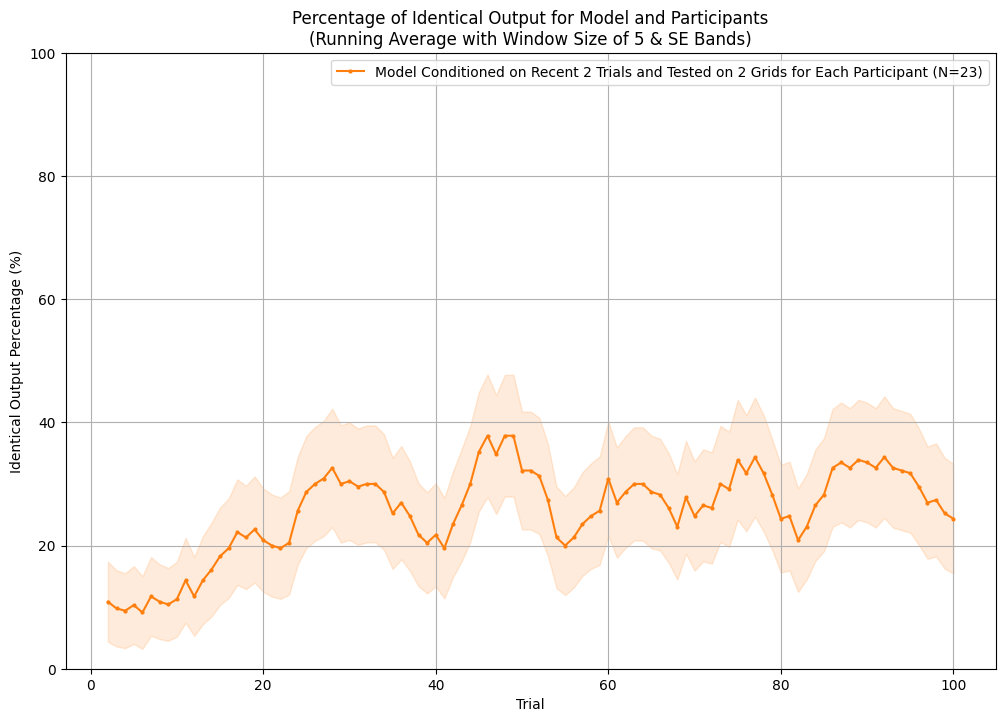

In [35]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_percentage(data, response_column):
    trial_counts = data.groupby('trial')[response_column].agg(['mean', 'count']).reset_index()
    trial_counts['percentage'] = trial_counts['mean'] * 100
    trial_counts['standard_error'] = np.sqrt(trial_counts['mean'] * (1 - trial_counts['mean']) / trial_counts['count']) * 100
    return trial_counts

def calculate_running_average_percentage(data, window_size):
    data = data[data['trial'] > 1].reset_index(drop=True)
    data['running_avg_percentage'] = data['percentage'].rolling(window=window_size, min_periods=1).mean()
    data['running_avg_se'] = data['standard_error'].rolling(window=window_size, min_periods=1).mean()
    return data

def plot_combined_running_average(data_list, labels, window_size, num_files_list, title, ylabel, output_file):
    plt.figure(figsize=(12, 8))
    colors = ['tab:orange', 'tab:green', 'tab:red']
    
    for i, data in enumerate(data_list):
        label = labels[i]
        num_files = num_files_list[i]
        color = colors[i % len(colors)]
        
        plt.plot(data['trial'], data['running_avg_percentage'], marker='o', linestyle='-', color=color, label=f'{label} (N={num_files})', markersize=2)
        plt.fill_between(data['trial'],
                         data['running_avg_percentage'] - data['running_avg_se'],
                         data['running_avg_percentage'] + data['running_avg_se'],
                         color=color, alpha=0.15)
    
    plt.title(title)
    plt.xlabel('Trial')
    plt.ylabel(ylabel)
    plt.ylim(bottom=0, top=100)
    plt.grid(True)
    plt.legend()
    plt.savefig(output_file)
    plt.show()

def process_folder(folder_path, response_column, window_size):
    num_files = len([filename for filename in os.listdir(folder_path) if filename.endswith('.csv')])

    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])

    percentage_data = calculate_percentage(all_data, response_column)
    running_average_data = calculate_running_average_percentage(percentage_data, window_size)

    return running_average_data, num_files

def average_percentage_over_grids(folder_path, response_column):
    subject_files = {}
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            subject_id = filename.split('_')[0]
            file_path = os.path.join(folder_path, filename)
            data = pd.read_csv(file_path)
            
            if subject_id not in subject_files:
                subject_files[subject_id] = []
            subject_files[subject_id].append(data)
    
    averaged_data = []
    for subject_id, data_list in subject_files.items():
        combined_data = pd.concat(data_list)
        averaged_percentage = combined_data.groupby('trial')[response_column].mean().reset_index()
        averaged_percentage['subject_id'] = subject_id
        averaged_data.append(averaged_percentage)
    
    averaged_folder_path = folder_path + '_Average_IdenticalOutput'
    if not os.path.exists(averaged_folder_path):
        os.makedirs(averaged_folder_path)
    
    for averaged_percentage in averaged_data:
        subject_id = averaged_percentage['subject_id'].iloc[0]
        averaged_percentage.drop(columns=['subject_id'], inplace=True)
        averaged_percentage.to_csv(os.path.join(averaged_folder_path, f'{subject_id}.csv'), index=False)

def process_all_folders_and_plot(folder_paths, response_columns, labels, window_size, title, ylabel, output_file):
    running_average_data_list = []
    num_files_list = []
    
    for folder_path, response_column in zip(folder_paths, response_columns):
        if 'ModelOutput' in folder_path:
            average_percentage_over_grids(folder_path, response_column)
            averaged_folder_path = folder_path + '_Average_IdenticalOutput'
        else:
            averaged_folder_path = folder_path
        
        running_average_data, num_files = process_folder(averaged_folder_path, response_column, window_size)
        running_average_data_list.append(running_average_data)
        num_files_list.append(num_files)
    
    plot_combined_running_average(running_average_data_list, labels, window_size, num_files_list, title, ylabel, output_file)

# Set the folder paths and window size
folder_paths = ['ModelOutput_24_with_options']
response_columns = ['identical_output']
labels = ['Model Conditioned on Recent 2 Trials and Tested on 2 Grids for Each Participant']
window_size = 5

# Process all folders and plot the combined running average
process_all_folders_and_plot(folder_paths, response_columns, labels, window_size,
                             f'Percentage of Identical Output for Model and Participants\n(Running Average with Window Size of {window_size} & SE Bands)',
                             'Identical Output Percentage (%)', 'combined_identical_output_percentage_comparison.png')


#### Correlation between number of covered locations in path sequences and optimal path performance

let's first get the path coordinate sequences in the summary files for optimal path percentages

In [36]:
import pandas as pd
import os

def generate_path_sequences(participant_data, window_size):
    prev_path_coords = []

    for i in range(len(participant_data)):
        start_index = max(0, i - window_size)
        paths = participant_data['path'][start_index:i].tolist()

        prev_path_coords.append(paths)

    participant_data['prev_path_coords'] = prev_path_coords

def count_covered_locations(participant_data):
    covered_counts = []
    
    for prev_paths in participant_data['prev_path_coords']:
        unique_locations = set()
        for path in prev_paths:
            for coord in eval(path):  # Using eval to convert the string representation of a list to an actual list
                unique_locations.add(coord)
        covered_counts.append(len(unique_locations))
    
    participant_data['covered_locations'] = covered_counts

def process_files(window_size, model_output_folder, preprocessed_folder):
    for file_name in os.listdir(preprocessed_folder):
        if file_name.endswith('.csv'):
            # Load the preprocessed data
            preprocessed_path = os.path.join(preprocessed_folder, file_name)
            preprocessed_data = pd.read_csv(preprocessed_path)

            # Load the corresponding model output data
            model_output_path = os.path.join(model_output_folder, file_name)
            model_output_data = pd.read_csv(model_output_path)

            # Copy the 'optimal_response' column from preprocessed data to model output data
            model_output_data['optimal_response'] = preprocessed_data['optimal_response']
            
            # Copy the 'path' column from preprocessed data to model output data
            model_output_data['path'] = preprocessed_data['path']
            
            # Apply the generate_path_sequences function
            generate_path_sequences(model_output_data, window_size)
            
            # Count covered locations
            count_covered_locations(model_output_data)

            # Save the updated model output data
            model_output_data.to_csv(model_output_path, index=False)

            # Print file processed
            print(f"Processed {file_name}")

# Define the folder paths
preprocessed_folder = 'PreprocessedSubjectData'
folders_with_window_sizes = {
    "ModelOutput_24_with_options_Average_Optimality": 24,
}

# Process each folder
for folder, window_size in folders_with_window_sizes.items():
    process_files(window_size, folder, preprocessed_folder)


Processed Subject2.csv
Processed Subject3.csv
Processed Subject1.csv
Processed Subject4.csv
Processed Subject6.csv
Processed Subject13.csv
Processed Subject10.csv
Processed Subject14.csv
Processed Subject15.csv
Processed Subject17.csv
Processed Subject16.csv
Processed Subject27.csv
Processed Subject26.csv
Processed Subject24.csv
Processed Subject18.csv
Processed Subject19.csv
Processed Subject25.csv
Processed Subject21.csv
Processed Subject20.csv
Processed Subject22.csv
Processed Subject23.csv
Processed Subject8.csv
Processed Subject9.csv


Let's plot the mean & SE of number of locations covered by recent paths over trials

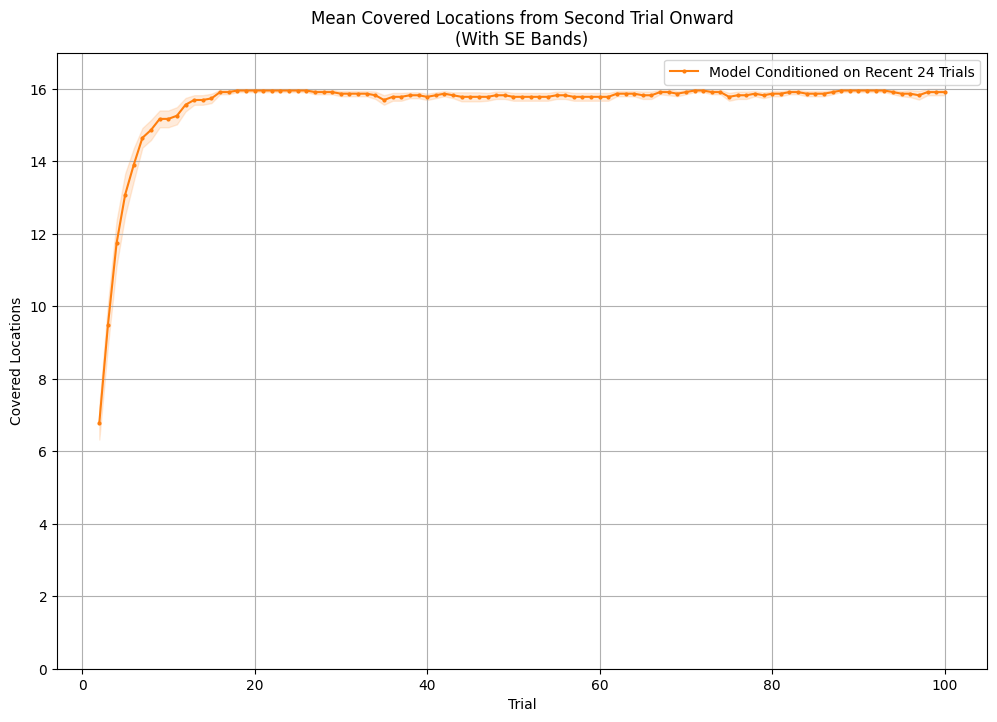

In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_covered_location_stats(data):
    trial_counts = data[data['trial'] > 1].groupby('trial')['covered_locations'].agg(['mean', 'count', 'std']).reset_index()
    trial_counts['standard_error'] = trial_counts['std'] / np.sqrt(trial_counts['count'])
    return trial_counts

def calculate_running_average_stats(data, window_size):
    data['running_avg_mean'] = data['mean'].rolling(window=window_size, min_periods=1).mean()
    data['running_avg_se'] = data['standard_error'].rolling(window=window_size, min_periods=1).mean()
    return data

def plot_covered_locations(data_list, labels, title, ylabel, output_file):
    plt.figure(figsize=(12, 8))
    colors = ['tab:orange', 'tab:green', 'tab:red']
    
    for i, data in enumerate(data_list):
        label = labels[i]
        color = colors[i % len(colors)]
        
        plt.plot(data['trial'], data['running_avg_mean'], marker='o', linestyle='-', color=color, label=label, markersize=2)
        plt.fill_between(data['trial'],
                         data['running_avg_mean'] - data['running_avg_se'],
                         data['running_avg_mean'] + data['running_avg_se'],
                         color=color, alpha=0.15)
    
    plt.title(title)
    plt.xlabel('Trial')
    plt.ylabel(ylabel)
    plt.ylim(bottom=0, top=17)
    plt.grid(True)
    plt.legend()
    plt.savefig(output_file)
    plt.show()

def process_folder_for_covered_locations(folder_path, window_size):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    covered_location_stats = calculate_covered_location_stats(all_data)
    running_avg_stats = calculate_running_average_stats(covered_location_stats, window_size)
    return running_avg_stats

def process_all_folders_and_plot_covered_locations(folder_paths, labels, window_size, title, ylabel, output_file):
    covered_location_data_list = []
    
    for folder_path in folder_paths:
        covered_location_data = process_folder_for_covered_locations(folder_path, window_size)
        covered_location_data_list.append(covered_location_data)
    
    plot_covered_locations(covered_location_data_list, labels, title, ylabel, output_file)

# Set the folder paths and window size
folder_paths = ['ModelOutput_24_with_options_Average_Optimality']
labels = ['Model Conditioned on Recent 24 Trials']
window_size = 1

# Process all folders and plot the mean and SE of covered locations
process_all_folders_and_plot_covered_locations(folder_paths, labels, window_size,
                                               'Mean Covered Locations from Second Trial Onward\n(With SE Bands)',
                                               'Covered Locations', 'combined_covered_locations_comparison.png')


Let's plot the correlation between the number of covered locations and optimal output/response over 2-100 trials and separately for trials 2-20 and trials 21-100.

linear regressions for model output optimal percentages

In [17]:
import pandas as pd
import os

def generate_path_sequences(participant_data, window_size):
    prev_path_coords = []

    for i in range(len(participant_data)):
        start_index = max(0, i - window_size)
        paths = participant_data['path'][start_index:i].tolist()

        prev_path_coords.append(paths)

    participant_data['prev_path_coords'] = prev_path_coords

def count_covered_locations(participant_data):
    covered_counts = []
    
    for prev_paths in participant_data['prev_path_coords']:
        unique_locations = set()
        for path in prev_paths:
            for coord in eval(path):  # Using eval to convert the string representation of a list to an actual list
                unique_locations.add(coord)
        covered_counts.append(len(unique_locations))
    
    participant_data['covered_locations'] = covered_counts

def count_covered_start_end(participant_data):
    covered_counts = []
    
    for prev_paths in participant_data['prev_path_coords']:
        unique_locations = set()
        for path in prev_paths:
            path_list = eval(path)
            if path_list:
                unique_locations.add(path_list[0])  # Start location
                unique_locations.add(path_list[-1])  # End location
        covered_counts.append(len(unique_locations))
    
    participant_data['covered_start_end'] = covered_counts

def process_files(window_size, model_output_folder, preprocessed_folder):
    for file_name in os.listdir(preprocessed_folder):
        if file_name.endswith('.csv'):
            # Load the preprocessed data
            preprocessed_path = os.path.join(preprocessed_folder, file_name)
            preprocessed_data = pd.read_csv(preprocessed_path)

            # Load the corresponding model output data
            model_output_path = os.path.join(model_output_folder, file_name)
            model_output_data = pd.read_csv(model_output_path)

            # Copy the 'optimal_response' column from preprocessed data to model output data
            model_output_data['optimal_response'] = preprocessed_data['optimal_response']
            
            # Copy the 'path' column from preprocessed data to model output data
            model_output_data['path'] = preprocessed_data['path']
            
            # Apply the generate_path_sequences function
            generate_path_sequences(model_output_data, window_size)
            
            # Count covered locations
            count_covered_locations(model_output_data)
            
            # Count covered start and end locations
            count_covered_start_end(model_output_data)

            # Save the updated model output data
            model_output_data.to_csv(model_output_path, index=False)

            # Print file processed
            print(f"Processed {file_name}")

# Define the folder paths
preprocessed_folder = 'PreprocessedSubjectData'
folders_with_window_sizes = {
    "ModelOutput_24_with_options_Average_Optimality_copy": 6
}

# Process each folder
for folder, window_size in folders_with_window_sizes.items():
    process_files(window_size, folder, preprocessed_folder)


Processed Subject2.csv
Processed Subject3.csv
Processed Subject1.csv
Processed Subject4.csv
Processed Subject6.csv
Processed Subject13.csv
Processed Subject10.csv
Processed Subject14.csv
Processed Subject15.csv
Processed Subject17.csv
Processed Subject16.csv
Processed Subject27.csv
Processed Subject26.csv
Processed Subject24.csv
Processed Subject18.csv
Processed Subject19.csv
Processed Subject25.csv
Processed Subject21.csv
Processed Subject20.csv
Processed Subject22.csv
Processed Subject23.csv
Processed Subject8.csv
Processed Subject9.csv


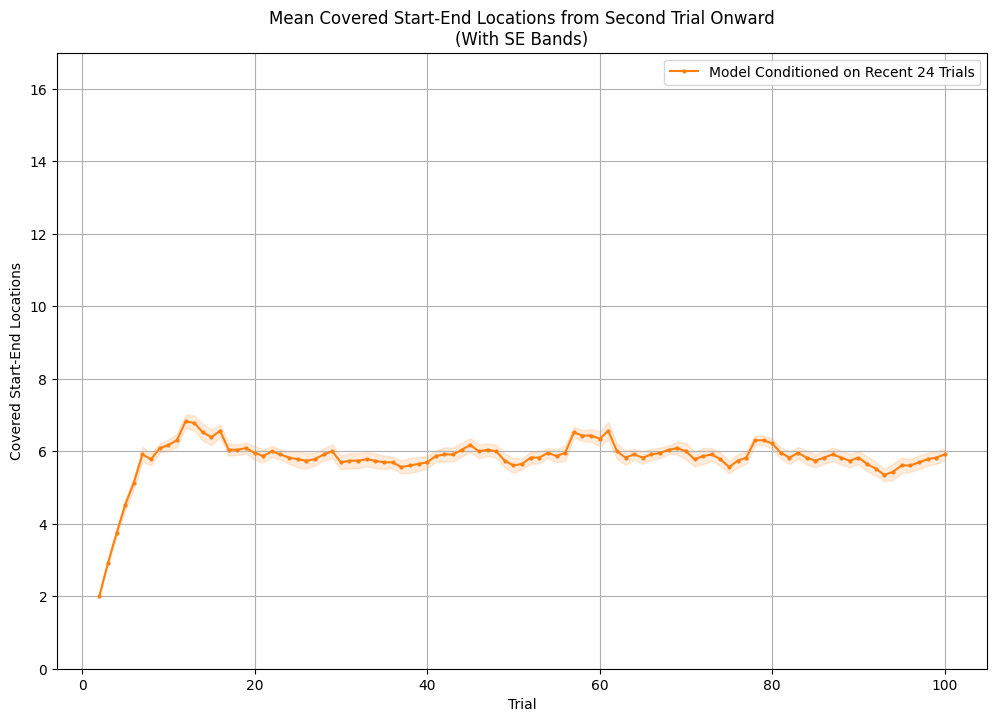

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_covered_start_end_stats(data):
    trial_counts = data[data['trial'] > 1].groupby('trial')['covered_start_end'].agg(['mean', 'count', 'std']).reset_index()
    trial_counts['standard_error'] = trial_counts['std'] / np.sqrt(trial_counts['count'])
    return trial_counts

def calculate_running_average_stats(data, window_size):
    data['running_avg_mean'] = data['mean'].rolling(window=window_size, min_periods=1).mean()
    data['running_avg_se'] = data['standard_error'].rolling(window=window_size, min_periods=1).mean()
    return data

def plot_covered_locations(data_list, labels, title, ylabel, output_file):
    plt.figure(figsize=(12, 8))
    colors = ['tab:orange', 'tab:green', 'tab:red']
    
    for i, data in enumerate(data_list):
        label = labels[i]
        color = colors[i % len(colors)]
        
        plt.plot(data['trial'], data['running_avg_mean'], marker='o', linestyle='-', color=color, label=label, markersize=2)
        plt.fill_between(data['trial'],
                         data['running_avg_mean'] - data['running_avg_se'],
                         data['running_avg_mean'] + data['running_avg_se'],
                         color=color, alpha=0.15)
    
    plt.title(title)
    plt.xlabel('Trial')
    plt.ylabel(ylabel)
    plt.ylim(bottom=0, top=17)
    plt.grid(True)
    plt.legend()
    plt.savefig(output_file)
    plt.show()

def process_folder_for_covered_locations(folder_path, window_size):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    covered_location_stats = calculate_covered_start_end_stats(all_data)
    running_avg_stats = calculate_running_average_stats(covered_location_stats, window_size)
    return running_avg_stats

def process_all_folders_and_plot_covered_locations(folder_paths, labels, window_size, title, ylabel, output_file):
    covered_location_data_list = []
    
    for folder_path in folder_paths:
        covered_location_data = process_folder_for_covered_locations(folder_path, window_size)
        covered_location_data_list.append(covered_location_data)
    
    plot_covered_locations(covered_location_data_list, labels, title, ylabel, output_file)

# Set the folder paths and window size
folder_paths = ['ModelOutput_24_with_options_Average_Optimality_copy']
labels = ['Model Conditioned on Recent 24 Trials']
window_size = 1

# Process all folders and plot the mean and SE of covered locations
process_all_folders_and_plot_covered_locations(folder_paths, labels, window_size,
                                               'Mean Covered Start-End Locations from Second Trial Onward\n(With SE Bands)',
                                               'Covered Start-End Locations', 'combined_covered_start_end_comparison.png')


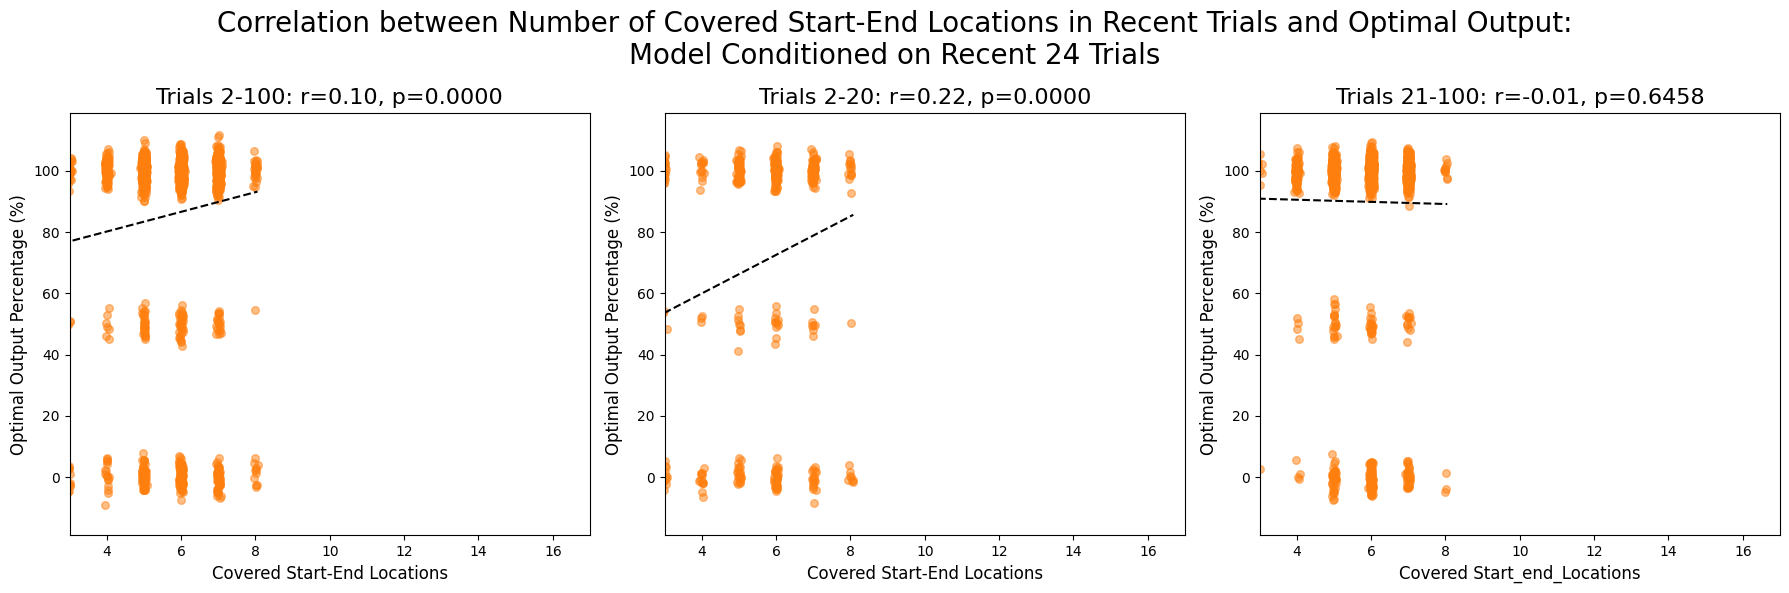

In [19]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

def calculate_correlations(data):
    # Filter trials
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    
    # Calculate correlations
    corr_2_100 = pearsonr(data_2_100['covered_start_end'], data_2_100['optimality'])
    corr_2_20 = pearsonr(data_2_20['covered_start_end'], data_2_20['optimality'])
    corr_21_100 = pearsonr(data_21_100['covered_start_end'], data_21_100['optimality'])
    
    return corr_2_100, corr_2_20, corr_21_100

def plot_correlations(data, corr_2_100, corr_2_20, corr_21_100, label, folder, color):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Correlation between Number of Covered Start-End Locations in Recent Trials and Optimal Output:\n{label}", fontsize=20)
    
    def add_best_fit_line(ax, x, y):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = model.predict(x_range.reshape(-1, 1))
        ax.plot(x_range, y_pred, color='black', linestyle='--')
    
    def add_jitter(data, jitter_amount=0.03):
        return data + np.random.normal(0, jitter_amount, size=data.shape)
    
    # Scatter plot for trials 2-100
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    x_2_100 = add_jitter(data_2_100['covered_start_end'])
    y_2_100 = add_jitter(data_2_100['optimality']) * 100
    axs[0].scatter(x_2_100, y_2_100, alpha=0.5, color=color, s=30)
    add_best_fit_line(axs[0], x_2_100, y_2_100)
    axs[0].set_title(f'Trials 2-100: r={corr_2_100[0]:.2f}, p={corr_2_100[1]:.4f}', fontsize=16)
    axs[0].set_xlabel('Covered Start-End Locations', fontsize=12)
    axs[0].set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    axs[0].set_xlim([3, 17])  # Set fixed x-axis range
    axs[0].set_ylim([-19, 119])  # Set fixed y-axis range

    # Scatter plot for trials 2-20
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    x_2_20 = add_jitter(data_2_20['covered_start_end'])
    y_2_20 = add_jitter(data_2_20['optimality']) * 100
    axs[1].scatter(x_2_20, y_2_20, alpha=0.5, color=color, s=30)
    add_best_fit_line(axs[1], x_2_20, y_2_20)
    axs[1].set_title(f'Trials 2-20: r={corr_2_20[0]:.2f}, p={corr_2_20[1]:.4f}', fontsize=16)
    axs[1].set_xlabel('Covered Start-End Locations', fontsize=12)
    axs[1].set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    axs[1].set_xlim([3, 17])  # Set fixed x-axis range
    axs[1].set_ylim([-19, 119])  # Set fixed y-axis range

    # Scatter plot for trials 21-100
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    x_21_100 = add_jitter(data_21_100['covered_start_end'])
    y_21_100 = add_jitter(data_21_100['optimality']) * 100
    axs[2].scatter(x_21_100, y_21_100, alpha=0.5, color=color, s=30)
    add_best_fit_line(axs[2], x_21_100, y_21_100)
    axs[2].set_title(f'Trials 21-100: r={corr_21_100[0]:.2f}, p={corr_21_100[1]:.4f}', fontsize=16)
    axs[2].set_xlabel('Covered Start_end_Locations', fontsize=12)
    axs[2].set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    axs[2].set_xlim([3, 17])  # Set fixed x-axis range
    axs[2].set_ylim([-19, 119])  # Set fixed y-axis range

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f'{folder}_covered_start_end_correlation.png')
    plt.show()

def process_folder_for_correlation(folder_path):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    return all_data

def process_all_folders_and_plot_correlations(folder_paths, labels, colors):
    for folder_path, label, color in zip(folder_paths, labels, colors):
        data = process_folder_for_correlation(folder_path)
        corr_2_100, corr_2_20, corr_21_100 = calculate_correlations(data)
        plot_correlations(data, corr_2_100, corr_2_20, corr_21_100, label, folder_path, color)

# Set the folder paths and colors
folder_paths = ['ModelOutput_24_with_options_Average_Optimality_copy']
labels = ['Model Conditioned on Recent 24 Trials']
colors = ['tab:orange', 'tab:green', 'tab:red']

# Process all folders and plot the correlations
process_all_folders_and_plot_correlations(folder_paths, labels, colors)


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

def calculate_correlations(data):
    # Filter trials
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    
    # Calculate correlations
    corr_2_100 = pearsonr(data_2_100['covered_locations'], data_2_100['optimality'])
    corr_2_20 = pearsonr(data_2_20['covered_locations'], data_2_20['optimality'])
    corr_21_100 = pearsonr(data_21_100['covered_locations'], data_21_100['optimality'])
    
    return corr_2_100, corr_2_20, corr_21_100

def plot_correlations(data, corr_2_100, corr_2_20, corr_21_100, label, folder, color):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Correlation between Number of Covered Locations in Recent Trials and Optimal Output:\n{label}", fontsize=20)
    
    def add_best_fit_line(ax, x, y):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = model.predict(x_range.reshape(-1, 1))
        ax.plot(x_range, y_pred, color='black', linestyle='--')
    
    def add_jitter(data, jitter_amount=0.03):
        return data + np.random.normal(0, jitter_amount, size=data.shape)
    
    # Scatter plot for trials 2-100
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    x_2_100 = add_jitter(data_2_100['covered_locations'])
    y_2_100 = add_jitter(data_2_100['optimality']) * 100
    axs[0].scatter(x_2_100, y_2_100, alpha=0.5, color=color, s=30)
    add_best_fit_line(axs[0], x_2_100, y_2_100)
    axs[0].set_title(f'Trials 2-100: r={corr_2_100[0]:.2f}, p={corr_2_100[1]:.4f}', fontsize=16)
    axs[0].set_xlabel('Covered Locations', fontsize=12)
    axs[0].set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    axs[0].set_xlim([3, 17])  # Set fixed x-axis range
    axs[0].set_ylim([-19, 119])  # Set fixed y-axis range

    # Scatter plot for trials 2-20
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    x_2_20 = add_jitter(data_2_20['covered_locations'])
    y_2_20 = add_jitter(data_2_20['optimality']) * 100
    axs[1].scatter(x_2_20, y_2_20, alpha=0.5, color=color, s=30)
    add_best_fit_line(axs[1], x_2_20, y_2_20)
    axs[1].set_title(f'Trials 2-20: r={corr_2_20[0]:.2f}, p={corr_2_20[1]:.4f}', fontsize=16)
    axs[1].set_xlabel('Covered Locations', fontsize=12)
    axs[1].set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    axs[1].set_xlim([3, 17])  # Set fixed x-axis range
    axs[1].set_ylim([-19, 119])  # Set fixed y-axis range

    # Scatter plot for trials 21-100
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    x_21_100 = add_jitter(data_21_100['covered_locations'])
    y_21_100 = add_jitter(data_21_100['optimality']) * 100
    axs[2].scatter(x_21_100, y_21_100, alpha=0.5, color=color, s=30)
    add_best_fit_line(axs[2], x_21_100, y_21_100)
    axs[2].set_title(f'Trials 21-100: r={corr_21_100[0]:.2f}, p={corr_21_100[1]:.4f}', fontsize=16)
    axs[2].set_xlabel('Covered Locations', fontsize=12)
    axs[2].set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    axs[2].set_xlim([3, 17])  # Set fixed x-axis range
    axs[2].set_ylim([-19, 119])  # Set fixed y-axis range

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f'{folder}_covered_locations_correlation.png')
    plt.show()

def process_folder_for_correlation(folder_path):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    return all_data

def process_all_folders_and_plot_correlations(folder_paths, labels, colors):
    for folder_path, label, color in zip(folder_paths, labels, colors):
        data = process_folder_for_correlation(folder_path)
        corr_2_100, corr_2_20, corr_21_100 = calculate_correlations(data)
        plot_correlations(data, corr_2_100, corr_2_20, corr_21_100, label, folder_path, color)

# Set the folder paths and colors
folder_paths = ['ModelOutput_24_with_options_Average_Optimality']
labels = ['Model Conditioned on Recent 24 Trials']
colors = ['tab:orange', 'tab:green', 'tab:red']

# Process all folders and plot the correlations
process_all_folders_and_plot_correlations(folder_paths, labels, colors)


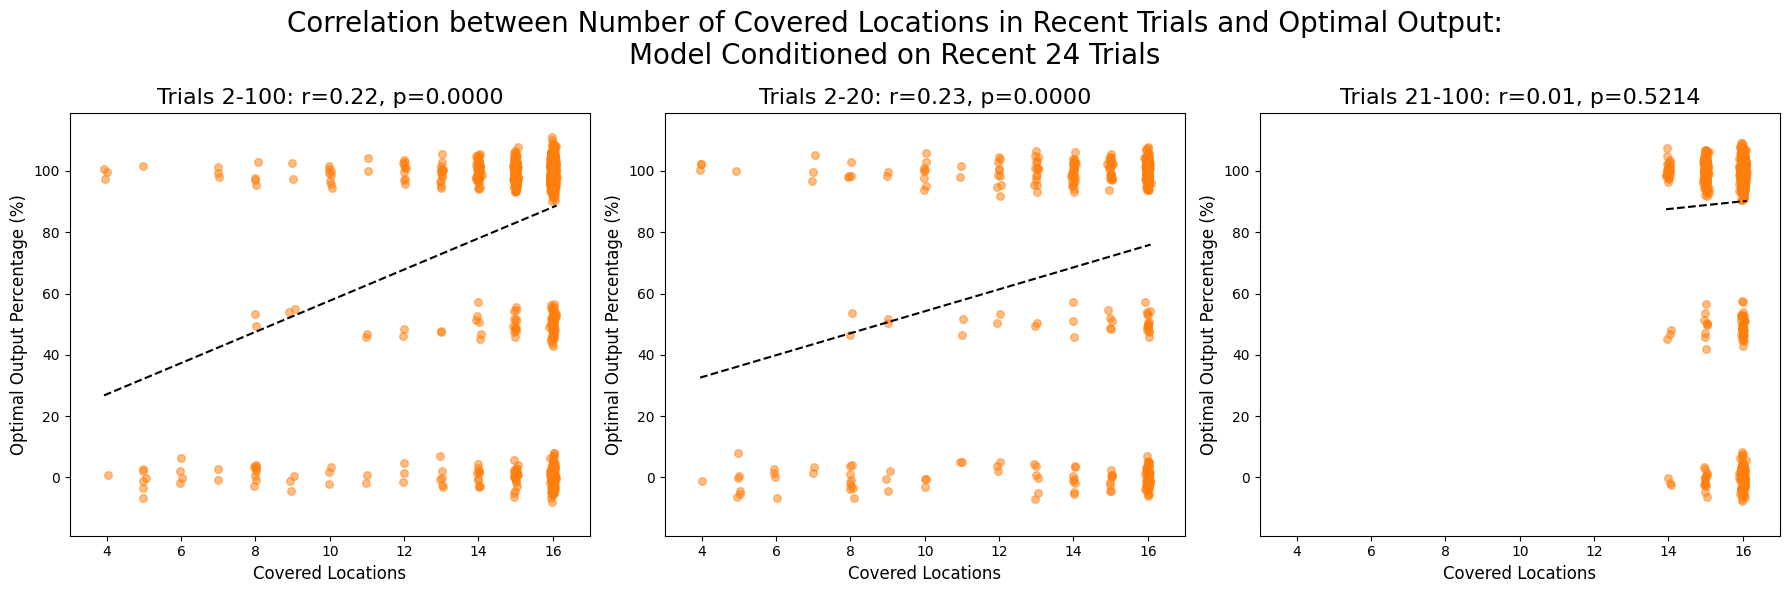

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

def calculate_correlations(data):
    # Filter trials
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    
    # Calculate correlations
    corr_2_100 = pearsonr(data_2_100['covered_locations'], data_2_100['optimality'])
    corr_2_20 = pearsonr(data_2_20['covered_locations'], data_2_20['optimality'])
    corr_21_100 = pearsonr(data_21_100['covered_locations'], data_21_100['optimality'])
    
    return corr_2_100, corr_2_20, corr_21_100

def plot_correlations(data, corr_2_100, corr_2_20, corr_21_100, label, folder, color):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Correlation between Number of Covered Locations in Recent Trials and Optimal Output:\n{label}", fontsize=20)
    
    def add_best_fit_line(ax, x, y):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = model.predict(x_range.reshape(-1, 1))
        ax.plot(x_range, y_pred, color='black', linestyle='--')
    
    def add_jitter(data, jitter_amount=0.03):
        return data + np.random.normal(0, jitter_amount, size=data.shape)
    
    # Scatter plot for trials 2-100
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    x_2_100 = add_jitter(data_2_100['covered_locations'])
    y_2_100 = add_jitter(data_2_100['optimality']) * 100
    axs[0].scatter(x_2_100, y_2_100, alpha=0.5, color=color, s=30)
    add_best_fit_line(axs[0], x_2_100, y_2_100)
    axs[0].set_title(f'Trials 2-100: r={corr_2_100[0]:.2f}, p={corr_2_100[1]:.4f}', fontsize=16)
    axs[0].set_xlabel('Covered Locations', fontsize=12)
    axs[0].set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    axs[0].set_xlim([3, 17])  # Set fixed x-axis range
    axs[0].set_ylim([-19, 119])  # Set fixed y-axis range

    # Scatter plot for trials 2-20
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    x_2_20 = add_jitter(data_2_20['covered_locations'])
    y_2_20 = add_jitter(data_2_20['optimality']) * 100
    axs[1].scatter(x_2_20, y_2_20, alpha=0.5, color=color, s=30)
    add_best_fit_line(axs[1], x_2_20, y_2_20)
    axs[1].set_title(f'Trials 2-20: r={corr_2_20[0]:.2f}, p={corr_2_20[1]:.4f}', fontsize=16)
    axs[1].set_xlabel('Covered Locations', fontsize=12)
    axs[1].set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    axs[1].set_xlim([3, 17])  # Set fixed x-axis range
    axs[1].set_ylim([-19, 119])  # Set fixed y-axis range

    # Scatter plot for trials 21-100
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    x_21_100 = add_jitter(data_21_100['covered_locations'])
    y_21_100 = add_jitter(data_21_100['optimality']) * 100
    axs[2].scatter(x_21_100, y_21_100, alpha=0.5, color=color, s=30)
    add_best_fit_line(axs[2], x_21_100, y_21_100)
    axs[2].set_title(f'Trials 21-100: r={corr_21_100[0]:.2f}, p={corr_21_100[1]:.4f}', fontsize=16)
    axs[2].set_xlabel('Covered Locations', fontsize=12)
    axs[2].set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    axs[2].set_xlim([3, 17])  # Set fixed x-axis range
    axs[2].set_ylim([-19, 119])  # Set fixed y-axis range

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f'{folder}_covered_locations_correlation.png')
    plt.show()

def process_folder_for_correlation(folder_path):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    return all_data

def process_all_folders_and_plot_correlations(folder_paths, labels, colors):
    for folder_path, label, color in zip(folder_paths, labels, colors):
        data = process_folder_for_correlation(folder_path)
        corr_2_100, corr_2_20, corr_21_100 = calculate_correlations(data)
        plot_correlations(data, corr_2_100, corr_2_20, corr_21_100, label, folder_path, color)

# Set the folder paths and colors
folder_paths = ['ModelOutput_24_with_options_Average_Optimality']
labels = ['Model Conditioned on Recent 24 Trials']
colors = ['tab:orange', 'tab:green', 'tab:red']

# Process all folders and plot the correlations
process_all_folders_and_plot_correlations(folder_paths, labels, colors)


save as one single image for comparison

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

def calculate_correlations(data):
    # Filter trials
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    
    # Calculate correlations
    corr_2_100 = pearsonr(data_2_100['covered_locations'], data_2_100['optimality'])
    corr_2_20 = pearsonr(data_2_20['covered_locations'], data_2_20['optimality'])
    corr_21_100 = pearsonr(data_21_100['covered_locations'], data_21_100['optimality'])
    
    return corr_2_100, corr_2_20, corr_21_100

def plot_correlations(ax, data, corr, title, color):
    def add_best_fit_line(ax, x, y):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = model.predict(x_range.reshape(-1, 1))
        ax.plot(x_range, y_pred, color='black', linestyle='--')
    
    def add_jitter(data, jitter_amount=0.04):
        return data + np.random.normal(0, jitter_amount, size=data.shape)
    
    x = add_jitter(data['covered_locations'])
    y = add_jitter(data['optimality']) * 100
    ax.scatter(x, y, alpha=0.5, color=color, s=30)
    add_best_fit_line(ax, x, y)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Covered Locations', fontsize=12)
    ax.set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    ax.set_xlim([3, 17])  # Set fixed x-axis range
    ax.set_ylim([-19, 119])  # Set fixed y-axis range

def process_folder_for_correlation(folder_path):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    return all_data

def process_all_folders_and_plot_correlations(folder_paths, labels, colors):
    fig, axs = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle("Correlation between Number of Covered Locations in Recent Trials and Optimal Output:\nLinear Regression", fontsize=20)
    
    for idx, (folder_path, label, color) in enumerate(zip(folder_paths, labels, colors)):
        data = process_folder_for_correlation(folder_path)
        corr_2_100, corr_2_20, corr_21_100 = calculate_correlations(data)
        
        # Plot for trials 2-100
        data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
        plot_correlations(axs[idx, 0], data_2_100, corr_2_100, f'{label}\nTrials 2-100: r={corr_2_100[0]:.2f}, p={corr_2_100[1]:.4f}', color)
        
        # Plot for trials 2-20
        data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
        plot_correlations(axs[idx, 1], data_2_20, corr_2_20, f'{label}\nTrials 2-20: r={corr_2_20[0]:.2f}, p={corr_2_20[1]:.4f}', color)
        
        # Plot for trials 21-100
        data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
        plot_correlations(axs[idx, 2], data_21_100, corr_21_100, f'{label}\nTrials 21-100: r={corr_21_100[0]:.2f}, p={corr_21_100[1]:.4f}', color)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('combined_model_optimality_percentage_covered_locations_correlation.png')
    plt.show()

# Set the folder paths and colors
folder_paths = ['ModelOutput_30_Average_Optimality']
labels = ['Model Conditioned on Recent 30 Trials']
colors = ['tab:orange', 'tab:green', 'tab:red']

# Process all folders and plot the correlations
process_all_folders_and_plot_correlations(folder_paths, labels, colors)


logistic regression for particpants optimal response

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc

def calculate_correlations(data):
    # Ensure binary format for 'optimal_response'
    data['optimal_response'] = data['optimal_response'].astype(int)
    
    # Filter trials
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    
    # Calculate correlations
    corr_2_100 = pearsonr(data_2_100['covered_locations'], data_2_100['optimal_response'])
    corr_2_20 = pearsonr(data_2_20['covered_locations'], data_2_20['optimal_response'])
    corr_21_100 = pearsonr(data_21_100['covered_locations'], data_21_100['optimal_response'])
    
    return corr_2_100, corr_2_20, corr_21_100

def plot_correlations(data, corr_2_100, corr_2_20, corr_21_100, label, folder, color):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Correlation between Number of Covered Locations in Recent {label} Trials and Optimal Response from Participants", fontsize=20)
    
    def add_best_fit_line(ax, x, y):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y).astype(int)  # Ensure binary format
        model = LogisticRegression().fit(x, y)
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = model.predict_proba(x_range.reshape(-1, 1))[:, 1]
        ax.plot(x_range, y_pred, color='black', linestyle='--')
    
    def add_jitter(data, jitter_amount=0.04):
        return data + np.random.normal(0, jitter_amount, size=data.shape)
    
    # Scatter plot for trials 2-100
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    x_2_100 = add_jitter(data_2_100['covered_locations'])
    y_2_100 = add_jitter(data_2_100['optimal_response'])
    axs[0].scatter(x_2_100, y_2_100, alpha=0.5, color=color, s=18)
    add_best_fit_line(axs[0], x_2_100, y_2_100)
    axs[0].set_title(f'Trials 2-100: r={corr_2_100[0]:.2f}, p={corr_2_100[1]:.4f}', fontsize=16)
    axs[0].set_xlabel('Covered Locations', fontsize=12)
    axs[0].set_ylabel('Optimal Response (1 = True; 0 = False)', fontsize=12)
    axs[0].set_xlim([3, 17])  # Set fixed x-axis range
    axs[0].set_ylim([-0.19, 1.19])  # Set fixed y-axis range

    # Scatter plot for trials 2-20
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    x_2_20 = add_jitter(data_2_20['covered_locations'])
    y_2_20 = add_jitter(data_2_20['optimal_response'])
    axs[1].scatter(x_2_20, y_2_20, alpha=0.5, color=color, s=18)
    add_best_fit_line(axs[1], x_2_20, y_2_20)
    axs[1].set_title(f'Trials 2-20: r={corr_2_20[0]:.2f}, p={corr_2_20[1]:.4f}', fontsize=16)
    axs[1].set_xlabel('Covered Locations', fontsize=12)
    axs[1].set_ylabel('Optimal Response (1 = True; 0 = False)', fontsize=12)
    axs[1].set_xlim([3, 17])  # Set fixed x-axis range
    axs[1].set_ylim([-0.19, 1.19])  # Set fixed y-axis range

    # Scatter plot for trials 21-100
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    x_21_100 = add_jitter(data_21_100['covered_locations'])
    y_21_100 = add_jitter(data_21_100['optimal_response'])
    axs[2].scatter(x_21_100, y_21_100, alpha=0.5, color=color, s=18)
    add_best_fit_line(axs[2], x_21_100, y_21_100)
    axs[2].set_title(f'Trials 21-100: r={corr_21_100[0]:.2f}, p={corr_21_100[1]:.4f}', fontsize=16)
    axs[2].set_xlabel('Covered Locations', fontsize=12)
    axs[2].set_ylabel('Optimal Response (1 = True; 0 = False)', fontsize=12)
    axs[2].set_xlim([3, 17])  # Set fixed x-axis range
    axs[2].set_ylim([-0.19, 1.19])  # Set fixed y-axis range

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f'ParticipantOptimalResponse_Recent{label}Trials_covered_locations_correlation.png')
    plt.show()

def process_folder_for_correlation(folder_path):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    return all_data

def process_all_folders_and_plot_correlations(folder_paths, labels, colors):
    for folder_path, label, color in zip(folder_paths, labels, colors):
        data = process_folder_for_correlation(folder_path)
        corr_2_100, corr_2_20, corr_21_100 = calculate_correlations(data)
        plot_correlations(data, corr_2_100, corr_2_20, corr_21_100, label, folder_path, color)

# Set the folder paths and colors
folder_paths = ['ModelOutput_30_Average_Optimality']
labels = ['30']
colors = ['tab:orange', 'tab:green', 'tab:red']

# Process all folders and plot the correlations
process_all_folders_and_plot_correlations(folder_paths, labels, colors)


save as one single image for comparison

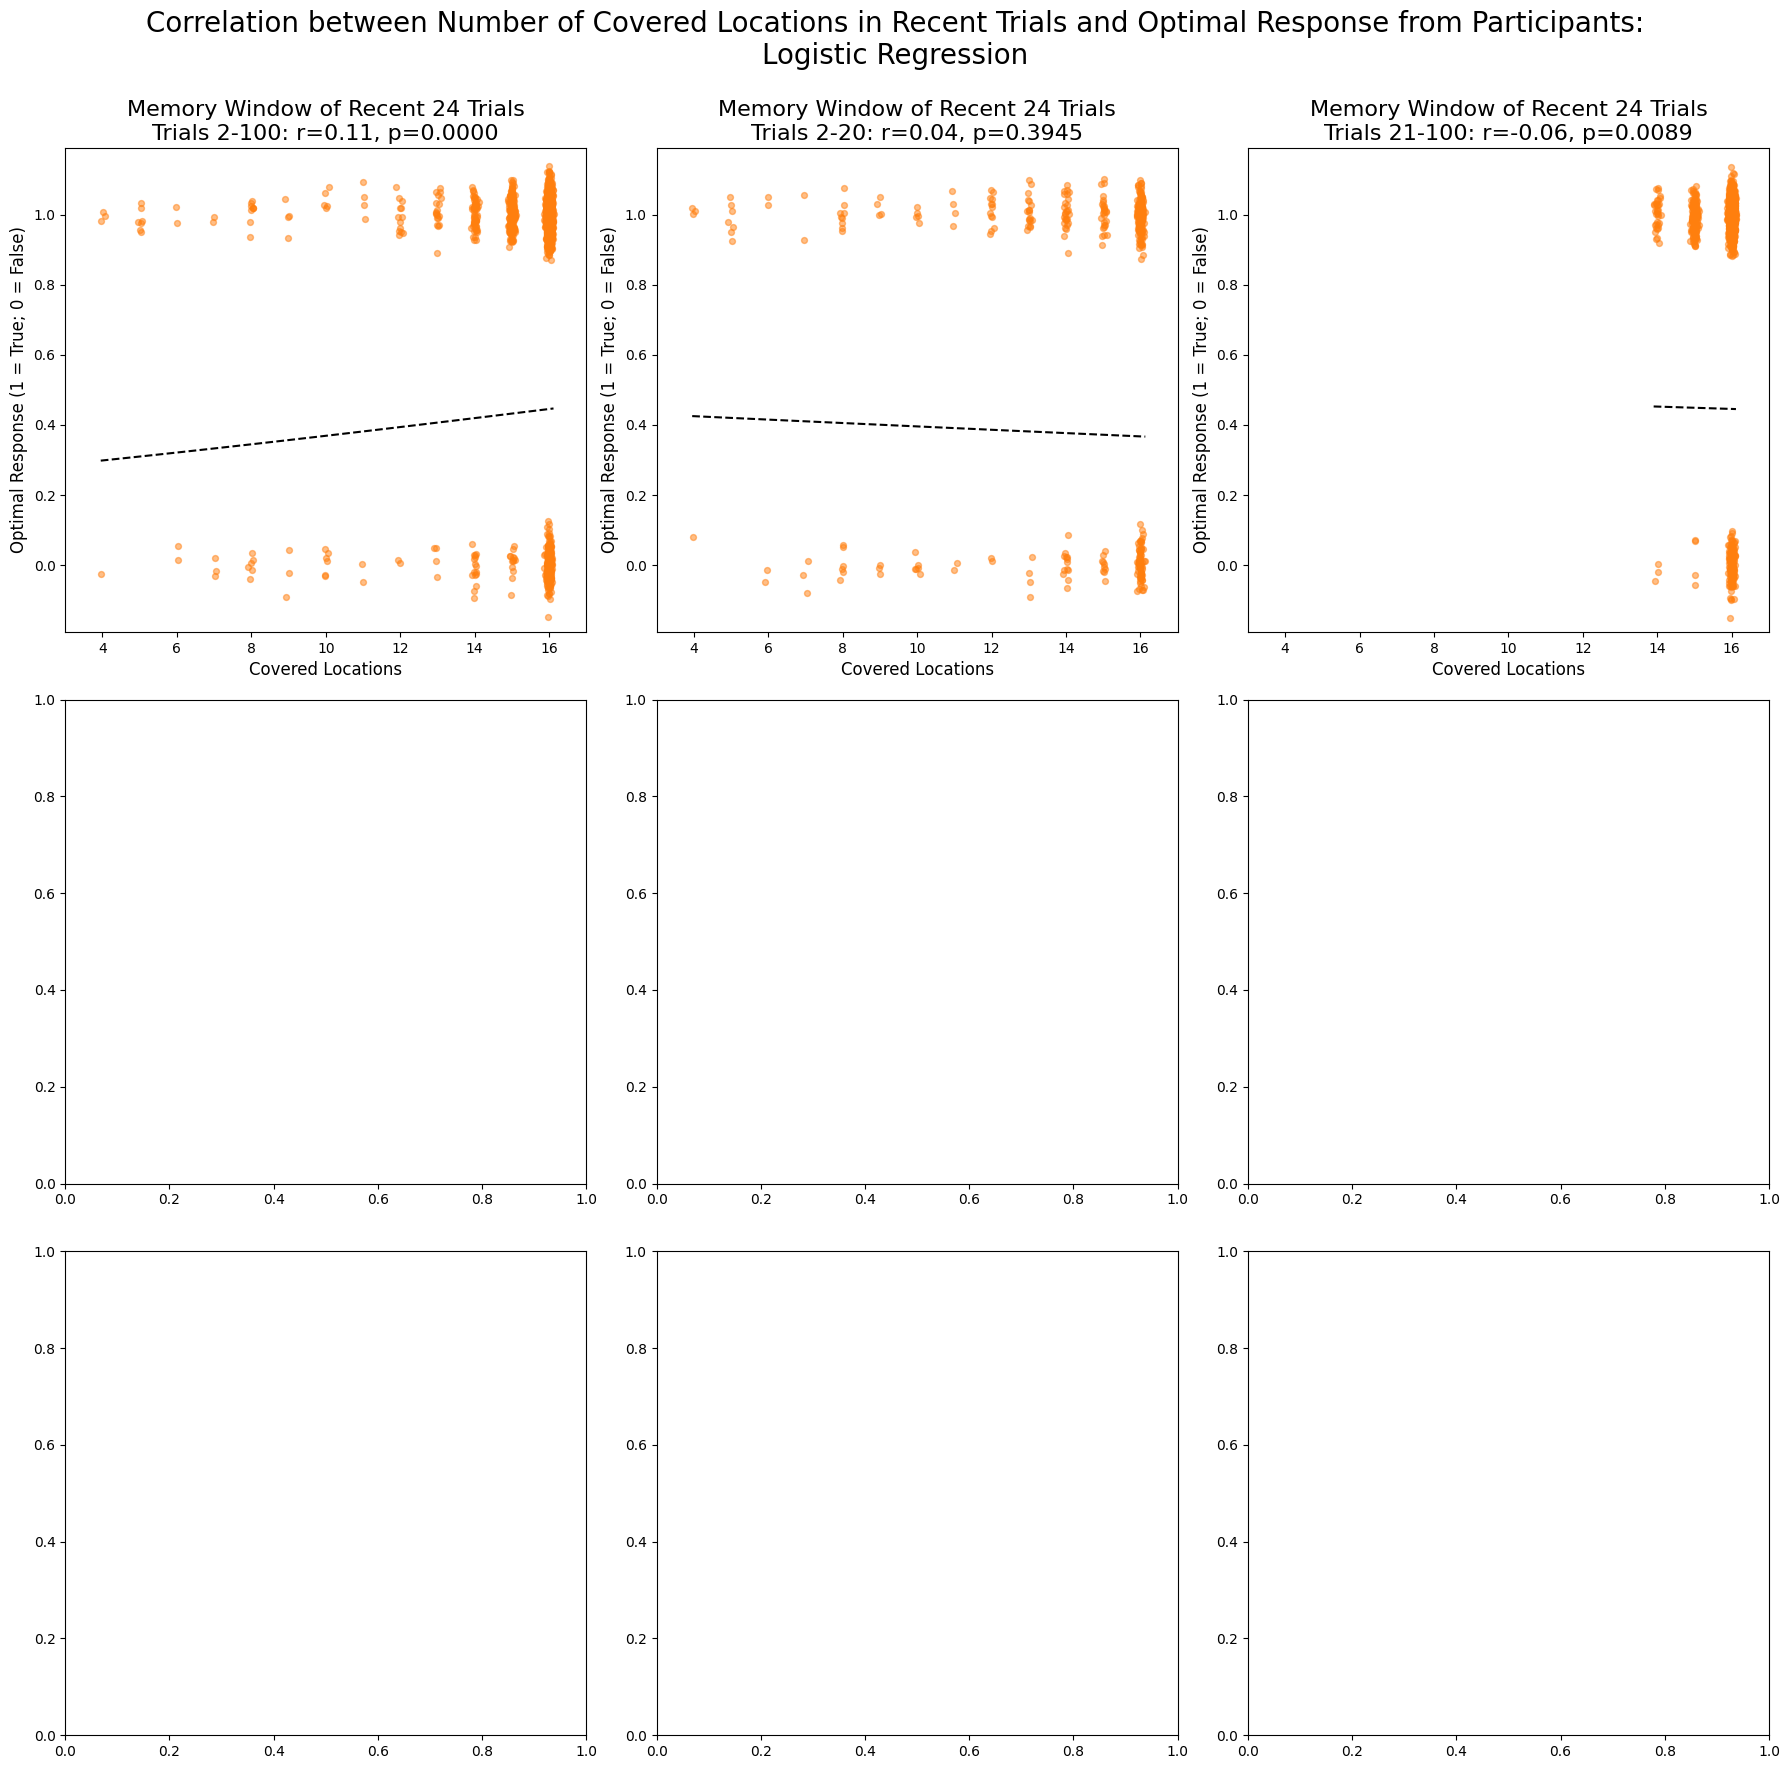

In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc

def calculate_correlations(data):
    # Ensure binary format for 'optimal_response'
    data['optimal_response'] = data['optimal_response'].astype(int)
    
    # Filter trials
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    
    # Calculate correlations
    corr_2_100 = pearsonr(data_2_100['covered_locations'], data_2_100['optimal_response'])
    corr_2_20 = pearsonr(data_2_20['covered_locations'], data_2_20['optimal_response'])
    corr_21_100 = pearsonr(data_21_100['covered_locations'], data_21_100['optimal_response'])
    
    return corr_2_100, corr_2_20, corr_21_100

def plot_correlations(ax, data, corr, title, color):
    def add_best_fit_line(ax, x, y):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y).astype(int)  # Ensure binary format
        model = LogisticRegression().fit(x, y)
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = model.predict_proba(x_range.reshape(-1, 1))[:, 1]
        ax.plot(x_range, y_pred, color='black', linestyle='--')
    
    def add_jitter(data, jitter_amount=0.04):
        return data + np.random.normal(0, jitter_amount, size=data.shape)
    
    x = add_jitter(data['covered_locations'])
    y = add_jitter(data['optimal_response'])
    ax.scatter(x, y, alpha=0.5, color=color, s=18)
    add_best_fit_line(ax, x, y)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Covered Locations', fontsize=12)
    ax.set_ylabel('Optimal Response (1 = True; 0 = False)', fontsize=12)
    ax.set_xlim([3, 17])  # Set fixed x-axis range
    ax.set_ylim([-0.19, 1.19])  # Set fixed x-axis range

def process_folder_for_correlation(folder_path):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    return all_data

def process_all_folders_and_plot_correlations(folder_paths, labels, colors):
    fig, axs = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle("Correlation between Number of Covered Locations in Recent Trials and Optimal Response from Participants:\nLogistic Regression", fontsize=20)
    
    for idx, (folder_path, label, color) in enumerate(zip(folder_paths, labels, colors)):
        data = process_folder_for_correlation(folder_path)
        corr_2_100, corr_2_20, corr_21_100 = calculate_correlations(data)
        
        # Plot for trials 2-100
        data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
        plot_correlations(axs[idx, 0], data_2_100, corr_2_100, f'Memory Window of Recent {label} Trials\nTrials 2-100: r={corr_2_100[0]:.2f}, p={corr_2_100[1]:.4f}', color)
        
        # Plot for trials 2-20
        data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
        plot_correlations(axs[idx, 1], data_2_20, corr_2_20, f'Memory Window of Recent {label} Trials\nTrials 2-20: r={corr_2_20[0]:.2f}, p={corr_2_20[1]:.4f}', color)
        
        # Plot for trials 21-100
        data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
        plot_correlations(axs[idx, 2], data_21_100, corr_21_100, f'Memory Window of Recent {label} Trials\nTrials 21-100: r={corr_21_100[0]:.2f}, p={corr_21_100[1]:.4f}', color)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('combined_participant_optimal_response_covered_locations_correlation.png')
    plt.show()

# Set the folder paths and colors
folder_paths = ['ModelOutput_24_with_options_Average_Optimality']
labels = ['24']
colors = ['tab:orange', 'tab:green', 'tab:red']

# Process all folders and plot the correlations
process_all_folders_and_plot_correlations(folder_paths, labels, colors)


#### Correlation between number of covered start-end locations and optimal path performance

let's first get the path coordinate sequences in the summary files for optimal path percentages

In [ ]:
import pandas as pd
import os

def generate_path_sequences(participant_data, window_size):
    prev_path_coords = []

    for i in range(len(participant_data)):
        start_index = max(0, i - window_size)
        paths = participant_data['path'][start_index:i].tolist()

        prev_path_coords.append(paths)

    participant_data['prev_path_coords'] = prev_path_coords

def count_covered_locations(participant_data):
    covered_counts = []
    
    for prev_paths in participant_data['prev_path_coords']:
        unique_locations = set()
        for path in prev_paths:
            for coord in eval(path):  # Using eval to convert the string representation of a list to an actual list
                unique_locations.add(coord)
        covered_counts.append(len(unique_locations))
    
    participant_data['covered_locations'] = covered_counts

def count_covered_start_end(participant_data):
    covered_counts = []
    
    for prev_paths in participant_data['prev_path_coords']:
        unique_locations = set()
        for path in prev_paths:
            path_list = eval(path)
            if path_list:
                unique_locations.add(path_list[0])  # Start location
                unique_locations.add(path_list[-1])  # End location
        covered_counts.append(len(unique_locations))
    
    participant_data['covered_start_end'] = covered_counts

def process_files(window_size, model_output_folder, preprocessed_folder):
    for file_name in os.listdir(preprocessed_folder):
        if file_name.endswith('.csv'):
            # Load the preprocessed data
            preprocessed_path = os.path.join(preprocessed_folder, file_name)
            preprocessed_data = pd.read_csv(preprocessed_path)

            # Load the corresponding model output data
            model_output_path = os.path.join(model_output_folder, file_name)
            model_output_data = pd.read_csv(model_output_path)

            # Copy the 'optimal_response' column from preprocessed data to model output data
            model_output_data['optimal_response'] = preprocessed_data['optimal_response']
            
            # Copy the 'path' column from preprocessed data to model output data
            model_output_data['path'] = preprocessed_data['path']
            
            # Apply the generate_path_sequences function
            generate_path_sequences(model_output_data, window_size)
            
            # Count covered locations
            count_covered_locations(model_output_data)
            
            # Count covered start and end locations
            count_covered_start_end(model_output_data)

            # Save the updated model output data
            model_output_data.to_csv(model_output_path, index=False)

            # Print file processed
            print(f"Processed {file_name}")

# Define the folder paths
preprocessed_folder = 'PreprocessedSubjectData'
folders_with_window_sizes = {
    "ModelOutput_6_Average_Optimality": 6,
    "ModelOutput_12_Average_Optimality": 12,
    "ModelOutput_18_Average_Optimality": 18
}

# Process each folder
for folder, window_size in folders_with_window_sizes.items():
    process_files(window_size, folder, preprocessed_folder)


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def calculate_covered_start_end_stats(data):
    trial_counts = data[data['trial'] > 1].groupby('trial')['covered_start_end'].agg(['mean', 'count', 'std']).reset_index()
    trial_counts['standard_error'] = trial_counts['std'] / np.sqrt(trial_counts['count'])
    return trial_counts

def calculate_running_average_stats(data, window_size):
    data['running_avg_mean'] = data['mean'].rolling(window=window_size, min_periods=1).mean()
    data['running_avg_se'] = data['standard_error'].rolling(window=window_size, min_periods=1).mean()
    return data

def plot_covered_locations(data_list, labels, title, ylabel, output_file):
    plt.figure(figsize=(12, 8))
    colors = ['tab:orange', 'tab:green', 'tab:red']
    
    for i, data in enumerate(data_list):
        label = labels[i]
        color = colors[i % len(colors)]
        
        plt.plot(data['trial'], data['running_avg_mean'], marker='o', linestyle='-', color=color, label=label, markersize=2)
        plt.fill_between(data['trial'],
                         data['running_avg_mean'] - data['running_avg_se'],
                         data['running_avg_mean'] + data['running_avg_se'],
                         color=color, alpha=0.15)
    
    plt.title(title)
    plt.xlabel('Trial')
    plt.ylabel(ylabel)
    plt.ylim(bottom=0, top=17)
    plt.grid(True)
    plt.legend()
    plt.savefig(output_file)
    plt.show()

def process_folder_for_covered_locations(folder_path, window_size):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    covered_location_stats = calculate_covered_start_end_stats(all_data)
    running_avg_stats = calculate_running_average_stats(covered_location_stats, window_size)
    return running_avg_stats

def process_all_folders_and_plot_covered_locations(folder_paths, labels, window_size, title, ylabel, output_file):
    covered_location_data_list = []
    
    for folder_path in folder_paths:
        covered_location_data = process_folder_for_covered_locations(folder_path, window_size)
        covered_location_data_list.append(covered_location_data)
    
    plot_covered_locations(covered_location_data_list, labels, title, ylabel, output_file)

# Set the folder paths and window size
folder_paths = ['ModelOutput_18_Average_Optimality', 'ModelOutput_12_Average_Optimality', 'ModelOutput_6_Average_Optimality']
labels = ['Model Conditioned on Recent 18 Trials', 
          'Model Conditioned on Recent 12 Trials', 
          'Model Conditioned on Recent 6 Trials']
window_size = 1

# Process all folders and plot the mean and SE of covered locations
process_all_folders_and_plot_covered_locations(folder_paths, labels, window_size,
                                               'Mean Covered Start-End Locations from Second Trial Onward\n(With SE Bands)',
                                               'Covered Start-End Locations', 'combined_covered_start_end_comparison.png')


Let's plot the correlation between the number of covered start-end locations and optimal output/response over 2-100 trials and separately for trials 2-20 and trials 21-100.

linear regressions for model output optimal percentages

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

def calculate_correlations(data):
    # Filter trials
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    
    # Calculate correlations
    corr_2_100 = pearsonr(data_2_100['covered_start_end'], data_2_100['optimality'])
    corr_2_20 = pearsonr(data_2_20['covered_start_end'], data_2_20['optimality'])
    corr_21_100 = pearsonr(data_21_100['covered_start_end'], data_21_100['optimality'])
    
    return corr_2_100, corr_2_20, corr_21_100

def plot_correlations(data, corr_2_100, corr_2_20, corr_21_100, label, folder, color):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Correlation between Number of Covered Start-End Locations in Recent Trials and Optimal Output:\n{label}", fontsize=20)
    
    def add_best_fit_line(ax, x, y):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = model.predict(x_range.reshape(-1, 1))
        ax.plot(x_range, y_pred, color='black', linestyle='--')
    
    def add_jitter(data, jitter_amount=0.03):
        return data + np.random.normal(0, jitter_amount, size=data.shape)
    
    # Scatter plot for trials 2-100
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    x_2_100 = add_jitter(data_2_100['covered_start_end'])
    y_2_100 = add_jitter(data_2_100['optimality']) * 100
    axs[0].scatter(x_2_100, y_2_100, alpha=0.5, color=color, s=30)
    add_best_fit_line(axs[0], x_2_100, y_2_100)
    axs[0].set_title(f'Trials 2-100: r={corr_2_100[0]:.2f}, p={corr_2_100[1]:.4f}', fontsize=16)
    axs[0].set_xlabel('Covered Start-End Locations', fontsize=12)
    axs[0].set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    axs[0].set_xlim([3, 17])  # Set fixed x-axis range
    axs[0].set_ylim([-19, 119])  # Set fixed y-axis range

    # Scatter plot for trials 2-20
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    x_2_20 = add_jitter(data_2_20['covered_start_end'])
    y_2_20 = add_jitter(data_2_20['optimality']) * 100
    axs[1].scatter(x_2_20, y_2_20, alpha=0.5, color=color, s=30)
    add_best_fit_line(axs[1], x_2_20, y_2_20)
    axs[1].set_title(f'Trials 2-20: r={corr_2_20[0]:.2f}, p={corr_2_20[1]:.4f}', fontsize=16)
    axs[1].set_xlabel('Covered Start-End Locations', fontsize=12)
    axs[1].set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    axs[1].set_xlim([3, 17])  # Set fixed x-axis range
    axs[1].set_ylim([-19, 119])  # Set fixed y-axis range

    # Scatter plot for trials 21-100
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    x_21_100 = add_jitter(data_21_100['covered_start_end'])
    y_21_100 = add_jitter(data_21_100['optimality']) * 100
    axs[2].scatter(x_21_100, y_21_100, alpha=0.5, color=color, s=30)
    add_best_fit_line(axs[2], x_21_100, y_21_100)
    axs[2].set_title(f'Trials 21-100: r={corr_21_100[0]:.2f}, p={corr_21_100[1]:.4f}', fontsize=16)
    axs[2].set_xlabel('Covered Start_end_Locations', fontsize=12)
    axs[2].set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    axs[2].set_xlim([3, 17])  # Set fixed x-axis range
    axs[2].set_ylim([-19, 119])  # Set fixed y-axis range

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f'{folder}_covered_start_end_correlation.png')
    plt.show()

def process_folder_for_correlation(folder_path):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    return all_data

def process_all_folders_and_plot_correlations(folder_paths, labels, colors):
    for folder_path, label, color in zip(folder_paths, labels, colors):
        data = process_folder_for_correlation(folder_path)
        corr_2_100, corr_2_20, corr_21_100 = calculate_correlations(data)
        plot_correlations(data, corr_2_100, corr_2_20, corr_21_100, label, folder_path, color)

# Set the folder paths and colors
folder_paths = ['ModelOutput_18_Average_Optimality', 'ModelOutput_12_Average_Optimality', 'ModelOutput_6_Average_Optimality']
labels = ['Model Conditioned on Recent 18 Trials', 
          'Model Conditioned on Recent 12 Trials', 
          'Model Conditioned on Recent 6 Trials']
colors = ['tab:orange', 'tab:green', 'tab:red']

# Process all folders and plot the correlations
process_all_folders_and_plot_correlations(folder_paths, labels, colors)


save as one single image for comparison

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

def calculate_correlations(data):
    # Filter trials
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    
    # Calculate correlations
    corr_2_100 = pearsonr(data_2_100['covered_start_end'], data_2_100['optimality'])
    corr_2_20 = pearsonr(data_2_20['covered_start_end'], data_2_20['optimality'])
    corr_21_100 = pearsonr(data_21_100['covered_start_end'], data_21_100['optimality'])
    
    return corr_2_100, corr_2_20, corr_21_100

def plot_correlations(ax, data, corr, title, color):
    def add_best_fit_line(ax, x, y):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = model.predict(x_range.reshape(-1, 1))
        ax.plot(x_range, y_pred, color='black', linestyle='--')
    
    def add_jitter(data, jitter_amount=0.04):
        return data + np.random.normal(0, jitter_amount, size=data.shape)
    
    x = add_jitter(data['covered_start_end'])
    y = add_jitter(data['optimality']) * 100
    ax.scatter(x, y, alpha=0.5, color=color, s=30)
    add_best_fit_line(ax, x, y)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Covered Start-End Locations', fontsize=12)
    ax.set_ylabel('Optimal Output Percentage (%)', fontsize=12)
    ax.set_xlim([3, 17])  # Set fixed x-axis range
    ax.set_ylim([-19, 119])  # Set fixed y-axis range

def process_folder_for_correlation(folder_path):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    return all_data

def process_all_folders_and_plot_correlations(folder_paths, labels, colors):
    fig, axs = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle("Correlation between Number of Covered Start-End Locations in Recent Trials and Optimal Output:\nLinear Regression", fontsize=20)
    
    for idx, (folder_path, label, color) in enumerate(zip(folder_paths, labels, colors)):
        data = process_folder_for_correlation(folder_path)
        corr_2_100, corr_2_20, corr_21_100 = calculate_correlations(data)
        
        # Plot for trials 2-100
        data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
        plot_correlations(axs[idx, 0], data_2_100, corr_2_100, f'{label}\nTrials 2-100: r={corr_2_100[0]:.2f}, p={corr_2_100[1]:.4f}', color)
        
        # Plot for trials 2-20
        data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
        plot_correlations(axs[idx, 1], data_2_20, corr_2_20, f'{label}\nTrials 2-20: r={corr_2_20[0]:.2f}, p={corr_2_20[1]:.4f}', color)
        
        # Plot for trials 21-100
        data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
        plot_correlations(axs[idx, 2], data_21_100, corr_21_100, f'{label}\nTrials 21-100: r={corr_21_100[0]:.2f}, p={corr_21_100[1]:.4f}', color)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('combined_model_optimality_percentage_covered_start_end_correlation.png')
    plt.show()

# Set the folder paths and colors
folder_paths = ['ModelOutput_18_Average_Optimality', 'ModelOutput_12_Average_Optimality', 'ModelOutput_6_Average_Optimality']
labels = ['Model Conditioned on Recent 18 Trials', 
          'Model Conditioned on Recent 12 Trials', 
          'Model Conditioned on Recent 6 Trials']
colors = ['tab:orange', 'tab:green', 'tab:red']

# Process all folders and plot the correlations
process_all_folders_and_plot_correlations(folder_paths, labels, colors)


logistic regression for particpants optimal response

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc

def calculate_correlations(data):
    # Ensure binary format for 'optimal_response'
    data['optimal_response'] = data['optimal_response'].astype(int)
    
    # Filter trials
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    
    # Calculate correlations
    corr_2_100 = pearsonr(data_2_100['covered_start_end'], data_2_100['optimal_response'])
    corr_2_20 = pearsonr(data_2_20['covered_start_end'], data_2_20['optimal_response'])
    corr_21_100 = pearsonr(data_21_100['covered_start_end'], data_21_100['optimal_response'])
    
    return corr_2_100, corr_2_20, corr_21_100

def plot_correlations(data, corr_2_100, corr_2_20, corr_21_100, label, folder, color):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Correlation between Number of Covered Start-End Locations in Recent {label} Trials and Optimal Response from Participants", fontsize=20)
    
    def add_best_fit_line(ax, x, y):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y).astype(int)  # Ensure binary format
        model = LogisticRegression().fit(x, y)
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = model.predict_proba(x_range.reshape(-1, 1))[:, 1]
        ax.plot(x_range, y_pred, color='black', linestyle='--')
    
    def add_jitter(data, jitter_amount=0.04):
        return data + np.random.normal(0, jitter_amount, size=data.shape)
    
    # Scatter plot for trials 2-100
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    x_2_100 = add_jitter(data_2_100['covered_start_end'])
    y_2_100 = add_jitter(data_2_100['optimal_response'])
    axs[0].scatter(x_2_100, y_2_100, alpha=0.5, color=color, s=18)
    add_best_fit_line(axs[0], x_2_100, y_2_100)
    axs[0].set_title(f'Trials 2-100: r={corr_2_100[0]:.2f}, p={corr_2_100[1]:.4f}', fontsize=16)
    axs[0].set_xlabel('Covered Start-End Locations', fontsize=12)
    axs[0].set_ylabel('Optimal Response (1 = True; 0 = False)', fontsize=12)
    axs[0].set_xlim([3, 17])  # Set fixed x-axis range
    axs[0].set_ylim([-0.19, 1.19])  # Set fixed y-axis range

    # Scatter plot for trials 2-20
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    x_2_20 = add_jitter(data_2_20['covered_start_end'])
    y_2_20 = add_jitter(data_2_20['optimal_response'])
    axs[1].scatter(x_2_20, y_2_20, alpha=0.5, color=color, s=18)
    add_best_fit_line(axs[1], x_2_20, y_2_20)
    axs[1].set_title(f'Trials 2-20: r={corr_2_20[0]:.2f}, p={corr_2_20[1]:.4f}', fontsize=16)
    axs[1].set_xlabel('Covered Start-End Locations', fontsize=12)
    axs[1].set_ylabel('Optimal Response (1 = True; 0 = False)', fontsize=12)
    axs[1].set_xlim([3, 17])  # Set fixed x-axis range
    axs[1].set_ylim([-0.19, 1.19])  # Set fixed y-axis range

    # Scatter plot for trials 21-100
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    x_21_100 = add_jitter(data_21_100['covered_start_end'])
    y_21_100 = add_jitter(data_21_100['optimal_response'])
    axs[2].scatter(x_21_100, y_21_100, alpha=0.5, color=color, s=18)
    add_best_fit_line(axs[2], x_21_100, y_21_100)
    axs[2].set_title(f'Trials 21-100: r={corr_21_100[0]:.2f}, p={corr_21_100[1]:.4f}', fontsize=16)
    axs[2].set_xlabel('Covered Start-End Locations', fontsize=12)
    axs[2].set_ylabel('Optimal Response (1 = True; 0 = False)', fontsize=12)
    axs[2].set_xlim([3, 17])  # Set fixed x-axis range
    axs[2].set_ylim([-0.19, 1.19])  # Set fixed y-axis range

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f'ParticipantOptimalResponse_Recent{label}Trials_covered_start_end_correlation.png')
    plt.show()

def process_folder_for_correlation(folder_path):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    return all_data

def process_all_folders_and_plot_correlations(folder_paths, labels, colors):
    for folder_path, label, color in zip(folder_paths, labels, colors):
        data = process_folder_for_correlation(folder_path)
        corr_2_100, corr_2_20, corr_21_100 = calculate_correlations(data)
        plot_correlations(data, corr_2_100, corr_2_20, corr_21_100, label, folder_path, color)

# Set the folder paths and colors
folder_paths = ['ModelOutput_18_Average_Optimality', 'ModelOutput_12_Average_Optimality', 'ModelOutput_6_Average_Optimality']
labels = ['18', '12', '6']
colors = ['tab:orange', 'tab:green', 'tab:red']

# Process all folders and plot the correlations
process_all_folders_and_plot_correlations(folder_paths, labels, colors)


save as one single image for comparison

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc

def calculate_correlations(data):
    # Ensure binary format for 'optimal_response'
    data['optimal_response'] = data['optimal_response'].astype(int)
    
    # Filter trials
    data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
    data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
    data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
    
    # Calculate correlations
    corr_2_100 = pearsonr(data_2_100['covered_start_end'], data_2_100['optimal_response'])
    corr_2_20 = pearsonr(data_2_20['covered_start_end'], data_2_20['optimal_response'])
    corr_21_100 = pearsonr(data_21_100['covered_start_end'], data_21_100['optimal_response'])
    
    return corr_2_100, corr_2_20, corr_21_100

def plot_correlations(ax, data, corr, title, color):
    def add_best_fit_line(ax, x, y):
        x = np.array(x).reshape(-1, 1)
        y = np.array(y).astype(int)  # Ensure binary format
        model = LogisticRegression().fit(x, y)
        x_range = np.linspace(x.min(), x.max(), 100)
        y_pred = model.predict_proba(x_range.reshape(-1, 1))[:, 1]
        ax.plot(x_range, y_pred, color='black', linestyle='--')
    
    def add_jitter(data, jitter_amount=0.04):
        return data + np.random.normal(0, jitter_amount, size=data.shape)
    
    x = add_jitter(data['covered_start_end'])
    y = add_jitter(data['optimal_response'])
    ax.scatter(x, y, alpha=0.5, color=color, s=18)
    add_best_fit_line(ax, x, y)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Covered Start-End Locations', fontsize=12)
    ax.set_ylabel('Optimal Response (1 = True; 0 = False)', fontsize=12)
    ax.set_xlim([3, 17])  # Set fixed x-axis range
    ax.set_ylim([-0.19, 1.19])  # Set fixed x-axis range

def process_folder_for_correlation(folder_path):
    all_data = pd.DataFrame()
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            participant_data = pd.read_csv(file_path)
            all_data = pd.concat([all_data, participant_data])
    
    return all_data

def process_all_folders_and_plot_correlations(folder_paths, labels, colors):
    fig, axs = plt.subplots(3, 3, figsize=(18, 18))
    fig.suptitle("Correlation between Number of Covered Start-End Locations in Recent Trials and Optimal Response from Participants:\nLogistic Regression", fontsize=20)
    
    for idx, (folder_path, label, color) in enumerate(zip(folder_paths, labels, colors)):
        data = process_folder_for_correlation(folder_path)
        corr_2_100, corr_2_20, corr_21_100 = calculate_correlations(data)
        
        # Plot for trials 2-100
        data_2_100 = data[(data['trial'] >= 2) & (data['trial'] <= 100)]
        plot_correlations(axs[idx, 0], data_2_100, corr_2_100, f'Memory Window of Recent {label} Trials\nTrials 2-100: r={corr_2_100[0]:.2f}, p={corr_2_100[1]:.4f}', color)
        
        # Plot for trials 2-20
        data_2_20 = data[(data['trial'] >= 2) & (data['trial'] <= 20)]
        plot_correlations(axs[idx, 1], data_2_20, corr_2_20, f'Memory Window of Recent {label} Trials\nTrials 2-20: r={corr_2_20[0]:.2f}, p={corr_2_20[1]:.4f}', color)
        
        # Plot for trials 21-100
        data_21_100 = data[(data['trial'] >= 21) & (data['trial'] <= 100)]
        plot_correlations(axs[idx, 2], data_21_100, corr_21_100, f'Memory Window of Recent {label} Trials\nTrials 21-100: r={corr_21_100[0]:.2f}, p={corr_21_100[1]:.4f}', color)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('combined_participant_optimal_response_covered_start_end_correlation.png')
    plt.show()

# Set the folder paths and colors
folder_paths = ['ModelOutput_18_Average_Optimality', 'ModelOutput_12_Average_Optimality', 'ModelOutput_6_Average_Optimality']
labels = ['18', '12', '6']
colors = ['tab:orange', 'tab:green', 'tab:red']

# Process all folders and plot the correlations
process_all_folders_and_plot_correlations(folder_paths, labels, colors)


#### Turn preference

let's first compute the number of turns for participants and the model on each trial

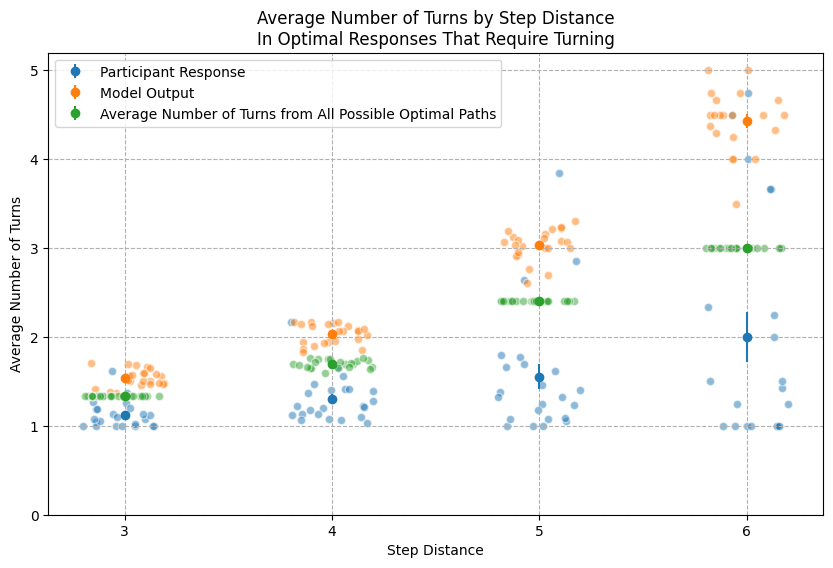

In [40]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from collections import deque

def count_turns(coords):
    turns = 0
    for i in range(1, len(coords) - 1):
        prev_direction = (coords[i][0] - coords[i - 1][0], coords[i][1] - coords[i - 1][1])
        next_direction = (coords[i + 1][0] - coords[i][0], coords[i + 1][1] - coords[i][1])
        if prev_direction != next_direction:
            turns += 1
    return turns

def generate_turns(row):
    participant_turn = count_turns(eval(row['path'])) if row['optimal_response'] else np.nan
    model_turn = count_turns(eval(row['output_coords'])) if row['optimality'] else np.nan
    baseline_mean = calculate_baseline_mean(eval(row['start']), eval(row['end']))
    return pd.Series([participant_turn, model_turn, baseline_mean])

def bfs_shortest_paths(start, end, grid_size):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    queue = deque([(start, [start])])
    shortest_paths = []
    shortest_length = float('inf')

    while queue:
        (current, path) = queue.popleft()
        if len(path) > shortest_length:
            break
        if current == end:
            if len(path) < shortest_length:
                shortest_paths = [path]
                shortest_length = len(path)
            elif len(path) == shortest_length:
                shortest_paths.append(path)
        else:
            for d in directions:
                neighbor = (current[0] + d[0], current[1] + d[1])
                if 0 <= neighbor[0] < grid_size and 0 <= neighbor[1] < grid_size and neighbor not in path:
                    queue.append((neighbor, path + [neighbor]))

    return shortest_paths

def calculate_baseline_mean(start, end, grid_size=4):
    shortest_paths = bfs_shortest_paths(tuple(start), tuple(end), grid_size)
    turns = [count_turns(path) for path in shortest_paths]
    return np.mean(turns) if turns else np.nan

folder_path = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData/gpt_neo_dual_mode_v16_1to5_3000_4by4grids_modelling/ModelOutput_24_with_options'  # Replace with your folder path
csv_files = glob.glob(os.path.join(folder_path, 'Subject*_Grid_*.csv'))

summary_data = []

for file in csv_files:
    df = pd.read_csv(file)
    subject_id = os.path.basename(file).split('_')[0]
    
    # Generate turns and filter out rows with 0 turns
    df[['participant_turn', 'model_turn', 'baseline_mean']] = df.apply(generate_turns, axis=1)
    df = df[(df['participant_turn'] > 0) & (df['model_turn'] > 0)]
    
    average_turns = df.groupby('stepDist')[['participant_turn', 'model_turn', 'baseline_mean']].mean().reset_index()
    average_turns['subject_id'] = subject_id
    summary_data.append(average_turns)

summary_df = pd.concat(summary_data)

# Calculate the mean turns at each stepDist for each participant
mean_turns_by_stepDist = summary_df.groupby(['stepDist', 'subject_id'], as_index=False)[['participant_turn', 'model_turn', 'baseline_mean']].mean()

# Drop NaN values before calculating the overall mean and standard error
mean_turns_by_stepDist = mean_turns_by_stepDist.dropna()

# Calculate the overall mean at each stepDist
overall_mean_turns = mean_turns_by_stepDist.groupby('stepDist', as_index=False)[['participant_turn', 'model_turn', 'baseline_mean']].mean()

# Calculate the standard error of the mean at each stepDist based on the number of participants
grouped_by_stepDist = mean_turns_by_stepDist.groupby('stepDist')
overall_sem_turns = grouped_by_stepDist[['participant_turn', 'model_turn', 'baseline_mean']].apply(lambda x: x.std() / np.sqrt(x.count())).reset_index()

# Plot the results
plt.figure(figsize=(10, 6))

# Plotting participant_turn
plt.errorbar(overall_mean_turns['stepDist'], 
             overall_mean_turns['participant_turn'], 
             yerr=overall_sem_turns['participant_turn'], 
             fmt='o', label='Participant Response', color='tab:blue')

# Plotting model_turn
plt.errorbar(overall_mean_turns['stepDist'], 
             overall_mean_turns['model_turn'], 
             yerr=overall_sem_turns['model_turn'], 
             fmt='o', label='Model Output', color='tab:orange')

# Plotting baseline_mean
plt.errorbar(overall_mean_turns['stepDist'], 
             overall_mean_turns['baseline_mean'], 
             yerr=overall_sem_turns['baseline_mean'], 
             fmt='o', label='Average Number of Turns from All Possible Optimal Paths', color='tab:green')

# Add scatter of individual data points with jitter
jitter_strength = 0.2

for stepDist in overall_mean_turns['stepDist']:
    individual_data = mean_turns_by_stepDist[mean_turns_by_stepDist['stepDist'] == stepDist]
    plt.scatter(np.full_like(individual_data['participant_turn'], stepDist) + np.random.uniform(-jitter_strength, jitter_strength, len(individual_data)), 
                individual_data['participant_turn'], alpha=0.5, color='tab:blue', edgecolors='w', label='_nolegend_')
    plt.scatter(np.full_like(individual_data['model_turn'], stepDist) + np.random.uniform(-jitter_strength, jitter_strength, len(individual_data)), 
                individual_data['model_turn'], alpha=0.5, color='tab:orange', edgecolors='w', label='_nolegend_')
    plt.scatter(np.full_like(individual_data['baseline_mean'], stepDist) + np.random.uniform(-jitter_strength, jitter_strength, len(individual_data)), 
                individual_data['baseline_mean'], alpha=0.5, color='tab:green', edgecolors='w', label='_nolegend_')

# Set x-ticks to integers only
plt.xticks(np.arange(int(overall_mean_turns['stepDist'].min()), 
                     int(overall_mean_turns['stepDist'].max()) + 1))

# Set y-ticks to integers only and start from 0
plt.yticks(np.arange(0, int(overall_mean_turns[['participant_turn', 'model_turn', 'baseline_mean']].max().max()) + 1.5))

plt.xlabel('Step Distance')
plt.ylabel('Average Number of Turns')
plt.title('Average Number of Turns by Step Distance\nIn Optimal Responses That Require Turning')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

#### Error Pattern

heatmap for each start-end location pair (sort by coordinate values)

/var/folders/8m/tvf94f_51v97kgzt4g5hs2g80000gn/T/ipykernel_34468/678543462.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.7, 0.98])  # [left, bottom, right, top]


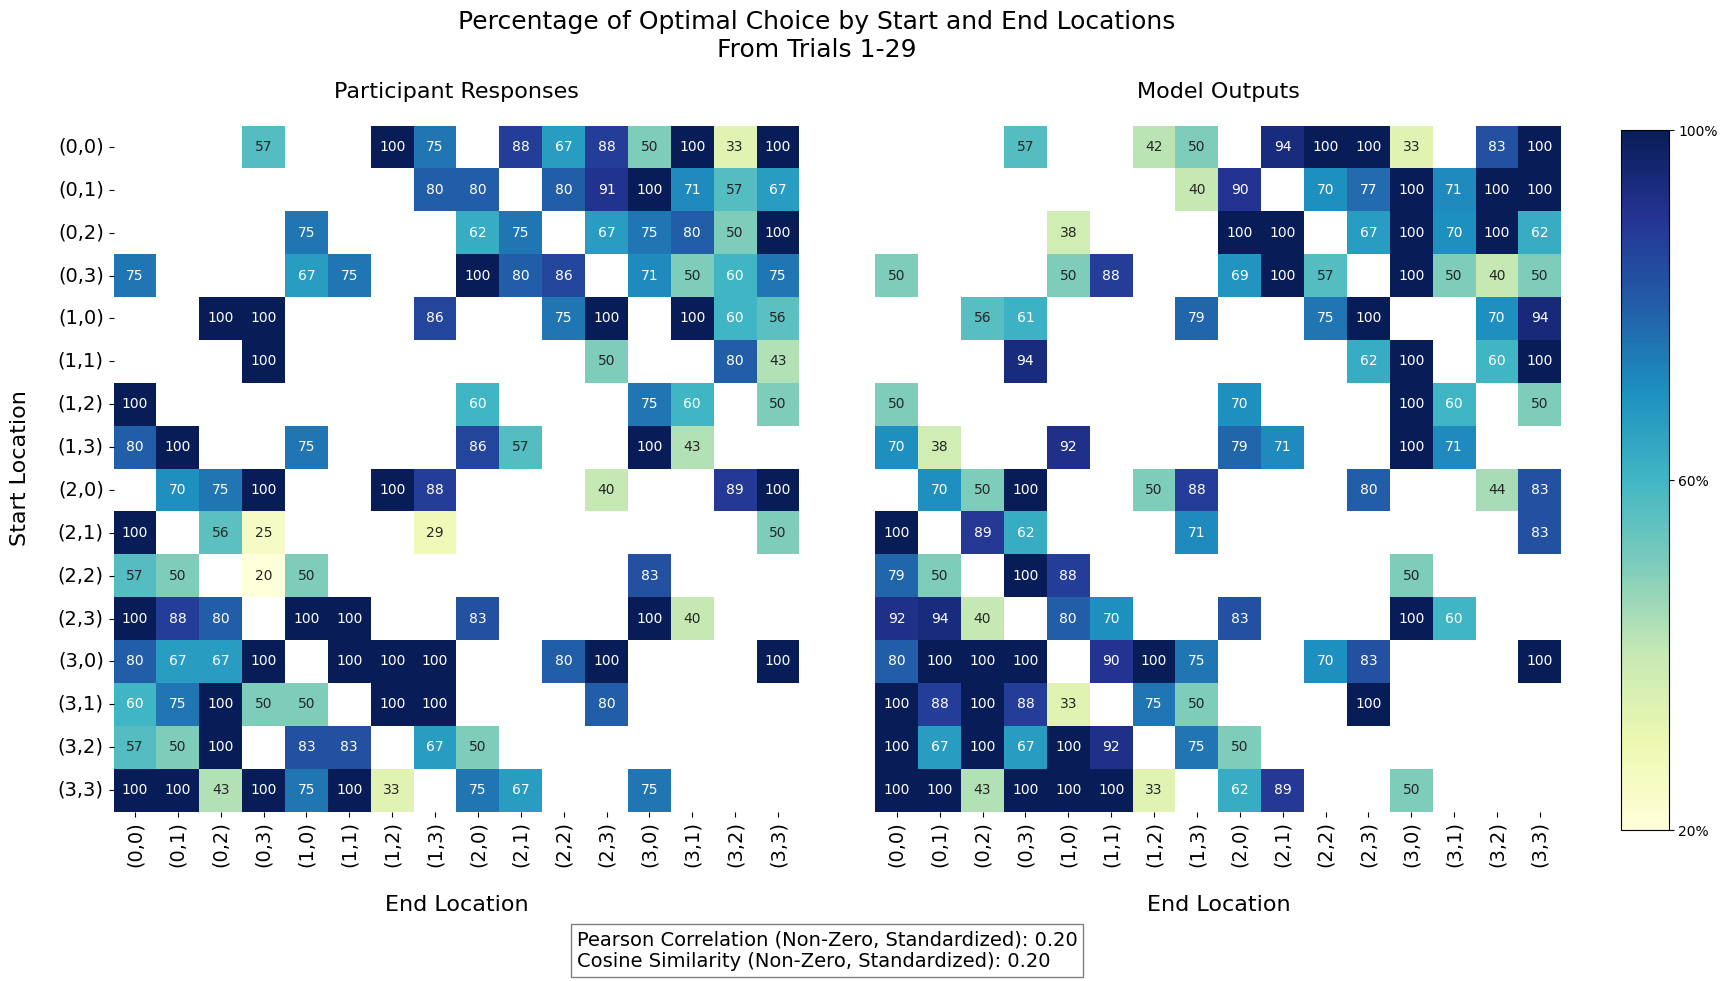

In [45]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler

def compute_optimal_response_percentage(df, optimality_column):
    grid_size = 4
    optimal_responses = np.zeros((grid_size, grid_size, grid_size, grid_size))

    for index, row in df.iterrows():
        start = tuple(map(int, row['start'][1:-1].split(',')))
        end = tuple(map(int, row['end'][1:-1].split(',')))
        optimal_responses[start[0], start[1], end[0], end[1]] += row[optimality_column]

    counts = np.zeros((grid_size, grid_size, grid_size, grid_size))
    for index, row in df.iterrows():
        start = tuple(map(int, row['start'][1:-1].split(',')))
        end = tuple(map(int, row['end'][1:-1].split(',')))
        counts[start[0], start[1], end[0], end[1]] += 1

    percentage_optimal = np.divide(optimal_responses, counts, out=np.zeros_like(optimal_responses), where=counts!=0) * 100
    return percentage_optimal

def load_data(folder_path):
    all_data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

def plot_heatmap(data1, data2, grid_size=4, pearson_corr=None, cosine_sim=None):
    heatmap_data1 = np.zeros((grid_size * grid_size, grid_size * grid_size))
    heatmap_data2 = np.zeros((grid_size * grid_size, grid_size * grid_size))

    for start_x in range(grid_size):
        for start_y in range(grid_size):
            for end_x in range(grid_size):
                for end_y in range(grid_size):
                    start_index = start_x * grid_size + start_y
                    end_index = end_x * grid_size + end_y
                    heatmap_data1[start_index, end_index] = data1[start_x, start_y, end_x, end_y]
                    heatmap_data2[start_index, end_index] = data2[start_x, start_y, end_x, end_y]

    # Mask zero values
    mask1 = (heatmap_data1 == 0)
    mask2 = (heatmap_data2 == 0)

    non_zero_data1 = heatmap_data1[~mask1]
    non_zero_data2 = heatmap_data2[~mask2]

    min_val = min(np.min(non_zero_data1), np.min(non_zero_data2))
    max_val = max(np.max(non_zero_data1), np.max(non_zero_data2))

    x_labels = [f"({x},{y})" for x in range(grid_size) for y in range(grid_size)]
    y_labels = [f"({x},{y})" for x in range(grid_size) for y in range(grid_size)]

    fig, axs = plt.subplots(1, 2, figsize=(24, 10))

    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    cmap.set_under('grey')

    sns.heatmap(heatmap_data1, annot=True, fmt=".0f", cmap=cmap, xticklabels=x_labels, yticklabels=y_labels, vmin=min_val, vmax=max_val, mask=mask1, cbar=False, square=True, ax=axs[0])
    sns.heatmap(heatmap_data2, annot=True, fmt=".0f", cmap=cmap, xticklabels=x_labels, yticklabels=False, vmin=min_val, vmax=max_val, mask=mask2, cbar=False, square=True, ax=axs[1])

    axs[0].set_title("Participant Responses", fontsize=16, pad=20)
    axs[0].set_xlabel("End Location", fontsize=16, labelpad=20)
    axs[0].set_ylabel("Start Location", fontsize=16, labelpad=20)
    axs[0].tick_params(axis='x', rotation=90, labelsize=14)
    axs[0].tick_params(axis='y', rotation=0, labelsize=14)

    axs[1].set_title("Model Outputs", fontsize=16, pad=20)
    axs[1].set_xlabel("End Location", fontsize=16, labelpad=20)
    axs[1].tick_params(axis='x', rotation=90, labelsize=14)
    axs[1].tick_params(axis='y', rotation=0, labelsize=14)

    # Manually set the position of the color bar
    cbar_ax = fig.add_axes([0.69, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(axs[0].collections[0], cax=cbar_ax)
    cbar.set_ticks([min_val, (min_val + max_val) / 2, max_val])
    cbar.set_ticklabels([f'{min_val:.0f}%', f'{(min_val + max_val) / 2:.0f}%', f'{max_val:.0f}%'])

    # Add similarity measures as text annotations
    if pearson_corr is not None and cosine_sim is not None:
        textstr = f'Pearson Correlation (Non-Zero, Standardized): {pearson_corr:.2f}\nCosine Similarity (Non-Zero, Standardized): {cosine_sim:.2f}'
        fig.text(0.255, 0.05, textstr, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.suptitle("Percentage of Optimal Choice by Start and End Locations\nFrom Trials 1-29", fontsize=18, x=0.355, y=0.97, ha='center')
    plt.tight_layout(rect=[0, 0.05, 0.7, 0.98])  # [left, bottom, right, top]

def compute_similarity(matrix1, matrix2, standardize=False):
    # Flatten the matrices
    vector1 = matrix1.flatten()
    vector2 = matrix2.flatten()

    # Create a mask for non-zero elements in both vectors
    non_zero_mask = (vector1 != 0) & (vector2 != 0)
    
    # Apply the mask to filter out zero elements
    filtered_vector1 = vector1[non_zero_mask]
    filtered_vector2 = vector2[non_zero_mask]

    # Ensure there are non-zero elements to compare
    if len(filtered_vector1) == 0 or len(filtered_vector2) == 0:
        return None, None, None, None, vector1, vector2, filtered_vector1, filtered_vector2

    # Standardize the vectors if required
    if standardize:
        scaler = StandardScaler()
        filtered_vector1 = scaler.fit_transform(filtered_vector1.reshape(-1, 1)).flatten()
        filtered_vector2 = scaler.fit_transform(filtered_vector2.reshape(-1, 1)).flatten()

    # Compute Pearson correlation and cosine similarity after exclusion
    pearson_corr_non_zero, _ = pearsonr(filtered_vector1, filtered_vector2)
    cosine_sim_non_zero = 1 - cosine(filtered_vector1, filtered_vector2)  # cosine function returns a distance, so subtract from 1
    
    return pearson_corr_non_zero, cosine_sim_non_zero, vector1, vector2, filtered_vector1, filtered_vector2

def main():
    folder_path1 = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData/PreprocessedSubjectData'
    folder_path2 = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData/ModelOutput_24_with_options'
    
    df1 = load_data(folder_path1)
    df2 = load_data(folder_path2)
    
    df1 = df1[df1['trial'] < 30]  # Filter trials 30-100
    df2 = df2[df2['trial'] < 30]  # Filter trials 30-100

    percentage_optimal1 = compute_optimal_response_percentage(df1, 'optimal_response')
    percentage_optimal2 = compute_optimal_response_percentage(df2, 'optimality')

    pearson_corr_non_zero, cosine_sim_non_zero, vector1, vector2, filtered_vector1, filtered_vector2 = compute_similarity(percentage_optimal1, percentage_optimal2, standardize=True)

    plot_heatmap(percentage_optimal1, percentage_optimal2, pearson_corr=pearson_corr_non_zero, cosine_sim=cosine_sim_non_zero)
    
    if not pearson_corr_non_zero is not None and cosine_sim_non_zero is not None:
        print("Not enough non-zero elements to compute similarity.")

    # Save the combined plot as a PNG file in folder_path
    folder_path = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData'
    plt.savefig(os.path.join(folder_path, 'optimal_response_comparison_heatmap_by_coordinates_1_29.png'))
    plt.show()

main()


/var/folders/8m/tvf94f_51v97kgzt4g5hs2g80000gn/T/ipykernel_34468/2348977623.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.7, 0.98])  # [left, bottom, right, top]


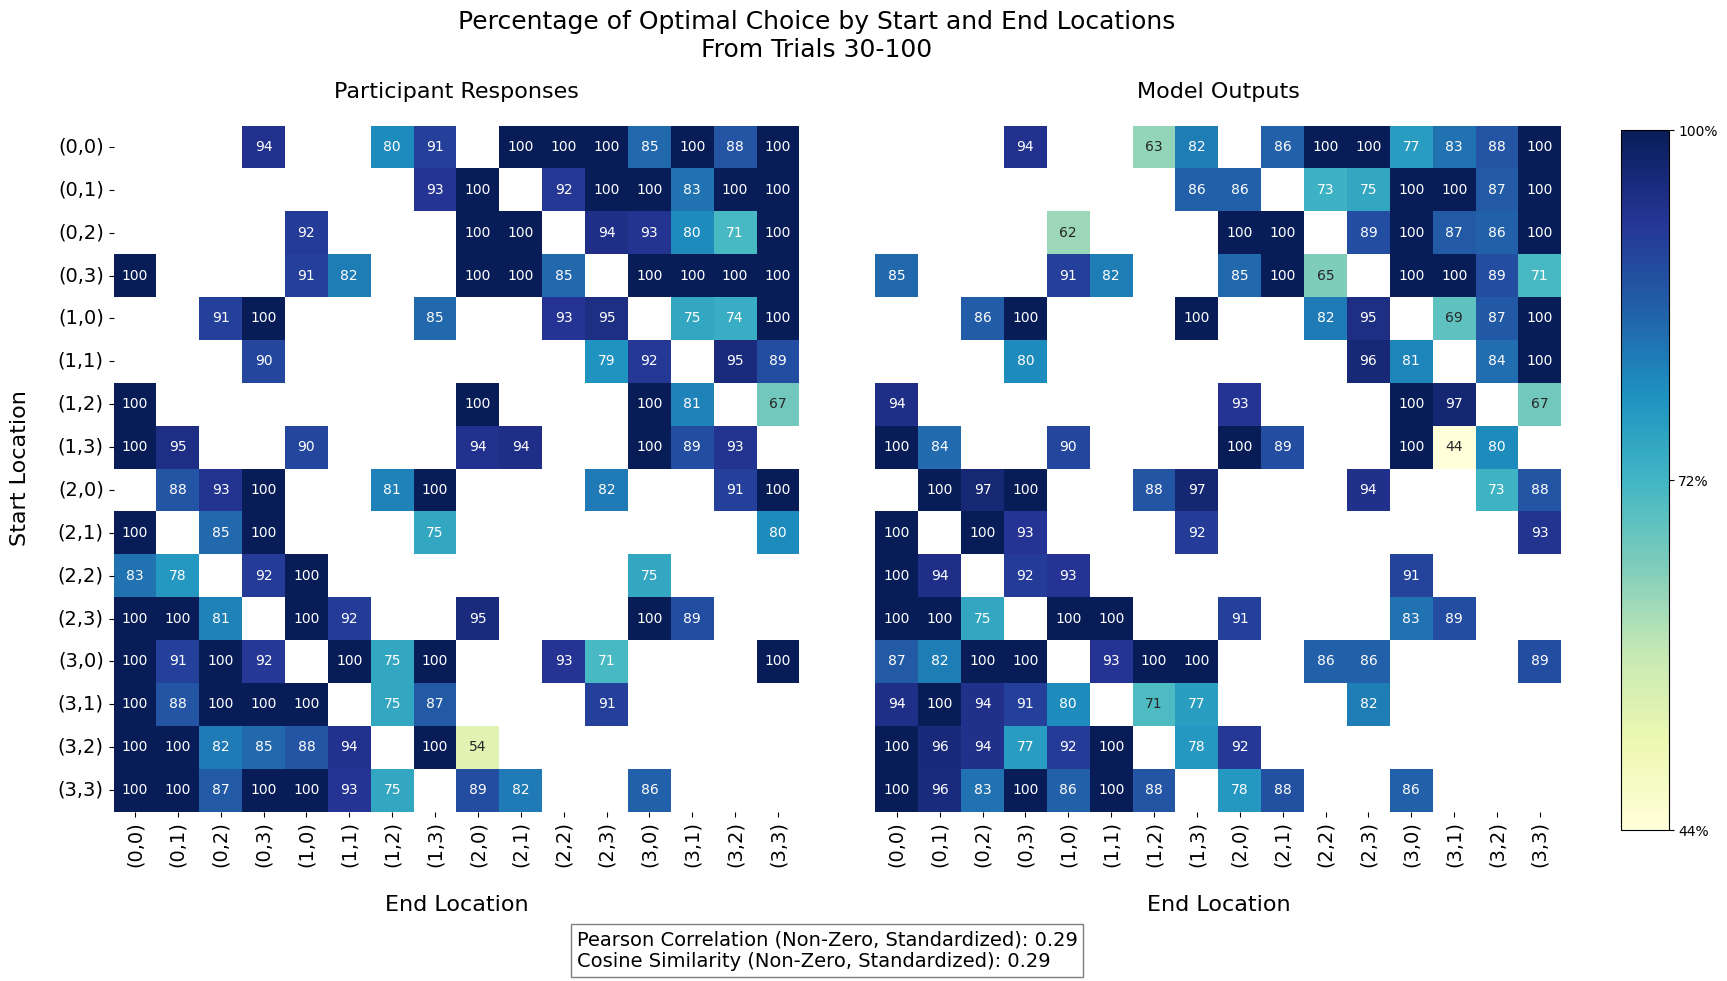

In [46]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler

def compute_optimal_response_percentage(df, optimality_column):
    grid_size = 4
    optimal_responses = np.zeros((grid_size, grid_size, grid_size, grid_size))

    for index, row in df.iterrows():
        start = tuple(map(int, row['start'][1:-1].split(',')))
        end = tuple(map(int, row['end'][1:-1].split(',')))
        optimal_responses[start[0], start[1], end[0], end[1]] += row[optimality_column]

    counts = np.zeros((grid_size, grid_size, grid_size, grid_size))
    for index, row in df.iterrows():
        start = tuple(map(int, row['start'][1:-1].split(',')))
        end = tuple(map(int, row['end'][1:-1].split(',')))
        counts[start[0], start[1], end[0], end[1]] += 1

    percentage_optimal = np.divide(optimal_responses, counts, out=np.zeros_like(optimal_responses), where=counts!=0) * 100
    return percentage_optimal

def load_data(folder_path):
    all_data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

def plot_heatmap(data1, data2, grid_size=4, pearson_corr=None, cosine_sim=None):
    heatmap_data1 = np.zeros((grid_size * grid_size, grid_size * grid_size))
    heatmap_data2 = np.zeros((grid_size * grid_size, grid_size * grid_size))

    for start_x in range(grid_size):
        for start_y in range(grid_size):
            for end_x in range(grid_size):
                for end_y in range(grid_size):
                    start_index = start_x * grid_size + start_y
                    end_index = end_x * grid_size + end_y
                    heatmap_data1[start_index, end_index] = data1[start_x, start_y, end_x, end_y]
                    heatmap_data2[start_index, end_index] = data2[start_x, start_y, end_x, end_y]

    # Mask zero values
    mask1 = (heatmap_data1 == 0)
    mask2 = (heatmap_data2 == 0)

    non_zero_data1 = heatmap_data1[~mask1]
    non_zero_data2 = heatmap_data2[~mask2]

    min_val = min(np.min(non_zero_data1), np.min(non_zero_data2))
    max_val = max(np.max(non_zero_data1), np.max(non_zero_data2))

    x_labels = [f"({x},{y})" for x in range(grid_size) for y in range(grid_size)]
    y_labels = [f"({x},{y})" for x in range(grid_size) for y in range(grid_size)]

    fig, axs = plt.subplots(1, 2, figsize=(24, 10))

    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    cmap.set_under('grey')

    sns.heatmap(heatmap_data1, annot=True, fmt=".0f", cmap=cmap, xticklabels=x_labels, yticklabels=y_labels, vmin=min_val, vmax=max_val, mask=mask1, cbar=False, square=True, ax=axs[0])
    sns.heatmap(heatmap_data2, annot=True, fmt=".0f", cmap=cmap, xticklabels=x_labels, yticklabels=False, vmin=min_val, vmax=max_val, mask=mask2, cbar=False, square=True, ax=axs[1])

    axs[0].set_title("Participant Responses", fontsize=16, pad=20)
    axs[0].set_xlabel("End Location", fontsize=16, labelpad=20)
    axs[0].set_ylabel("Start Location", fontsize=16, labelpad=20)
    axs[0].tick_params(axis='x', rotation=90, labelsize=14)
    axs[0].tick_params(axis='y', rotation=0, labelsize=14)

    axs[1].set_title("Model Outputs", fontsize=16, pad=20)
    axs[1].set_xlabel("End Location", fontsize=16, labelpad=20)
    axs[1].tick_params(axis='x', rotation=90, labelsize=14)
    axs[1].tick_params(axis='y', rotation=0, labelsize=14)

    # Manually set the position of the color bar
    cbar_ax = fig.add_axes([0.69, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(axs[0].collections[0], cax=cbar_ax)
    cbar.set_ticks([min_val, (min_val + max_val) / 2, max_val])
    cbar.set_ticklabels([f'{min_val:.0f}%', f'{(min_val + max_val) / 2:.0f}%', f'{max_val:.0f}%'])

    # Add similarity measures as text annotations
    if pearson_corr is not None and cosine_sim is not None:
        textstr = f'Pearson Correlation (Non-Zero, Standardized): {pearson_corr:.2f}\nCosine Similarity (Non-Zero, Standardized): {cosine_sim:.2f}'
        fig.text(0.255, 0.05, textstr, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.suptitle("Percentage of Optimal Choice by Start and End Locations\nFrom Trials 30-100", fontsize=18, x=0.355, y=0.97, ha='center')
    plt.tight_layout(rect=[0, 0.05, 0.7, 0.98])  # [left, bottom, right, top]

def compute_similarity(matrix1, matrix2, standardize=False):
    # Flatten the matrices
    vector1 = matrix1.flatten()
    vector2 = matrix2.flatten()

    # Create a mask for non-zero elements in both vectors
    non_zero_mask = (vector1 != 0) & (vector2 != 0)
    
    # Apply the mask to filter out zero elements
    filtered_vector1 = vector1[non_zero_mask]
    filtered_vector2 = vector2[non_zero_mask]

    # Ensure there are non-zero elements to compare
    if len(filtered_vector1) == 0 or len(filtered_vector2) == 0:
        return None, None, None, None, vector1, vector2, filtered_vector1, filtered_vector2

    # Standardize the vectors if required
    if standardize:
        scaler = StandardScaler()
        filtered_vector1 = scaler.fit_transform(filtered_vector1.reshape(-1, 1)).flatten()
        filtered_vector2 = scaler.fit_transform(filtered_vector2.reshape(-1, 1)).flatten()

    # Compute Pearson correlation and cosine similarity after exclusion
    pearson_corr_non_zero, _ = pearsonr(filtered_vector1, filtered_vector2)
    cosine_sim_non_zero = 1 - cosine(filtered_vector1, filtered_vector2)  # cosine function returns a distance, so subtract from 1
    
    return pearson_corr_non_zero, cosine_sim_non_zero, vector1, vector2, filtered_vector1, filtered_vector2

def main():
    folder_path1 = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData/PreprocessedSubjectData'
    folder_path2 = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData/ModelOutput_24_with_options'
    
    df1 = load_data(folder_path1)
    df2 = load_data(folder_path2)
    
    df1 = df1[(df1['trial'] >= 30) & (df1['trial'] <= 100)]  # Filter trials 30-100
    df2 = df2[(df2['trial'] >= 30) & (df2['trial'] <= 100)]  # Filter trials 30-100

    percentage_optimal1 = compute_optimal_response_percentage(df1, 'optimal_response')
    percentage_optimal2 = compute_optimal_response_percentage(df2, 'optimality')

    pearson_corr_non_zero, cosine_sim_non_zero, vector1, vector2, filtered_vector1, filtered_vector2 = compute_similarity(percentage_optimal1, percentage_optimal2, standardize=True)

    plot_heatmap(percentage_optimal1, percentage_optimal2, pearson_corr=pearson_corr_non_zero, cosine_sim=cosine_sim_non_zero)
    
    if not pearson_corr_non_zero is not None and cosine_sim_non_zero is not None:
        print("Not enough non-zero elements to compute similarity.")

    # Save the combined plot as a PNG file in folder_path
    folder_path = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData'
    plt.savefig(os.path.join(folder_path, 'optimal_response_comparison_heatmap_by_coordinates_30_100.png'))
    plt.show()

main()


heatmap for each start-end location pair (sort by location type)

/var/folders/8m/tvf94f_51v97kgzt4g5hs2g80000gn/T/ipykernel_34468/1614879730.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.7, 0.98])  # [left, bottom, right, top]


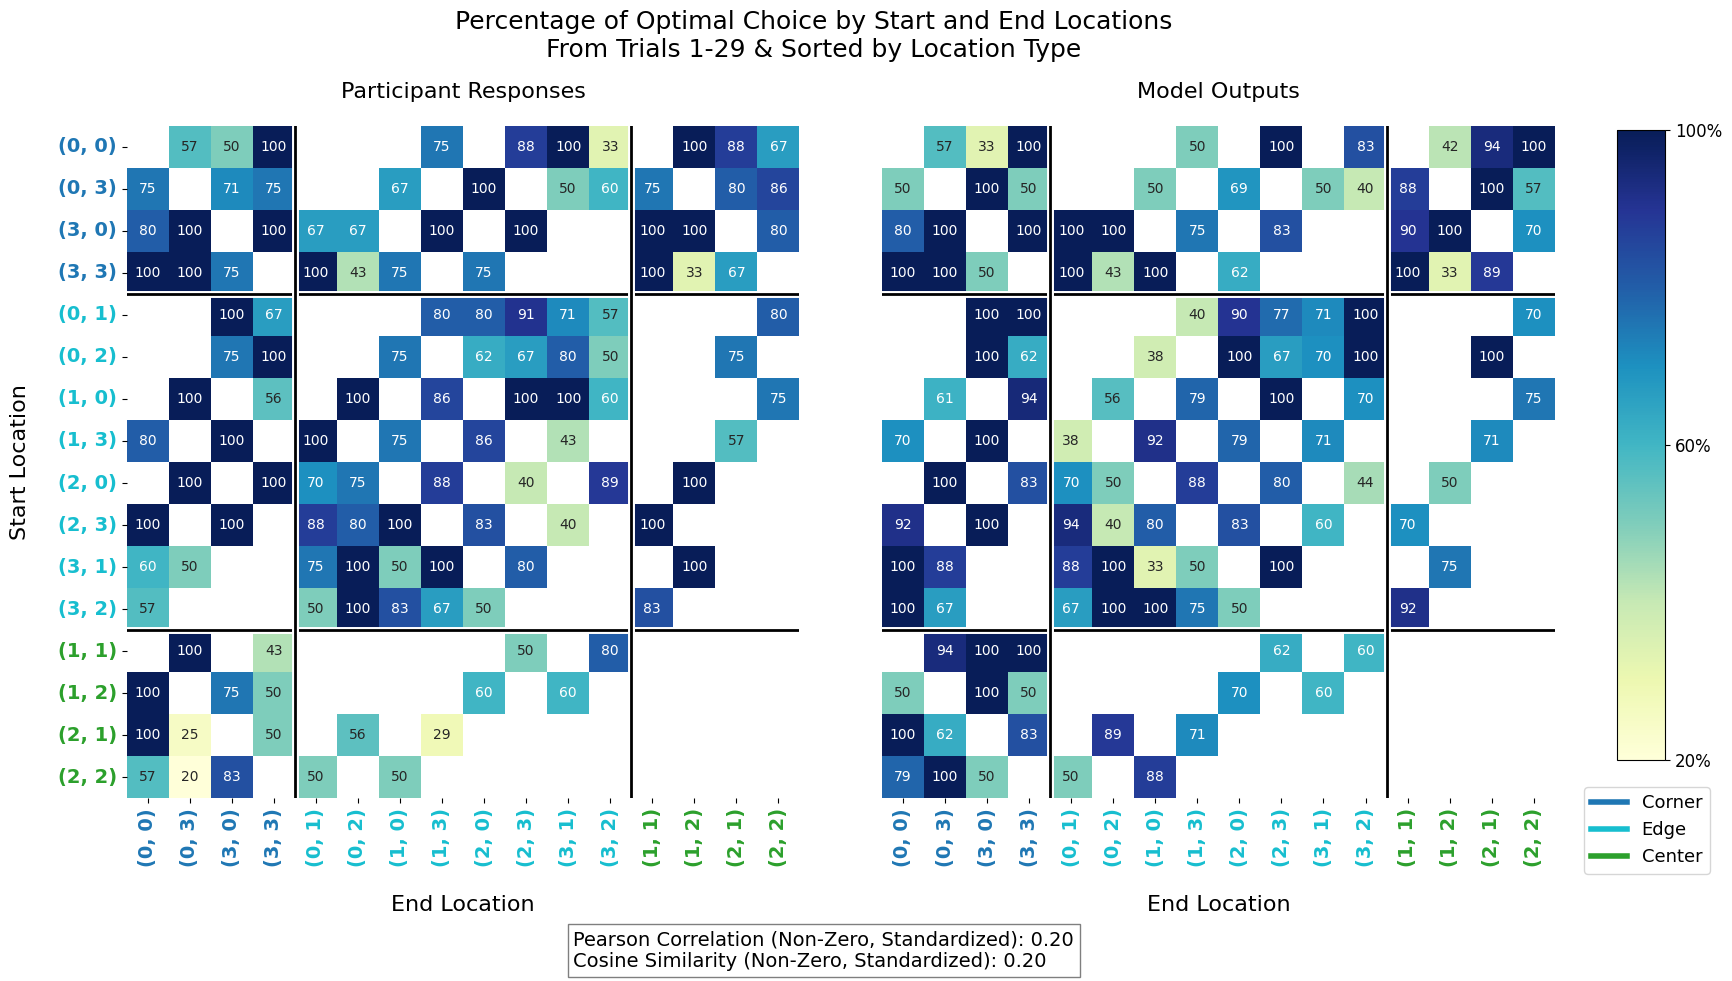

In [47]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler

def compute_optimal_response_percentage(df, optimality_column):
    grid_size = 4
    optimal_responses = np.zeros((grid_size, grid_size, grid_size, grid_size))

    for index, row in df.iterrows():
        start = tuple(map(int, row['start'][1:-1].split(',')))
        end = tuple(map(int, row['end'][1:-1].split(',')))
        optimal_responses[start[0], start[1], end[0], end[1]] += row[optimality_column]

    counts = np.zeros((grid_size, grid_size, grid_size, grid_size))
    for index, row in df.iterrows():
        start = tuple(map(int, row['start'][1:-1].split(',')))
        end = tuple(map(int, row['end'][1:-1].split(',')))
        counts[start[0], start[1], end[0], end[1]] += 1

    percentage_optimal = np.divide(optimal_responses, counts, out=np.zeros_like(optimal_responses), where=counts!=0) * 100
    return percentage_optimal

def load_data(folder_path):
    all_data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

def group_coordinates_by_type(grid_size):
    corners = [(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)]
    centers = [(i, j) for i in range(1, grid_size-1) for j in range(1, grid_size-1)]
    edges = [(i, 0) for i in range(1, grid_size-1)] + [(i, grid_size-1) for i in range(1, grid_size-1)] + [(0, j) for j in range(1, grid_size-1)] + [(grid_size-1, j) for j in range(1, grid_size-1)]
    
    sorted_coords = corners + sorted(edges) + sorted(centers)
    return sorted_coords

def compute_similarity(matrix1, matrix2, standardize=False):
    # Flatten the matrices
    vector1 = matrix1.flatten()
    vector2 = matrix2.flatten()

    # Create a mask for non-zero elements in both vectors
    non_zero_mask = (vector1 != 0) & (vector2 != 0)
    
    # Apply the mask to filter out zero elements
    filtered_vector1 = vector1[non_zero_mask]
    filtered_vector2 = vector2[non_zero_mask]

    # Ensure there are non-zero elements to compare
    if len(filtered_vector1) == 0 or len(filtered_vector2) == 0:
        return None, None, None, None, vector1, vector2, filtered_vector1, filtered_vector2

    # Standardize the vectors if required
    if standardize:
        scaler = StandardScaler()
        filtered_vector1 = scaler.fit_transform(filtered_vector1.reshape(-1, 1)).flatten()
        filtered_vector2 = scaler.fit_transform(filtered_vector2.reshape(-1, 1)).flatten()

    # Compute Pearson correlation and cosine similarity after exclusion
    pearson_corr_non_zero, _ = pearsonr(filtered_vector1, filtered_vector2)
    cosine_sim_non_zero = 1 - cosine(filtered_vector1, filtered_vector2)  # cosine function returns a distance, so subtract from 1
    
    return pearson_corr_non_zero, cosine_sim_non_zero, vector1, vector2, filtered_vector1, filtered_vector2

def plot_heatmap(data1, data2, grid_size=4, pearson_corr=None, cosine_sim=None):
    sorted_coords = group_coordinates_by_type(grid_size)
    coord_index = {coord: idx for idx, coord in enumerate(sorted_coords)}

    heatmap_data1 = np.zeros((grid_size * grid_size, grid_size * grid_size))
    heatmap_data2 = np.zeros((grid_size * grid_size, grid_size * grid_size))

    for start_x in range(grid_size):
        for start_y in range(grid_size):
            for end_x in range(grid_size):
                for end_y in range(grid_size):
                    start_index = coord_index[(start_x, start_y)]
                    end_index = coord_index[(end_x, end_y)]
                    heatmap_data1[start_index, end_index] = data1[start_x, start_y, end_x, end_y]
                    heatmap_data2[start_index, end_index] = data2[start_x, start_y, end_x, end_y]

    # Mask zero values
    mask1 = (heatmap_data1 == 0)
    mask2 = (heatmap_data2 == 0)

    non_zero_data1 = heatmap_data1[~mask1]
    non_zero_data2 = heatmap_data2[~mask2]

    min_val = min(np.min(non_zero_data1), np.min(non_zero_data2))
    max_val = max(np.max(non_zero_data1), np.max(non_zero_data2))

    x_labels = [f"{coord}" for coord in sorted_coords]
    y_labels = [f"{coord}" for coord in sorted_coords]

    fig, axs = plt.subplots(1, 2, figsize=(24, 10))

    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    cmap.set_under('grey')

    sns.heatmap(heatmap_data1, annot=True, fmt=".0f", cmap=cmap, xticklabels=x_labels, yticklabels=y_labels, vmin=min_val, vmax=max_val, mask=mask1, cbar=False, square=True, ax=axs[0])
    sns.heatmap(heatmap_data2, annot=True, fmt=".0f", cmap=cmap, xticklabels=x_labels, yticklabels=False, vmin=min_val, vmax=max_val, mask=mask2, cbar=False, square=True, ax=axs[1])

    axs[0].set_title("Participant Responses", fontsize=16, pad=20)
    axs[0].set_xlabel("End Location", fontsize=16, labelpad=20)
    axs[0].set_ylabel("Start Location", fontsize=16, labelpad=20)
    axs[0].tick_params(axis='x', rotation=90, labelsize=14)
    axs[0].tick_params(axis='y', rotation=0, labelsize=14)

    axs[1].set_title("Model Outputs", fontsize=16, pad=20)
    axs[1].set_xlabel("End Location", fontsize=16, labelpad=20)
    axs[1].tick_params(axis='x', rotation=90, labelsize=14)
    axs[1].tick_params(axis='y', rotation=0, labelsize=14)

    # Define colors for each group
    color_map = {
        'corner': 'tab:blue',
        'edge': 'tab:cyan',
        'center': 'tab:green'
    }
    
    # Apply colors to x and y labels
    def get_label_color(coord):
        if coord in [(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)]:
            return color_map['corner']
        elif coord[0] == 0 or coord[0] == grid_size-1 or coord[1] == 0 or coord[1] == grid_size-1:
            return color_map['edge']
        else:
            return color_map['center']

    for tick in axs[0].get_xticklabels():
        tick.set_color(get_label_color(eval(tick.get_text())))
        tick.set_fontweight('heavy')
    for tick in axs[0].get_yticklabels():
        tick.set_color(get_label_color(eval(tick.get_text())))
        tick.set_fontweight('heavy')
    for tick in axs[1].get_xticklabels():
        tick.set_color(get_label_color(eval(tick.get_text())))
        tick.set_fontweight('heavy')

    # Manually set the position of the color bar
    cbar_ax = fig.add_axes([0.69, 0.22, 0.02, 0.63])  # [left, bottom, width, height]
    cbar = fig.colorbar(axs[0].collections[0], cax=cbar_ax)
    cbar.set_ticks([min_val, (min_val + max_val) / 2, max_val])
    cbar.set_ticklabels([f'{min_val:.0f}%', f'{(min_val + max_val) / 2:.0f}%', f'{max_val:.0f}%'], fontsize=12)

    # Add similarity measures as text annotations
    if pearson_corr is not None and cosine_sim is not None:
        textstr = f'Pearson Correlation (Non-Zero, Standardized): {pearson_corr:.2f}\nCosine Similarity (Non-Zero, Standardized): {cosine_sim:.2f}'
        fig.text(0.255, 0.05, textstr, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.suptitle("Percentage of Optimal Choice by Start and End Locations\nFrom Trials 1-29 & Sorted by Location Type", fontsize=18, x=0.355, y=0.97, ha='center')
    plt.tight_layout(rect=[0, 0.05, 0.7, 0.98])  # [left, bottom, right, top]

    # Add a legend for the colors
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='tab:blue', lw=4, label='Corner'),
        Line2D([0], [0], color='tab:cyan', lw=4, label='Edge'),
        Line2D([0], [0], color='tab:green', lw=4, label='Center')
    ]
    axs[1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.03, 0.03), fontsize=13)
    
    # Add lines to separate boundaries of different location types
    num_corners = len([(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)])
    num_edges = len([(i, 0) for i in range(1, grid_size-1)] + [(i, grid_size-1) for i in range(1, grid_size-1)] + [(0, j) for j in range(1, grid_size-1)] + [(grid_size-1, j) for j in range(1, grid_size-1)])
    
    corner_index = num_corners
    edge_index = corner_index + num_edges

    for ax in axs:
        # Draw horizontal lines
        ax.axhline(y=corner_index, color='white', linewidth=5)
        ax.axhline(y=corner_index, color='black', linewidth=2)
        ax.axhline(y=edge_index, color='white', linewidth=5)
        ax.axhline(y=edge_index, color='black', linewidth=2)
        # Draw vertical lines
        ax.axvline(x=corner_index, color='white', linewidth=5)
        ax.axvline(x=corner_index, color='black', linewidth=2)
        ax.axvline(x=edge_index, color='white', linewidth=5)
        ax.axvline(x=edge_index, color='black', linewidth=2)

def main():
    folder_path1 = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData/PreprocessedSubjectData'
    folder_path2 = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData/ModelOutput_24_with_options'
    
    df1 = load_data(folder_path1)
    df2 = load_data(folder_path2)
    
    df1 = df1[df1['trial'] < 30]  # Filter trials 30-100
    df2 = df2[df2['trial'] < 30]  # Filter trials 30-100

    percentage_optimal1 = compute_optimal_response_percentage(df1, 'optimal_response')
    percentage_optimal2 = compute_optimal_response_percentage(df2, 'optimality')

    pearson_corr_non_zero, cosine_sim_non_zero, vector1, vector2, filtered_vector1, filtered_vector2 = compute_similarity(percentage_optimal1, percentage_optimal2, standardize=True)

    plot_heatmap(percentage_optimal1, percentage_optimal2, grid_size=4, pearson_corr=pearson_corr_non_zero, cosine_sim=cosine_sim_non_zero)
    
    if pearson_corr_non_zero is None or cosine_sim_non_zero is None:
        print("Not enough non-zero elements to compute similarity.")

    # Save the combined plot as a PNG file in folder_path
    folder_path = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData'
    plt.savefig(os.path.join(folder_path, 'optimal_response_comparison_heatmap_by_location_type_1_29.png'))
    plt.show()

main()


/var/folders/8m/tvf94f_51v97kgzt4g5hs2g80000gn/T/ipykernel_34468/2193788772.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.7, 0.98])  # [left, bottom, right, top]


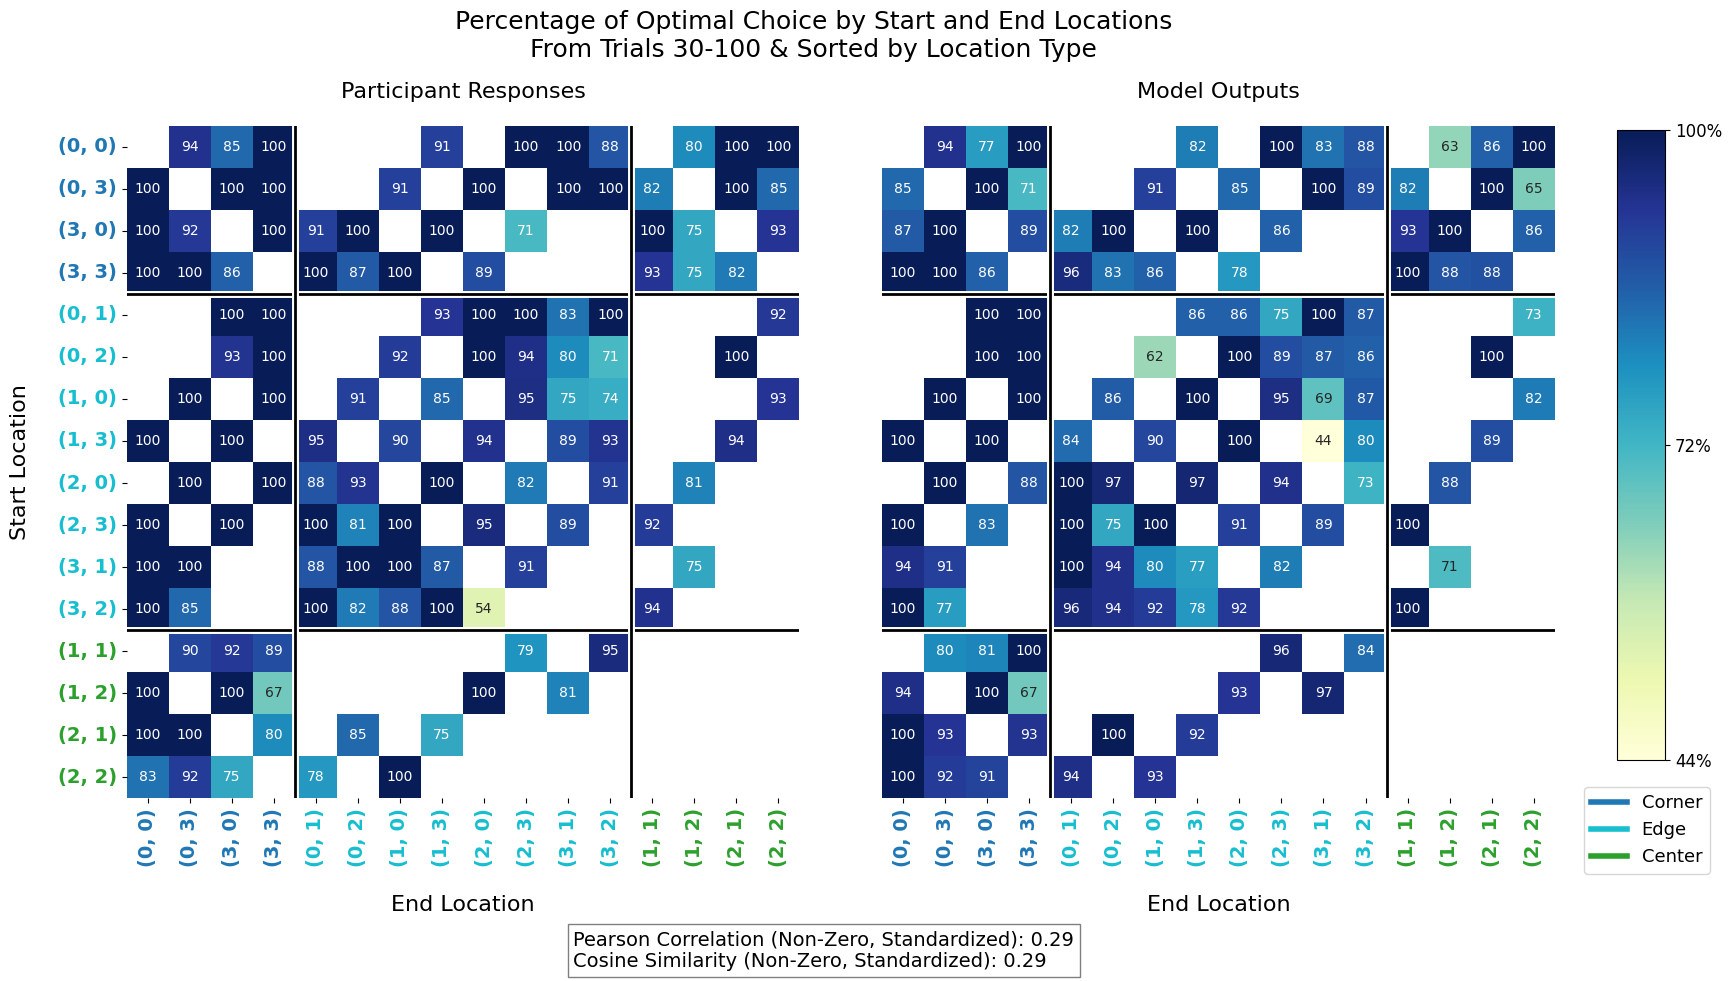

In [48]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler

def compute_optimal_response_percentage(df, optimality_column):
    grid_size = 4
    optimal_responses = np.zeros((grid_size, grid_size, grid_size, grid_size))

    for index, row in df.iterrows():
        start = tuple(map(int, row['start'][1:-1].split(',')))
        end = tuple(map(int, row['end'][1:-1].split(',')))
        optimal_responses[start[0], start[1], end[0], end[1]] += row[optimality_column]

    counts = np.zeros((grid_size, grid_size, grid_size, grid_size))
    for index, row in df.iterrows():
        start = tuple(map(int, row['start'][1:-1].split(',')))
        end = tuple(map(int, row['end'][1:-1].split(',')))
        counts[start[0], start[1], end[0], end[1]] += 1

    percentage_optimal = np.divide(optimal_responses, counts, out=np.zeros_like(optimal_responses), where=counts!=0) * 100
    return percentage_optimal

def load_data(folder_path):
    all_data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

def group_coordinates_by_type(grid_size):
    corners = [(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)]
    centers = [(i, j) for i in range(1, grid_size-1) for j in range(1, grid_size-1)]
    edges = [(i, 0) for i in range(1, grid_size-1)] + [(i, grid_size-1) for i in range(1, grid_size-1)] + [(0, j) for j in range(1, grid_size-1)] + [(grid_size-1, j) for j in range(1, grid_size-1)]
    
    sorted_coords = corners + sorted(edges) + sorted(centers)
    return sorted_coords

def compute_similarity(matrix1, matrix2, standardize=False):
    # Flatten the matrices
    vector1 = matrix1.flatten()
    vector2 = matrix2.flatten()

    # Create a mask for non-zero elements in both vectors
    non_zero_mask = (vector1 != 0) & (vector2 != 0)
    
    # Apply the mask to filter out zero elements
    filtered_vector1 = vector1[non_zero_mask]
    filtered_vector2 = vector2[non_zero_mask]

    # Ensure there are non-zero elements to compare
    if len(filtered_vector1) == 0 or len(filtered_vector2) == 0:
        return None, None, None, None, vector1, vector2, filtered_vector1, filtered_vector2

    # Standardize the vectors if required
    if standardize:
        scaler = StandardScaler()
        filtered_vector1 = scaler.fit_transform(filtered_vector1.reshape(-1, 1)).flatten()
        filtered_vector2 = scaler.fit_transform(filtered_vector2.reshape(-1, 1)).flatten()

    # Compute Pearson correlation and cosine similarity after exclusion
    pearson_corr_non_zero, _ = pearsonr(filtered_vector1, filtered_vector2)
    cosine_sim_non_zero = 1 - cosine(filtered_vector1, filtered_vector2)  # cosine function returns a distance, so subtract from 1
    
    return pearson_corr_non_zero, cosine_sim_non_zero, vector1, vector2, filtered_vector1, filtered_vector2

def plot_heatmap(data1, data2, grid_size=4, pearson_corr=None, cosine_sim=None):
    sorted_coords = group_coordinates_by_type(grid_size)
    coord_index = {coord: idx for idx, coord in enumerate(sorted_coords)}

    heatmap_data1 = np.zeros((grid_size * grid_size, grid_size * grid_size))
    heatmap_data2 = np.zeros((grid_size * grid_size, grid_size * grid_size))

    for start_x in range(grid_size):
        for start_y in range(grid_size):
            for end_x in range(grid_size):
                for end_y in range(grid_size):
                    start_index = coord_index[(start_x, start_y)]
                    end_index = coord_index[(end_x, end_y)]
                    heatmap_data1[start_index, end_index] = data1[start_x, start_y, end_x, end_y]
                    heatmap_data2[start_index, end_index] = data2[start_x, start_y, end_x, end_y]

    # Mask zero values
    mask1 = (heatmap_data1 == 0)
    mask2 = (heatmap_data2 == 0)

    non_zero_data1 = heatmap_data1[~mask1]
    non_zero_data2 = heatmap_data2[~mask2]

    min_val = min(np.min(non_zero_data1), np.min(non_zero_data2))
    max_val = max(np.max(non_zero_data1), np.max(non_zero_data2))

    x_labels = [f"{coord}" for coord in sorted_coords]
    y_labels = [f"{coord}" for coord in sorted_coords]

    fig, axs = plt.subplots(1, 2, figsize=(24, 10))

    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    cmap.set_under('grey')

    sns.heatmap(heatmap_data1, annot=True, fmt=".0f", cmap=cmap, xticklabels=x_labels, yticklabels=y_labels, vmin=min_val, vmax=max_val, mask=mask1, cbar=False, square=True, ax=axs[0])
    sns.heatmap(heatmap_data2, annot=True, fmt=".0f", cmap=cmap, xticklabels=x_labels, yticklabels=False, vmin=min_val, vmax=max_val, mask=mask2, cbar=False, square=True, ax=axs[1])

    axs[0].set_title("Participant Responses", fontsize=16, pad=20)
    axs[0].set_xlabel("End Location", fontsize=16, labelpad=20)
    axs[0].set_ylabel("Start Location", fontsize=16, labelpad=20)
    axs[0].tick_params(axis='x', rotation=90, labelsize=14)
    axs[0].tick_params(axis='y', rotation=0, labelsize=14)

    axs[1].set_title("Model Outputs", fontsize=16, pad=20)
    axs[1].set_xlabel("End Location", fontsize=16, labelpad=20)
    axs[1].tick_params(axis='x', rotation=90, labelsize=14)
    axs[1].tick_params(axis='y', rotation=0, labelsize=14)

    # Define colors for each group
    color_map = {
        'corner': 'tab:blue',
        'edge': 'tab:cyan',
        'center': 'tab:green'
    }
    
    # Apply colors to x and y labels
    def get_label_color(coord):
        if coord in [(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)]:
            return color_map['corner']
        elif coord[0] == 0 or coord[0] == grid_size-1 or coord[1] == 0 or coord[1] == grid_size-1:
            return color_map['edge']
        else:
            return color_map['center']

    for tick in axs[0].get_xticklabels():
        tick.set_color(get_label_color(eval(tick.get_text())))
        tick.set_fontweight('heavy')
    for tick in axs[0].get_yticklabels():
        tick.set_color(get_label_color(eval(tick.get_text())))
        tick.set_fontweight('heavy')
    for tick in axs[1].get_xticklabels():
        tick.set_color(get_label_color(eval(tick.get_text())))
        tick.set_fontweight('heavy')

    # Manually set the position of the color bar
    cbar_ax = fig.add_axes([0.69, 0.22, 0.02, 0.63])  # [left, bottom, width, height]
    cbar = fig.colorbar(axs[0].collections[0], cax=cbar_ax)
    cbar.set_ticks([min_val, (min_val + max_val) / 2, max_val])
    cbar.set_ticklabels([f'{min_val:.0f}%', f'{(min_val + max_val) / 2:.0f}%', f'{max_val:.0f}%'], fontsize=12)

    # Add similarity measures as text annotations
    if pearson_corr is not None and cosine_sim is not None:
        textstr = f'Pearson Correlation (Non-Zero, Standardized): {pearson_corr:.2f}\nCosine Similarity (Non-Zero, Standardized): {cosine_sim:.2f}'
        fig.text(0.255, 0.05, textstr, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.suptitle("Percentage of Optimal Choice by Start and End Locations\nFrom Trials 30-100 & Sorted by Location Type", fontsize=18, x=0.355, y=0.97, ha='center')
    plt.tight_layout(rect=[0, 0.05, 0.7, 0.98])  # [left, bottom, right, top]

    # Add a legend for the colors
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='tab:blue', lw=4, label='Corner'),
        Line2D([0], [0], color='tab:cyan', lw=4, label='Edge'),
        Line2D([0], [0], color='tab:green', lw=4, label='Center')
    ]
    axs[1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.03, 0.03), fontsize=13)
    
    # Add lines to separate boundaries of different location types
    num_corners = len([(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)])
    num_edges = len([(i, 0) for i in range(1, grid_size-1)] + [(i, grid_size-1) for i in range(1, grid_size-1)] + [(0, j) for j in range(1, grid_size-1)] + [(grid_size-1, j) for j in range(1, grid_size-1)])
    
    corner_index = num_corners
    edge_index = corner_index + num_edges

    for ax in axs:
        # Draw horizontal lines
        ax.axhline(y=corner_index, color='white', linewidth=5)
        ax.axhline(y=corner_index, color='black', linewidth=2)
        ax.axhline(y=edge_index, color='white', linewidth=5)
        ax.axhline(y=edge_index, color='black', linewidth=2)
        # Draw vertical lines
        ax.axvline(x=corner_index, color='white', linewidth=5)
        ax.axvline(x=corner_index, color='black', linewidth=2)
        ax.axvline(x=edge_index, color='white', linewidth=5)
        ax.axvline(x=edge_index, color='black', linewidth=2)

def main():
    folder_path1 = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData/PreprocessedSubjectData'
    folder_path2 = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData/ModelOutput_24_with_options'
    
    df1 = load_data(folder_path1)
    df2 = load_data(folder_path2)
    
    df1 = df1[(df1['trial'] >= 30) & (df1['trial'] <= 100)]  # Filter trials 30-100
    df2 = df2[(df2['trial'] >= 30) & (df2['trial'] <= 100)]  # Filter trials 30-100

    percentage_optimal1 = compute_optimal_response_percentage(df1, 'optimal_response')
    percentage_optimal2 = compute_optimal_response_percentage(df2, 'optimality')

    pearson_corr_non_zero, cosine_sim_non_zero, vector1, vector2, filtered_vector1, filtered_vector2 = compute_similarity(percentage_optimal1, percentage_optimal2, standardize=True)

    plot_heatmap(percentage_optimal1, percentage_optimal2, grid_size=4, pearson_corr=pearson_corr_non_zero, cosine_sim=cosine_sim_non_zero)
    
    if pearson_corr_non_zero is None or cosine_sim_non_zero is None:
        print("Not enough non-zero elements to compute similarity.")

    # Save the combined plot as a PNG file in folder_path
    folder_path = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData'
    plt.savefig(os.path.join(folder_path, 'optimal_response_comparison_heatmap_by_location_type_30_100.png'))
    plt.show()

main()


/var/folders/8m/tvf94f_51v97kgzt4g5hs2g80000gn/T/ipykernel_7868/2180125837.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.7, 0.98])  # [left, bottom, right, top]



Correlations by start type:
Corner - Pearson Correlation: 0.40, Cosine Similarity: 0.40
Edge - Pearson Correlation: 0.29, Cosine Similarity: 0.29
Center - Pearson Correlation: 0.31, Cosine Similarity: 0.31

Correlations by end type:
Corner - Pearson Correlation: 0.49, Cosine Similarity: 0.49
Edge - Pearson Correlation: 0.09, Cosine Similarity: 0.09
Center - Pearson Correlation: 0.45, Cosine Similarity: 0.45


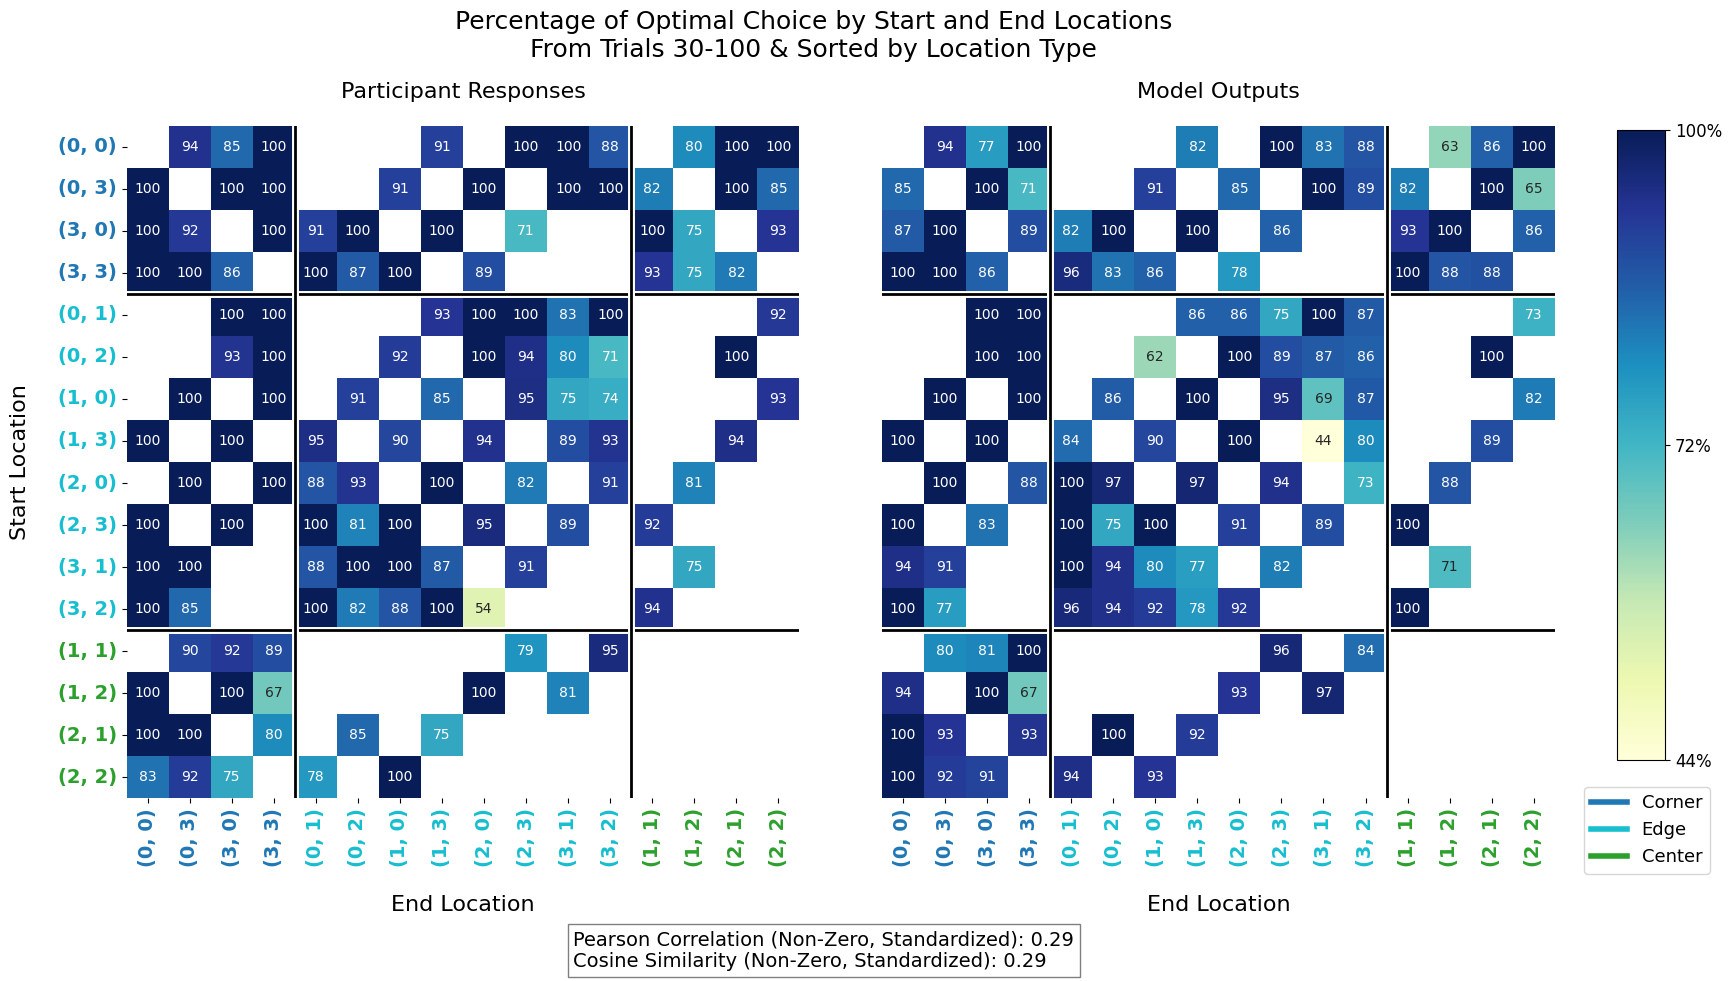

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler

def compute_optimal_response_percentage(df, optimality_column):
    grid_size = 4
    optimal_responses = np.zeros((grid_size, grid_size, grid_size, grid_size))

    for index, row in df.iterrows():
        start = tuple(map(int, row['start'][1:-1].split(',')))
        end = tuple(map(int, row['end'][1:-1].split(',')))
        optimal_responses[start[0], start[1], end[0], end[1]] += row[optimality_column]

    counts = np.zeros((grid_size, grid_size, grid_size, grid_size))
    for index, row in df.iterrows():
        start = tuple(map(int, row['start'][1:-1].split(',')))
        end = tuple(map(int, row['end'][1:-1].split(',')))
        counts[start[0], start[1], end[0], end[1]] += 1

    percentage_optimal = np.divide(optimal_responses, counts, out=np.zeros_like(optimal_responses), where=counts!=0) * 100
    return percentage_optimal

def load_data(folder_path):
    all_data = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

def group_coordinates_by_type(grid_size):
    corners = [(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)]
    centers = [(i, j) for i in range(1, grid_size-1) for j in range(1, grid_size-1)]
    edges = [(i, 0) for i in range(1, grid_size-1)] + [(i, grid_size-1) for i in range(1, grid_size-1)] + [(0, j) for j in range(1, grid_size-1)] + [(grid_size-1, j) for j in range(1, grid_size-1)]
    
    sorted_coords = corners + sorted(edges) + sorted(centers)
    return corners, edges, centers, sorted_coords

def compute_similarity(matrix1, matrix2, standardize=False):
    # Flatten the matrices
    vector1 = matrix1.flatten()
    vector2 = matrix2.flatten()

    # Create a mask for non-zero elements in both vectors
    non_zero_mask = (vector1 != 0) & (vector2 != 0)
    
    # Apply the mask to filter out zero elements
    filtered_vector1 = vector1[non_zero_mask]
    filtered_vector2 = vector2[non_zero_mask]

    # Ensure there are non-zero elements to compare
    if len(filtered_vector1) == 0 or len(filtered_vector2) == 0:
        return None, None, None, None, vector1, vector2, filtered_vector1, filtered_vector2

    # Standardize the vectors if required
    if standardize:
        scaler = StandardScaler()
        filtered_vector1 = scaler.fit_transform(filtered_vector1.reshape(-1, 1)).flatten()
        filtered_vector2 = scaler.fit_transform(filtered_vector2.reshape(-1, 1)).flatten()

    # Compute Pearson correlation and cosine similarity after exclusion
    pearson_corr_non_zero, _ = pearsonr(filtered_vector1, filtered_vector2)
    cosine_sim_non_zero = 1 - cosine(filtered_vector1, filtered_vector2)  # cosine function returns a distance, so subtract from 1
    
    return pearson_corr_non_zero, cosine_sim_non_zero, vector1, vector2, filtered_vector1, filtered_vector2

def plot_heatmap(data1, data2, grid_size=4, pearson_corr=None, cosine_sim=None):
    corners, edges, centers, sorted_coords = group_coordinates_by_type(grid_size)
    coord_index = {coord: idx for idx, coord in enumerate(sorted_coords)}

    heatmap_data1 = np.zeros((grid_size * grid_size, grid_size * grid_size))
    heatmap_data2 = np.zeros((grid_size * grid_size, grid_size * grid_size))

    for start_x in range(grid_size):
        for start_y in range(grid_size):
            for end_x in range(grid_size):
                for end_y in range(grid_size):
                    start_index = coord_index[(start_x, start_y)]
                    end_index = coord_index[(end_x, end_y)]
                    heatmap_data1[start_index, end_index] = data1[start_x, start_y, end_x, end_y]
                    heatmap_data2[start_index, end_index] = data2[start_x, start_y, end_x, end_y]

    # Mask zero values
    mask1 = (heatmap_data1 == 0)
    mask2 = (heatmap_data2 == 0)

    non_zero_data1 = heatmap_data1[~mask1]
    non_zero_data2 = heatmap_data2[~mask2]

    min_val = min(np.min(non_zero_data1), np.min(non_zero_data2))
    max_val = max(np.max(non_zero_data1), np.max(non_zero_data2))

    x_labels = [f"{coord}" for coord in sorted_coords]
    y_labels = [f"{coord}" for coord in sorted_coords]

    fig, axs = plt.subplots(1, 2, figsize=(24, 10))

    cmap = sns.color_palette("YlGnBu", as_cmap=True)
    cmap.set_under('grey')

    sns.heatmap(heatmap_data1, annot=True, fmt=".0f", cmap=cmap, xticklabels=x_labels, yticklabels=y_labels, vmin=min_val, vmax=max_val, mask=mask1, cbar=False, square=True, ax=axs[0])
    sns.heatmap(heatmap_data2, annot=True, fmt=".0f", cmap=cmap, xticklabels=x_labels, yticklabels=False, vmin=min_val, vmax=max_val, mask=mask2, cbar=False, square=True, ax=axs[1])

    axs[0].set_title("Participant Responses", fontsize=16, pad=20)
    axs[0].set_xlabel("End Location", fontsize=16, labelpad=20)
    axs[0].set_ylabel("Start Location", fontsize=16, labelpad=20)
    axs[0].tick_params(axis='x', rotation=90, labelsize=14)
    axs[0].tick_params(axis='y', rotation=0, labelsize=14)

    axs[1].set_title("Model Outputs", fontsize=16, pad=20)
    axs[1].set_xlabel("End Location", fontsize=16, labelpad=20)
    axs[1].tick_params(axis='x', rotation=90, labelsize=14)
    axs[1].tick_params(axis='y', rotation=0, labelsize=14)

    # Define colors for each group
    color_map = {
        'corner': 'tab:blue',
        'edge': 'tab:cyan',
        'center': 'tab:green'
    }
    
    # Apply colors to x and y labels
    def get_label_color(coord):
        if coord in [(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)]:
            return color_map['corner']
        elif coord[0] == 0 or coord[0] == grid_size-1 or coord[1] == 0 or coord[1] == grid_size-1:
            return color_map['edge']
        else:
            return color_map['center']

    for tick in axs[0].get_xticklabels():
        tick.set_color(get_label_color(eval(tick.get_text())))
        tick.set_fontweight('heavy')
    for tick in axs[0].get_yticklabels():
        tick.set_color(get_label_color(eval(tick.get_text())))
        tick.set_fontweight('heavy')
    for tick in axs[1].get_xticklabels():
        tick.set_color(get_label_color(eval(tick.get_text())))
        tick.set_fontweight('heavy')

    # Manually set the position of the color bar
    cbar_ax = fig.add_axes([0.69, 0.22, 0.02, 0.63])  # [left, bottom, width, height]
    cbar = fig.colorbar(axs[0].collections[0], cax=cbar_ax)
    cbar.set_ticks([min_val, (min_val + max_val) / 2, max_val])
    cbar.set_ticklabels([f'{min_val:.0f}%', f'{(min_val + max_val) / 2:.0f}%', f'{max_val:.0f}%'], fontsize=12)

    # Add similarity measures as text annotations
    if pearson_corr is not None and cosine_sim is not None:
        textstr = f'Pearson Correlation (Non-Zero, Standardized): {pearson_corr:.2f}\nCosine Similarity (Non-Zero, Standardized): {cosine_sim:.2f}'
        fig.text(0.255, 0.05, textstr, fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    plt.suptitle("Percentage of Optimal Choice by Start and End Locations\nFrom Trials 30-100 & Sorted by Location Type", fontsize=18, x=0.355, y=0.97, ha='center')
    plt.tight_layout(rect=[0, 0.05, 0.7, 0.98])  # [left, bottom, right, top]

    # Add a legend for the colors
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='tab:blue', lw=4, label='Corner'),
        Line2D([0], [0], color='tab:cyan', lw=4, label='Edge'),
        Line2D([0], [0], color='tab:green', lw=4, label='Center')
    ]
    axs[1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.03, 0.03), fontsize=13)
    
    # Add lines to separate boundaries of different location types
    num_corners = len([(0, 0), (0, grid_size-1), (grid_size-1, 0), (grid_size-1, grid_size-1)])
    num_edges = len([(i, 0) for i in range(1, grid_size-1)] + [(i, grid_size-1) for i in range(1, grid_size-1)] + [(0, j) for j in range(1, grid_size-1)] + [(grid_size-1, j) for j in range(1, grid_size-1)])
    
    corner_index = num_corners
    edge_index = corner_index + num_edges

    for ax in axs:
        # Draw horizontal lines
        ax.axhline(y=corner_index, color='white', linewidth=5)
        ax.axhline(y=corner_index, color='black', linewidth=2)
        ax.axhline(y=edge_index, color='white', linewidth=5)
        ax.axhline(y=edge_index, color='black', linewidth=2)
        # Draw vertical lines
        ax.axvline(x=corner_index, color='white', linewidth=5)
        ax.axvline(x=corner_index, color='black', linewidth=2)
        ax.axvline(x=edge_index, color='white', linewidth=5)
        ax.axvline(x=edge_index, color='black', linewidth=2)

def compute_grouped_correlations(matrix1, matrix2, grid_size=4, by_start=True):
    corners, edges, centers, _ = group_coordinates_by_type(grid_size)
    
    groups = {
        'corner': corners,
        'edge': edges,
        'center': centers
    }

    correlations = {}

    for group_name, group_coords in groups.items():
        if by_start:
            vector1 = np.concatenate([matrix1[x, y].flatten() for x, y in group_coords])
            vector2 = np.concatenate([matrix2[x, y].flatten() for x, y in group_coords])
        else:
            vector1 = np.concatenate([matrix1[:, :, x, y].flatten() for x, y in group_coords])
            vector2 = np.concatenate([matrix2[:, :, x, y].flatten() for x, y in group_coords])

        non_zero_mask = (vector1 != 0) & (vector2 != 0)
        filtered_vector1 = vector1[non_zero_mask]
        filtered_vector2 = vector2[non_zero_mask]

        if len(filtered_vector1) == 0 or len(filtered_vector2) == 0:
            correlations[group_name] = (None, None)
        else:
            scaler = StandardScaler()
            filtered_vector1 = scaler.fit_transform(filtered_vector1.reshape(-1, 1)).flatten()
            filtered_vector2 = scaler.fit_transform(filtered_vector2.reshape(-1, 1)).flatten()
            pearson_corr, _ = pearsonr(filtered_vector1, filtered_vector2)
            cosine_sim = 1 - cosine(filtered_vector1, filtered_vector2)
            correlations[group_name] = (pearson_corr, cosine_sim)

    return correlations

def main():
    folder_path1 = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData/PreprocessedSubjectData'
    folder_path2 = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData/ModelOutput_24_with_options'
    
    df1 = load_data(folder_path1)
    df2 = load_data(folder_path2)
    
    df1 = df1[(df1['trial'] >= 30) & (df1['trial'] <= 100)]  # Filter trials 30-100
    df2 = df2[(df2['trial'] >= 30) & (df2['trial'] <= 100)]  # Filter trials 30-100

    percentage_optimal1 = compute_optimal_response_percentage(df1, 'optimal_response')
    percentage_optimal2 = compute_optimal_response_percentage(df2, 'optimality')

    pearson_corr_non_zero, cosine_sim_non_zero, vector1, vector2, filtered_vector1, filtered_vector2 = compute_similarity(percentage_optimal1, percentage_optimal2, standardize=True)

    plot_heatmap(percentage_optimal1, percentage_optimal2, grid_size=4, pearson_corr=pearson_corr_non_zero, cosine_sim=cosine_sim_non_zero)
    
    if pearson_corr_non_zero is None or cosine_sim_non_zero is None:
        print("Not enough non-zero elements to compute similarity.")

    print("\nCorrelations by start type:")
    grouped_correlations_by_start = compute_grouped_correlations(percentage_optimal1, percentage_optimal2, grid_size=4, by_start=True)
    for group_name, (pearson_corr, cosine_sim) in grouped_correlations_by_start.items():
        if pearson_corr is not None and cosine_sim is not None:
            print(f"{group_name.capitalize()} - Pearson Correlation: {pearson_corr:.2f}, Cosine Similarity: {cosine_sim:.2f}")
        else:
            print(f"{group_name.capitalize()} - Not enough non-zero elements to compute similarity.")

    print("\nCorrelations by end type:")
    grouped_correlations_by_end = compute_grouped_correlations(percentage_optimal1, percentage_optimal2, grid_size=4, by_start=False)
    for group_name, (pearson_corr, cosine_sim) in grouped_correlations_by_end.items():
        if pearson_corr is not None and cosine_sim is not None:
            print(f"{group_name.capitalize()} - Pearson Correlation: {pearson_corr:.2f}, Cosine Similarity: {cosine_sim:.2f}")
        else:
            print(f"{group_name.capitalize()} - Not enough non-zero elements to compute similarity.")

    # Save the combined plot as a PNG file in folder_path
    folder_path = '/Users/leowong/Desktop/Modelling Spatial Navigation/BehaviouralData'
    plt.savefig(os.path.join(folder_path, 'optimal_response_comparison_heatmap_by_location_type_30_100.png'))
    plt.show()

main()
